In [1]:
from astropy.table import Table
from astropy.io import fits
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from minisom import MiniSom
import pickle
import os

In [2]:
df_L3_info = Table.read('../dataset/L3_COSMOS2020_Richard_RefCat_2023DEC4_info.fits')
df_L3_info = df_L3_info.to_pandas().sort_values(by = "cosmos_id")

fname = 'D:/SPHEREx_SOM/dataset/sphx_refcat/Noiseless_phot_cosmos_nolines_refcat30k.txt'
data_noiseless = np.loadtxt(fname)[:,3:]

fname = 'D:/SPHEREx_SOM/dataset/sphx_refcat/NoisySphx_shallow_nolines_refcat30k.txt'
data_all = np.loadtxt(fname)[:,3:]
index = np.loadtxt(fname)[:,0]

fname = 'D:/SPHEREx_SOM/dataset/sphx_refcat/NoisySphx_deep_nolines_refcat30k.txt'
data_deep = np.loadtxt(fname)[:,3:]

fname = 'D:/SPHEREx_SOM/dataset/sphx_refcat/SPHEREx_1sigma_noise.txt'
data_1sig  = np.loadtxt(fname, skiprows=1)
wl = data_1sig[:,0]
sigma_all = data_1sig[:,1]
sigma_deep = data_1sig[:,2]

In [3]:
def remove_low_SNR(data, data_err, info_data, mode, mag_cut):
    i_band = info_data["HSC_i_MAG"].values
    if mode == "mag_cut" or mode == "both":
        if type(mag_cut) == type(1):
            max_cut = np.mean(i_band) - np.std(i_band, ddof = 1) * mag_out
            data = data[i_band < max_cut]
            data_err = data[i_band < max_cut]
            info_data = info_data[np.logical_and((i_band < mag_cut[1]), (i_band > mag_cut[0]))]
        else:
            data = data[np.logical_and((i_band < mag_cut[1]), (i_band > mag_cut[0]))]
            data_err = data_err[np.logical_and((i_band < mag_cut[1]), (i_band > mag_cut[0]))]
            info_data = info_data[np.logical_and((i_band < mag_cut[1]), (i_band > mag_cut[0]))]
    if mode == "band_cut" or mode == "both":
        data = data[:, : len(data[0]) - 34]
        data_err = data_err[:, : len(data_err[0]) - 34]
        
    return data, data_err, info_data

In [4]:
def basic_som(data, err, info_data, dim, preproc, distance, data_type, iteration = 1, sigma = 1, rate = 1, save = False):
    som = MiniSom(dim, dim, data.shape[1], sigma = sigma, learning_rate = rate, activation_distance = distance)
    som.random_weights_init(data)
    som.train(data, err, num_iteration = iteration, use_epochs = True)

    print("Finish traininging SOM.")
    print("Start making diagrams...")

    density_map = np.zeros(dim ** 2).reshape(dim, dim)
    magnitude_map = np.zeros(dim ** 2).reshape(dim, dim)
    magnitude_map.fill(np.nan)
    z_map = np.zeros(dim ** 2).reshape(dim, dim)
    z_map.fill(np.nan)
    
    labels_map_1 = som.labels_map(data, err, [0] * len(data))
    labels_map_2 = som.labels_map(data, err, tuple(map(tuple, np.concatenate((np.expand_dims(info_data["HSC_i_MAG"].values, axis = 1), np.expand_dims(info_data["z_true"].values, axis = 1)), axis = -1))))

    for i in labels_map_1.keys():
        density_map[int(list(i)[0]), int(list(i)[1])] = labels_map_1[i][0]

    print("Finish collecting data for density map.")
    
    for i in labels_map_2.keys():
        properties = np.mean(np.array(list(labels_map_2[i].keys())), axis = 0)
        magnitude_map[int(list(i)[0]), int(list(i)[1])] = properties[0]
        z_map[int(list(i)[0]), int(list(i)[1])] = properties[1]

    print("Finish collecting data for magnitude map.")
    print([dim, sigma, rate])
    print(f"Topological error: {som.topographic_error(data)}")
    print(f"Quantization error: {som.quantization_error(data)}")
    print(np.sum(density_map))

    %matplotlib inline
    plt.close()
    plt.figure(figsize = (25, 25))
    plt.subplot(221)
    plt.pcolor(som.distance_map().T, cmap='YlGn')  # plotting the distance map as background
    plt.colorbar()
    plt.title("Distance map (U-matrix)")

    plt.subplot(222)
    plt.pcolor(density_map.T, cmap='YlGn')
    plt.colorbar()
    plt.title("Density Map")

    plt.subplot(223)
    plt.pcolor(magnitude_map.T, cmap="plasma" + "_r")
    plt.colorbar()
    plt.title("HSC I Magnitude Map")

    plt.subplot(224)
    plt.pcolor(z_map.T, cmap="plasma")
    plt.colorbar()
    plt.title("True Redshift Map")
    if save:
        plt.savefig(f"D:/SPHEREx_SOM/record/2nd_exploration/diagram/{data_type}_{len(data[0])}_{dim}_{sigma}_{rate}_{iteration}.jpg", bbox_inches = "tight")
    
    plt.show()

    if os.path.isfile("D:/SPHEREx_SOM/record/2nd_exploration/record.pkl"):
        with open("D:/SPHEREx_SOM/record/2nd_exploration/record.pkl", "rb") as fh:
            record = pickle.load(fh)
    else:
        record = []

    map_record = {}
    map_record["dim"] = dim
    map_record["sigma"] = sigma
    map_record["rate"] = rate
    map_record["band_cut"] = len(data[0])
    map_record["mag_cut"] = len(data)
    map_record["preproc"] = preproc
    map_record["som"] = som
    map_record["topo_err"] = som.topographic_error(data)
    map_record["quan_err"] = som.quantization_error(data)
    map_record["density"] = density_map
    map_record["magnitude"] = magnitude_map
    map_record["z"] = z_map
    map_record["type"] = data_type
    map_record["distance"] = distance
    map_record["iter"] = iteration
    
    record.append(map_record)
    
    try:
        with open("D:/SPHEREx_SOM/record/2nd_exploration/record.pkl", 'wb') as fh:
            pickle.dump(record, fh, protocol=pickle.HIGHEST_PROTOCOL)
    except KeyboardInterrupt:
        print('KeyboardInterrupt caught, data saved.')
    
    return som

In [9]:
info = df_L3_info[-pd.DataFrame(data_noiseless).isna()[0]]
data = pd.DataFrame(data_noiseless).dropna()
info = info[-data[data > 0].isna()[0]]
data = data[data > 0].dropna().to_numpy()

C:\Users\ASUS\AppData\Local\Temp\ipykernel_21744\346024421.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  info = df_L3_info[-pd.DataFrame(data_noiseless).isna()[0]]
C:\Users\ASUS\AppData\Local\Temp\ipykernel_21744\346024421.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  info = info[-data[data > 0].isna()[0]]


In [10]:
data = -2.5 * np.log10(data / 10 ** 6) + 8.9
proc_data = -np.diff(data, axis = -1)
# proc_data = (proc_data - np.mean(proc_data, axis=0)) / np.std(proc_data, ddof = 1, axis=0)
err = np.zeros_like(proc_data)

In [11]:
proc_data, err, info = remove_low_SNR(data = proc_data, data_err = err, info_data = info, mode = None, mag_cut = None)

D:\miniconda\envs\SPHEREx_SOM\Lib\site-packages\minisom.py:164: UserWarning: Warning: sigma is too high for the dimension of the map.
  warn('Warning: sigma is too high for the dimension of the map.')


Finish traininging SOM.
Start making diagrams...
Finish collecting data for density map.
Finish collecting data for magnitude map.
[30, 30, 0.1]
Topological error: 0.002189805612640232
Quantization error: 0.36255612524511033
29683.0


C:\Users\ASUS\AppData\Local\Temp\ipykernel_21744\3713323012.py:49: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_21744\3713323012.py:54: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


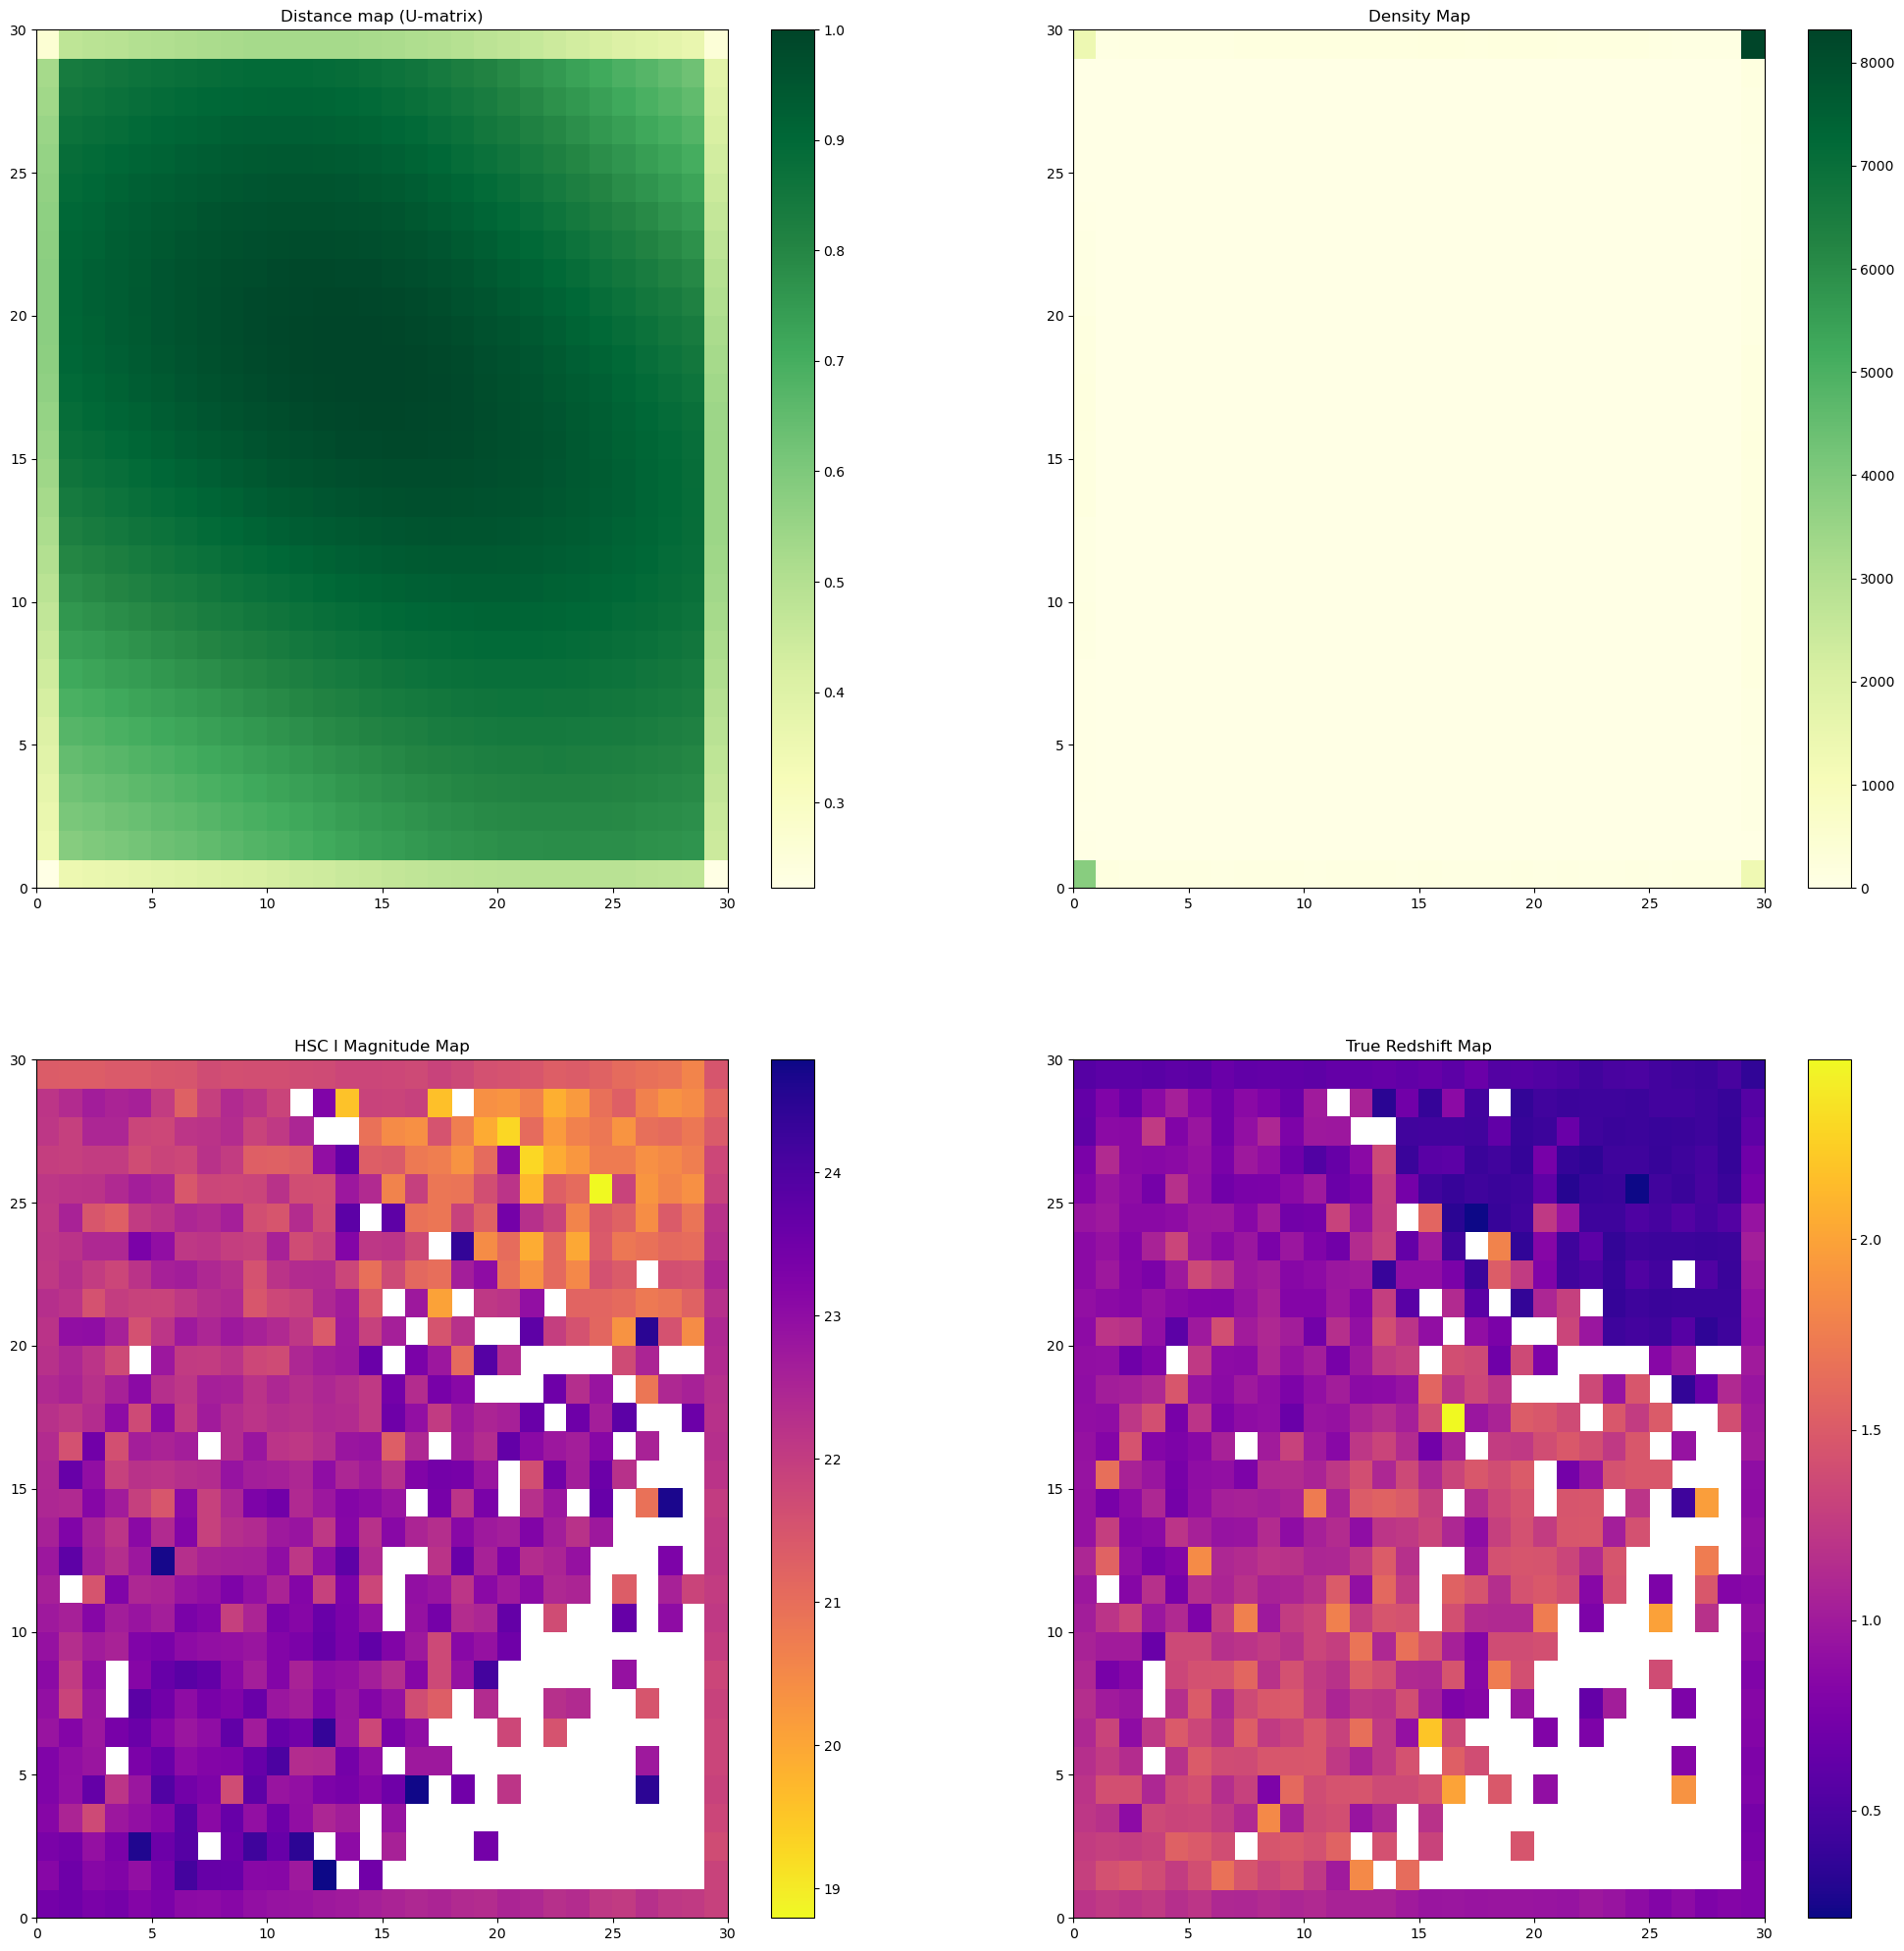

Finish traininging SOM.
Start making diagrams...
Finish collecting data for density map.
Finish collecting data for magnitude map.
[30, 30, 0.2]
Topological error: 0.004682815079338342
Quantization error: 0.36932269984039157
29683.0


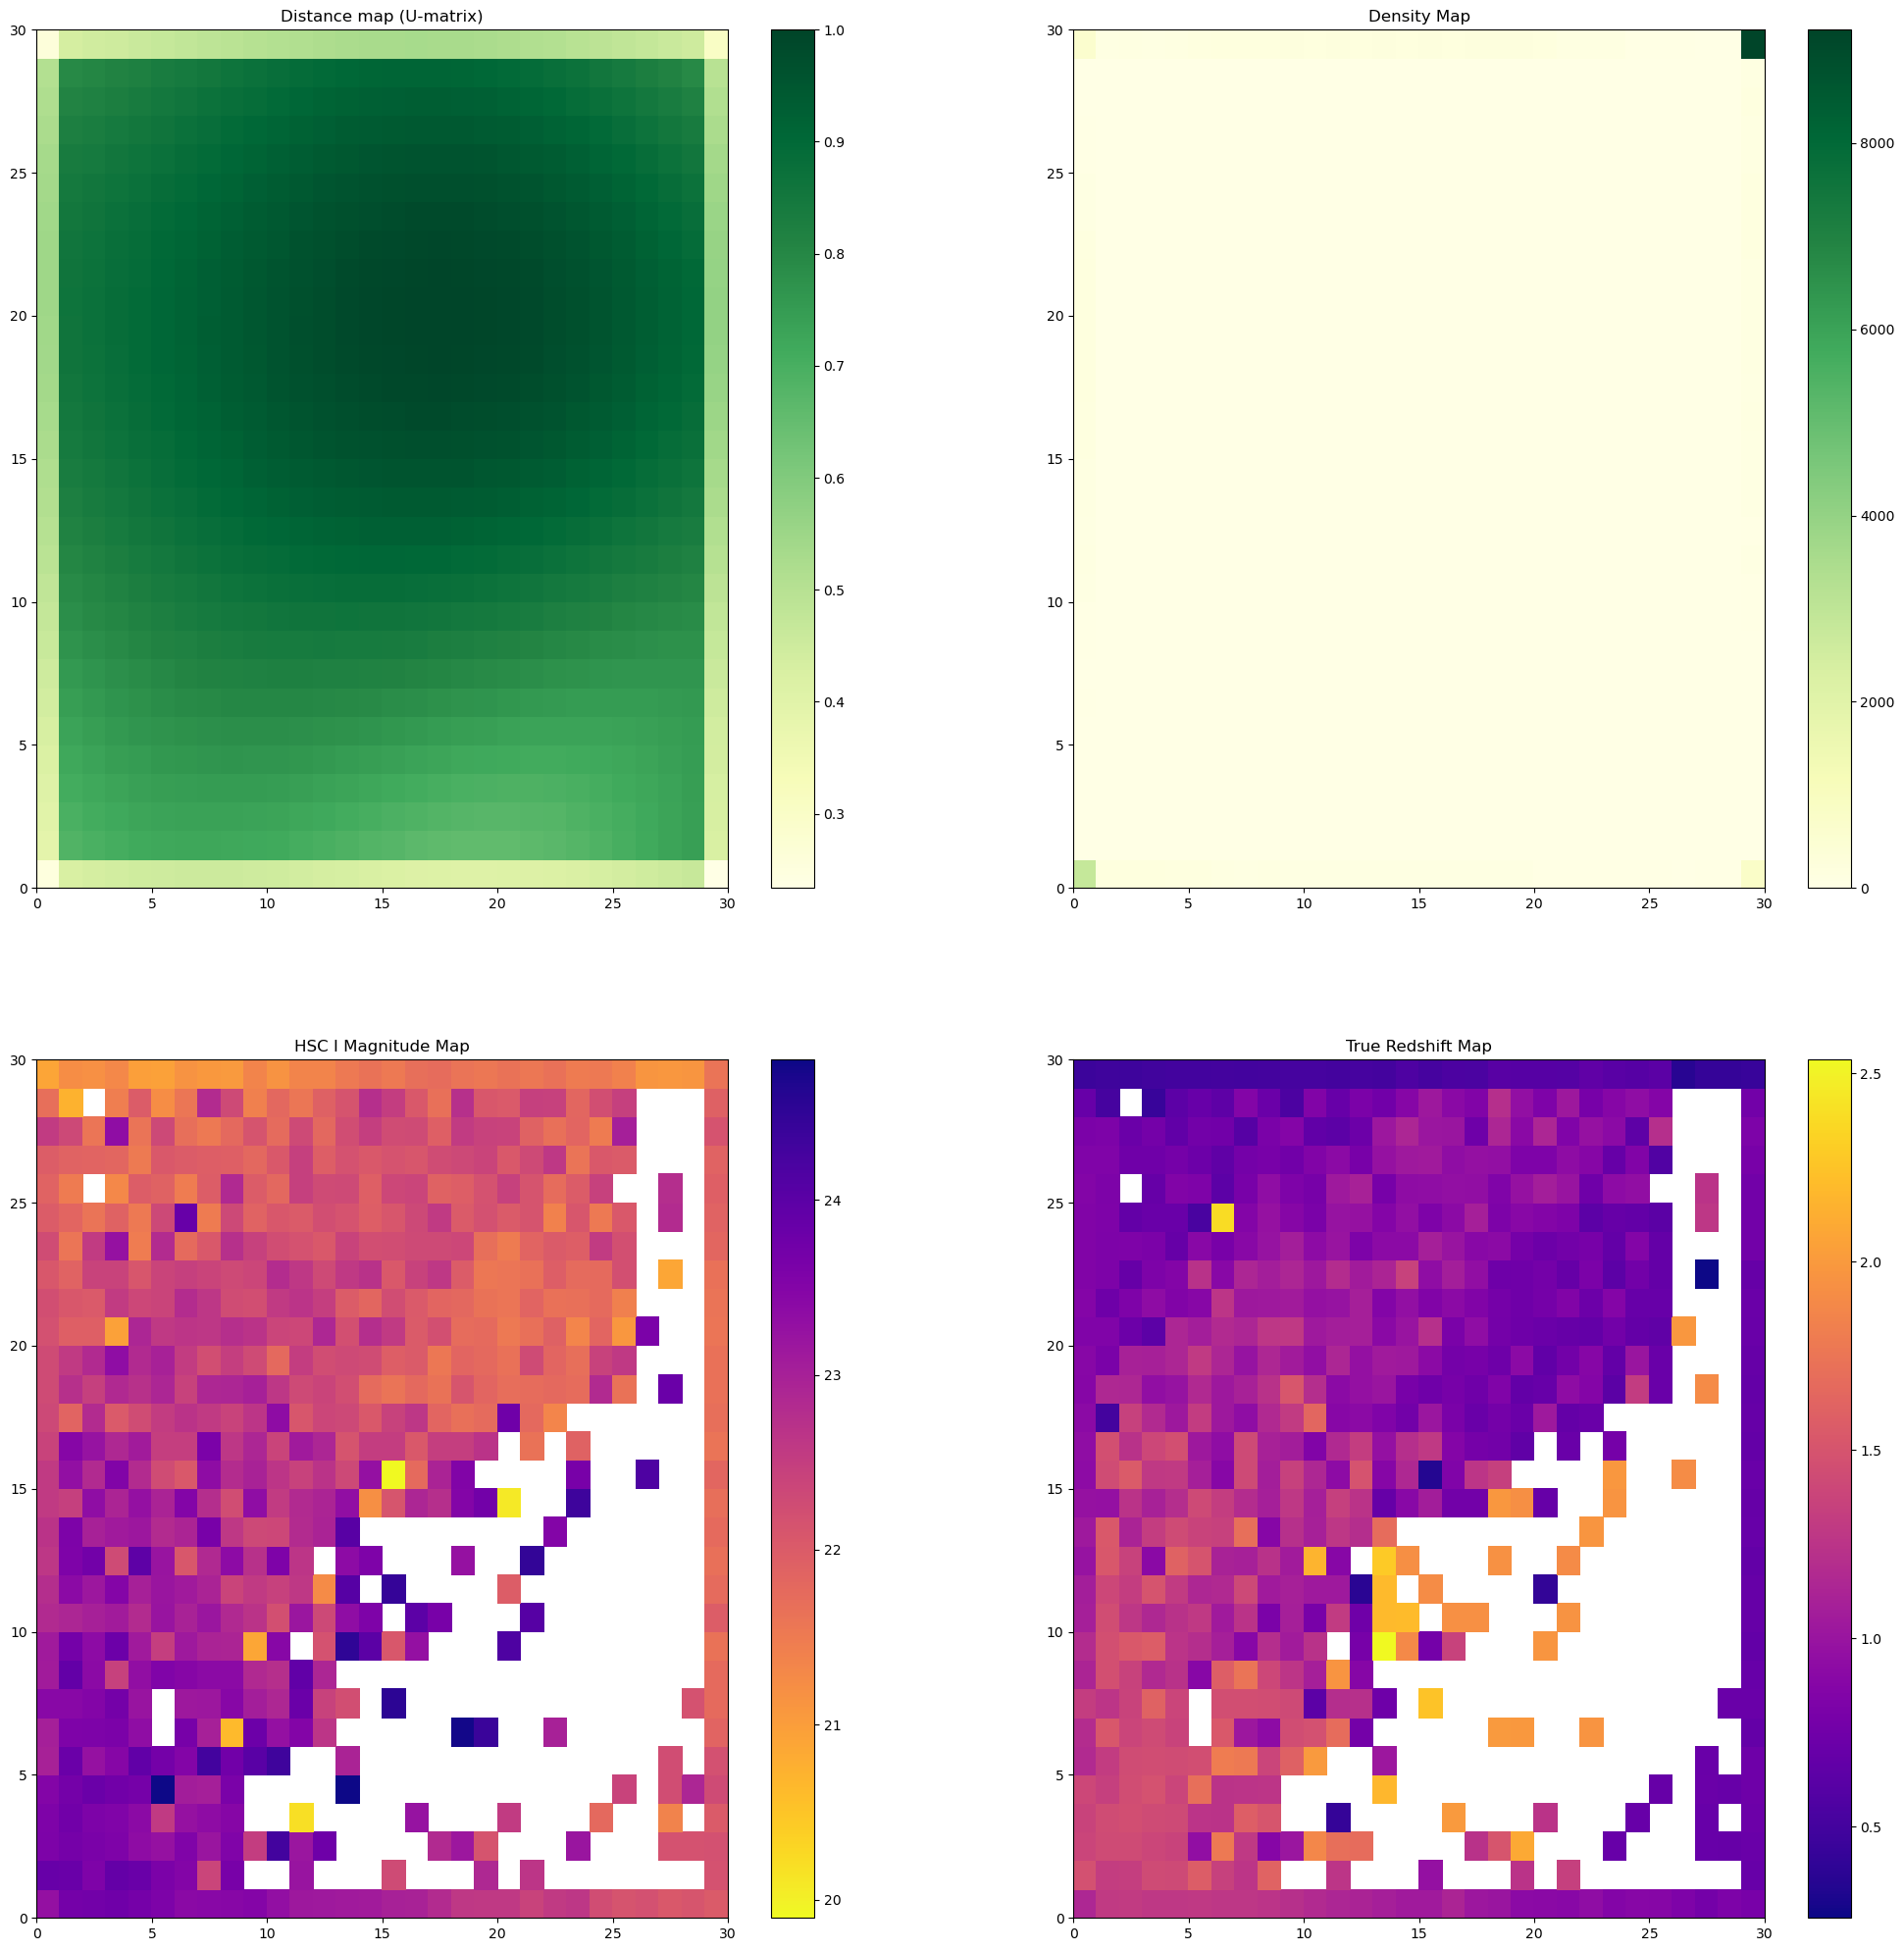

Finish traininging SOM.
Start making diagrams...
Finish collecting data for density map.
Finish collecting data for magnitude map.
[30, 30, 0.3]
Topological error: 0.010376309672202945
Quantization error: 0.3763529391092216
29683.0


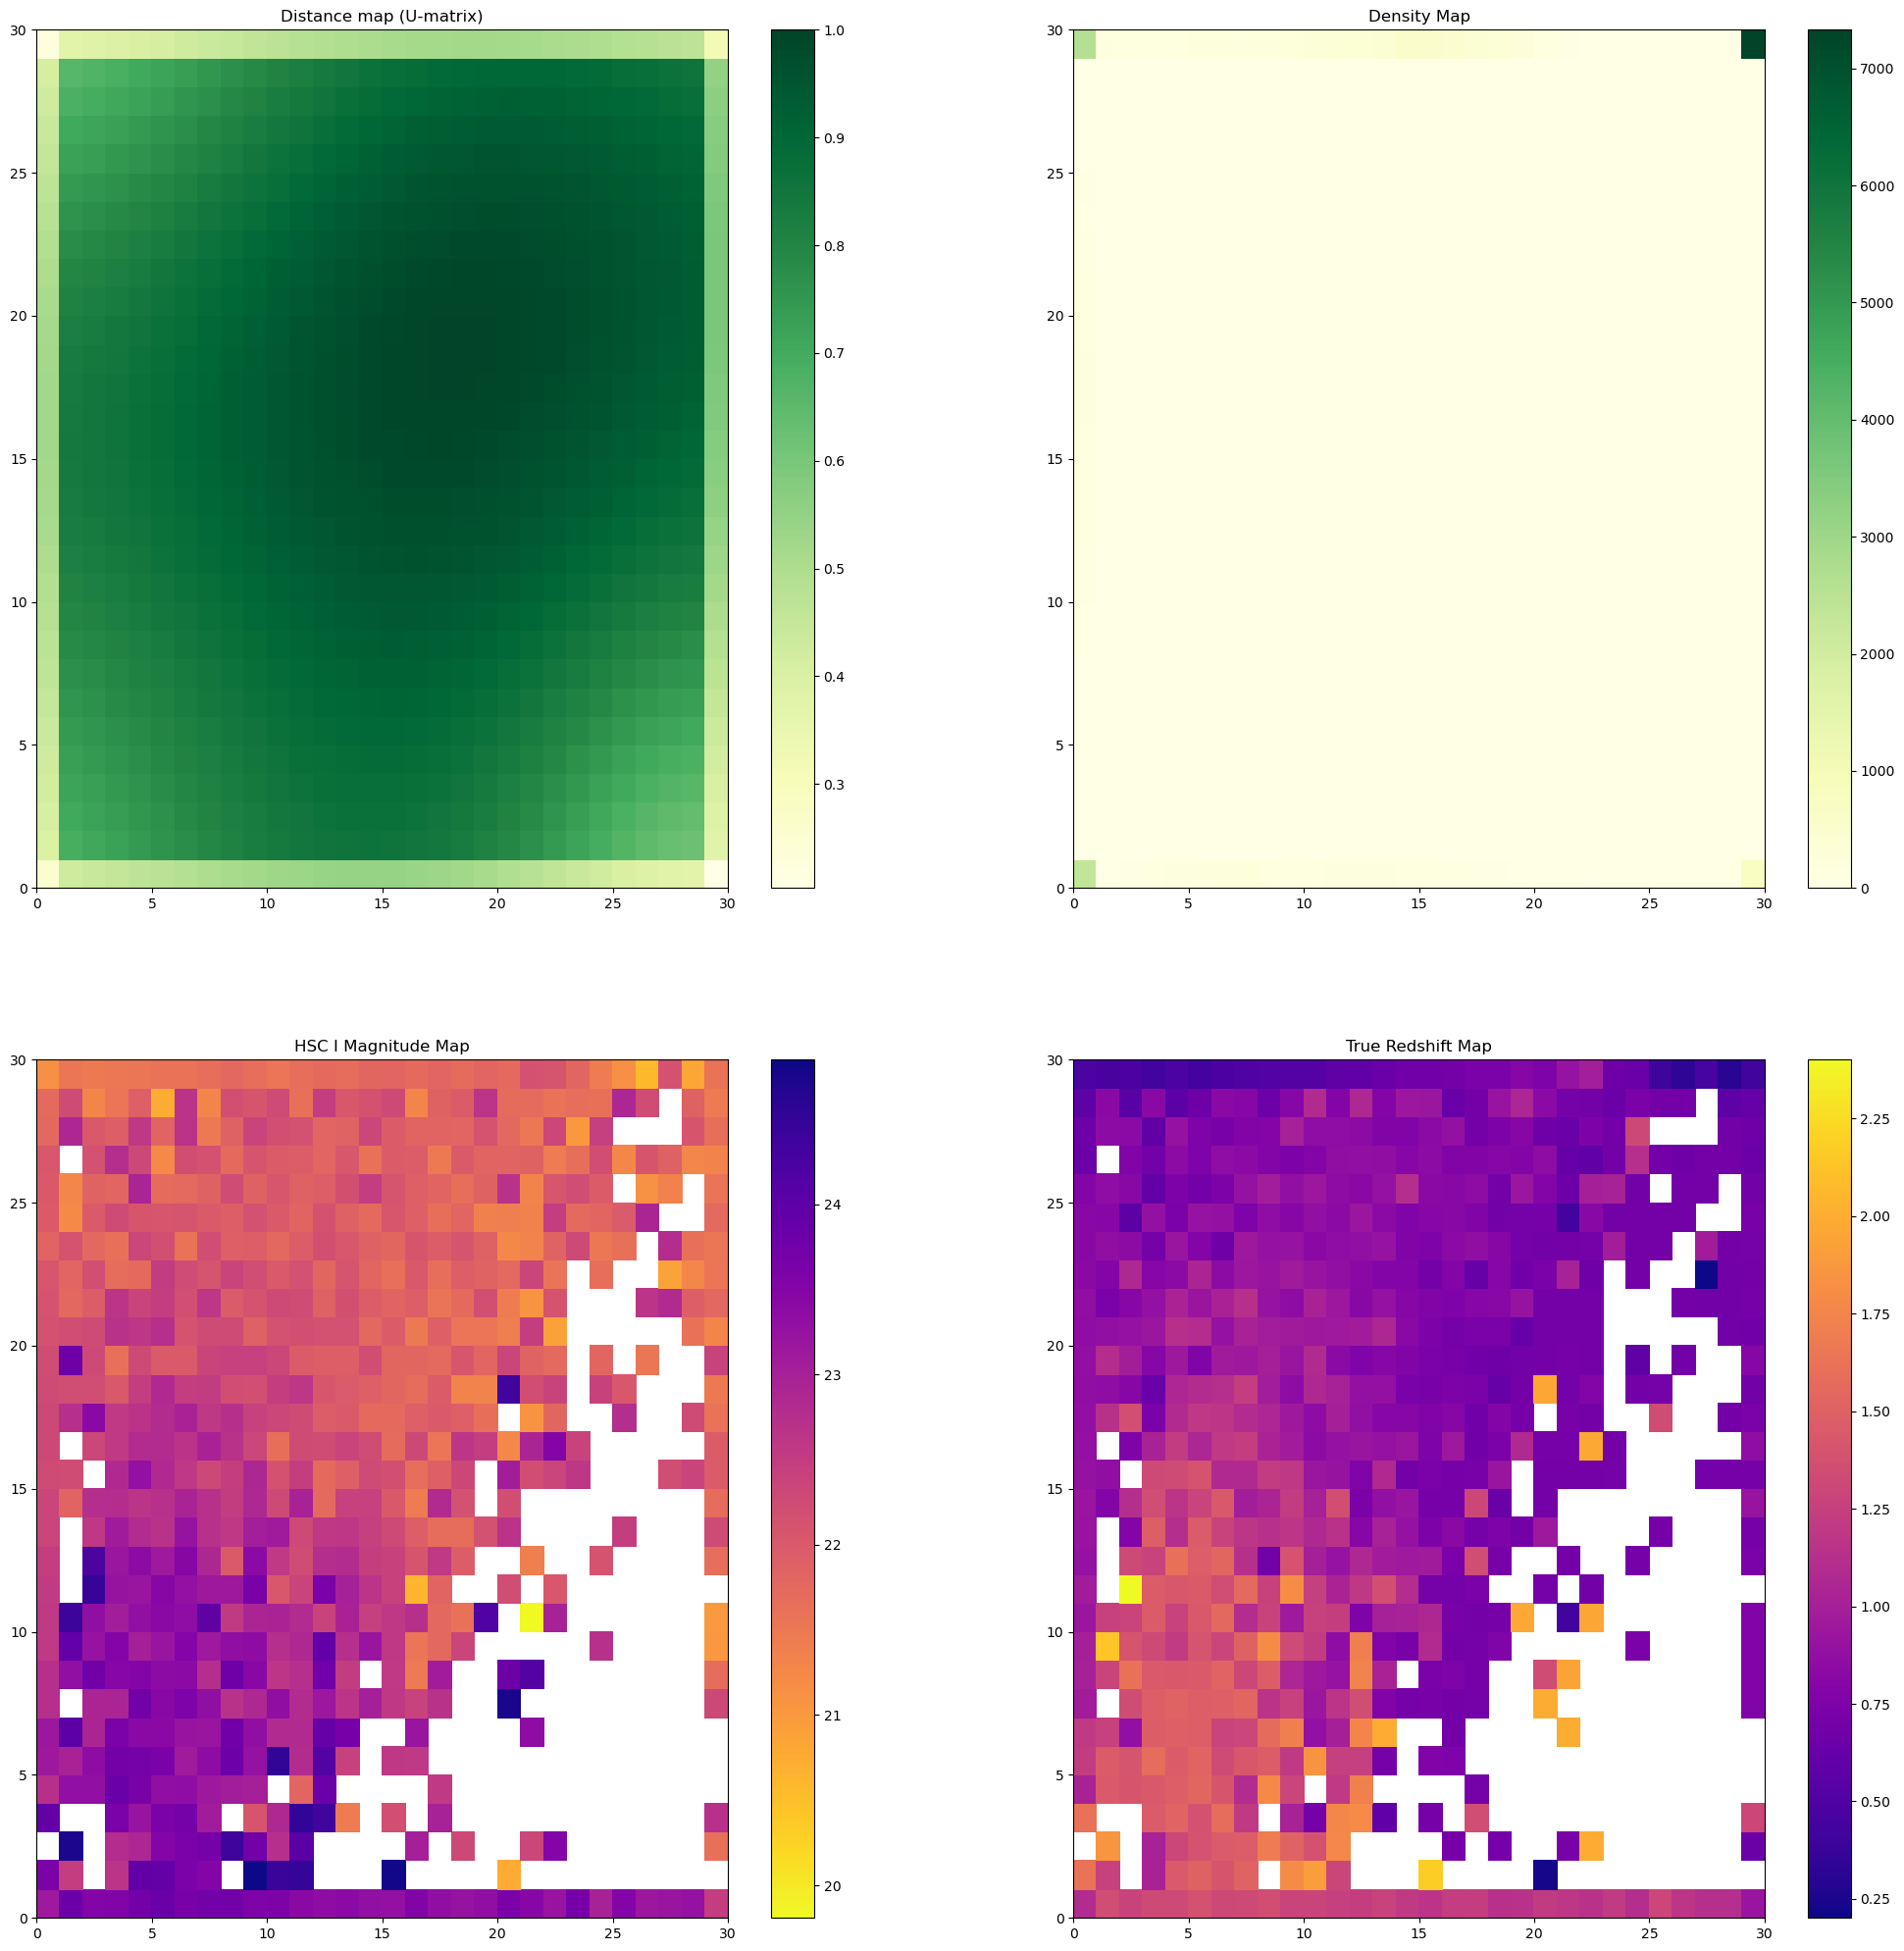

Finish traininging SOM.
Start making diagrams...
Finish collecting data for density map.
Finish collecting data for magnitude map.
[30, 30, 0.4]
Topological error: 0.011117474648788869
Quantization error: 0.3818151757055302
29683.0


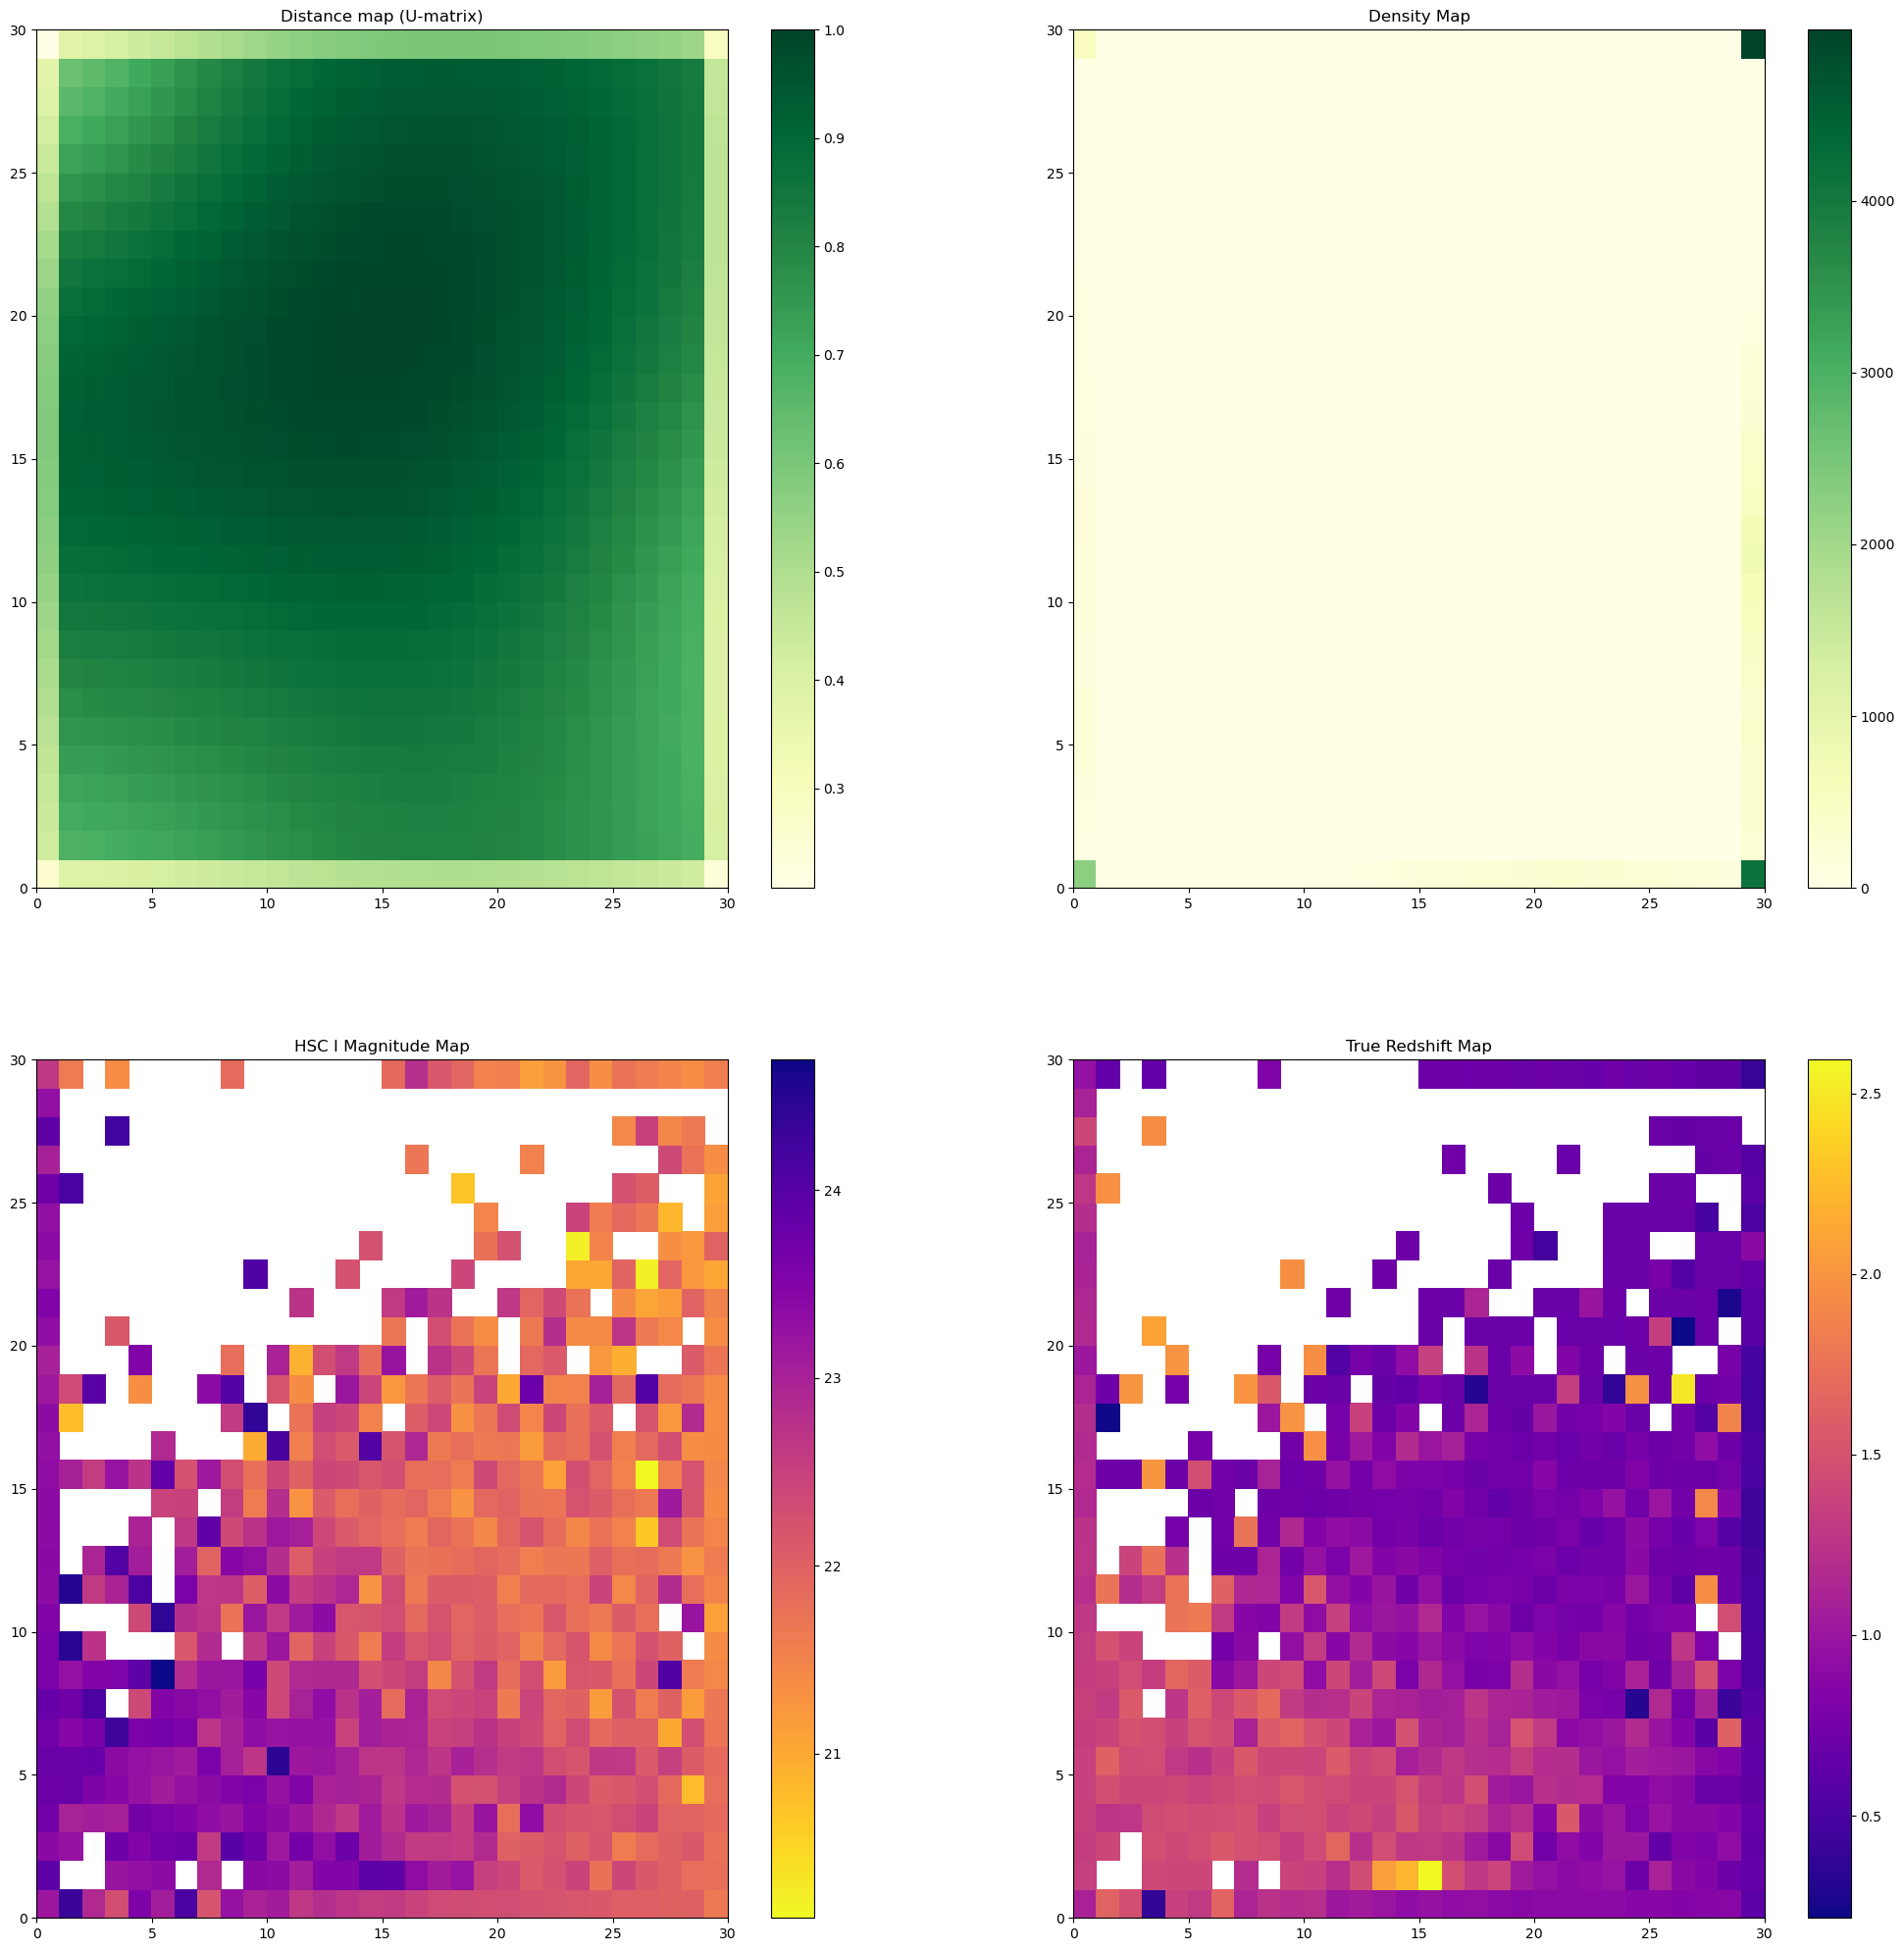

Finish traininging SOM.
Start making diagrams...
Finish collecting data for density map.
Finish collecting data for magnitude map.
[30, 30, 0.5]
Topological error: 0.0018529124414648115
Quantization error: 0.3854318130377823
29683.0


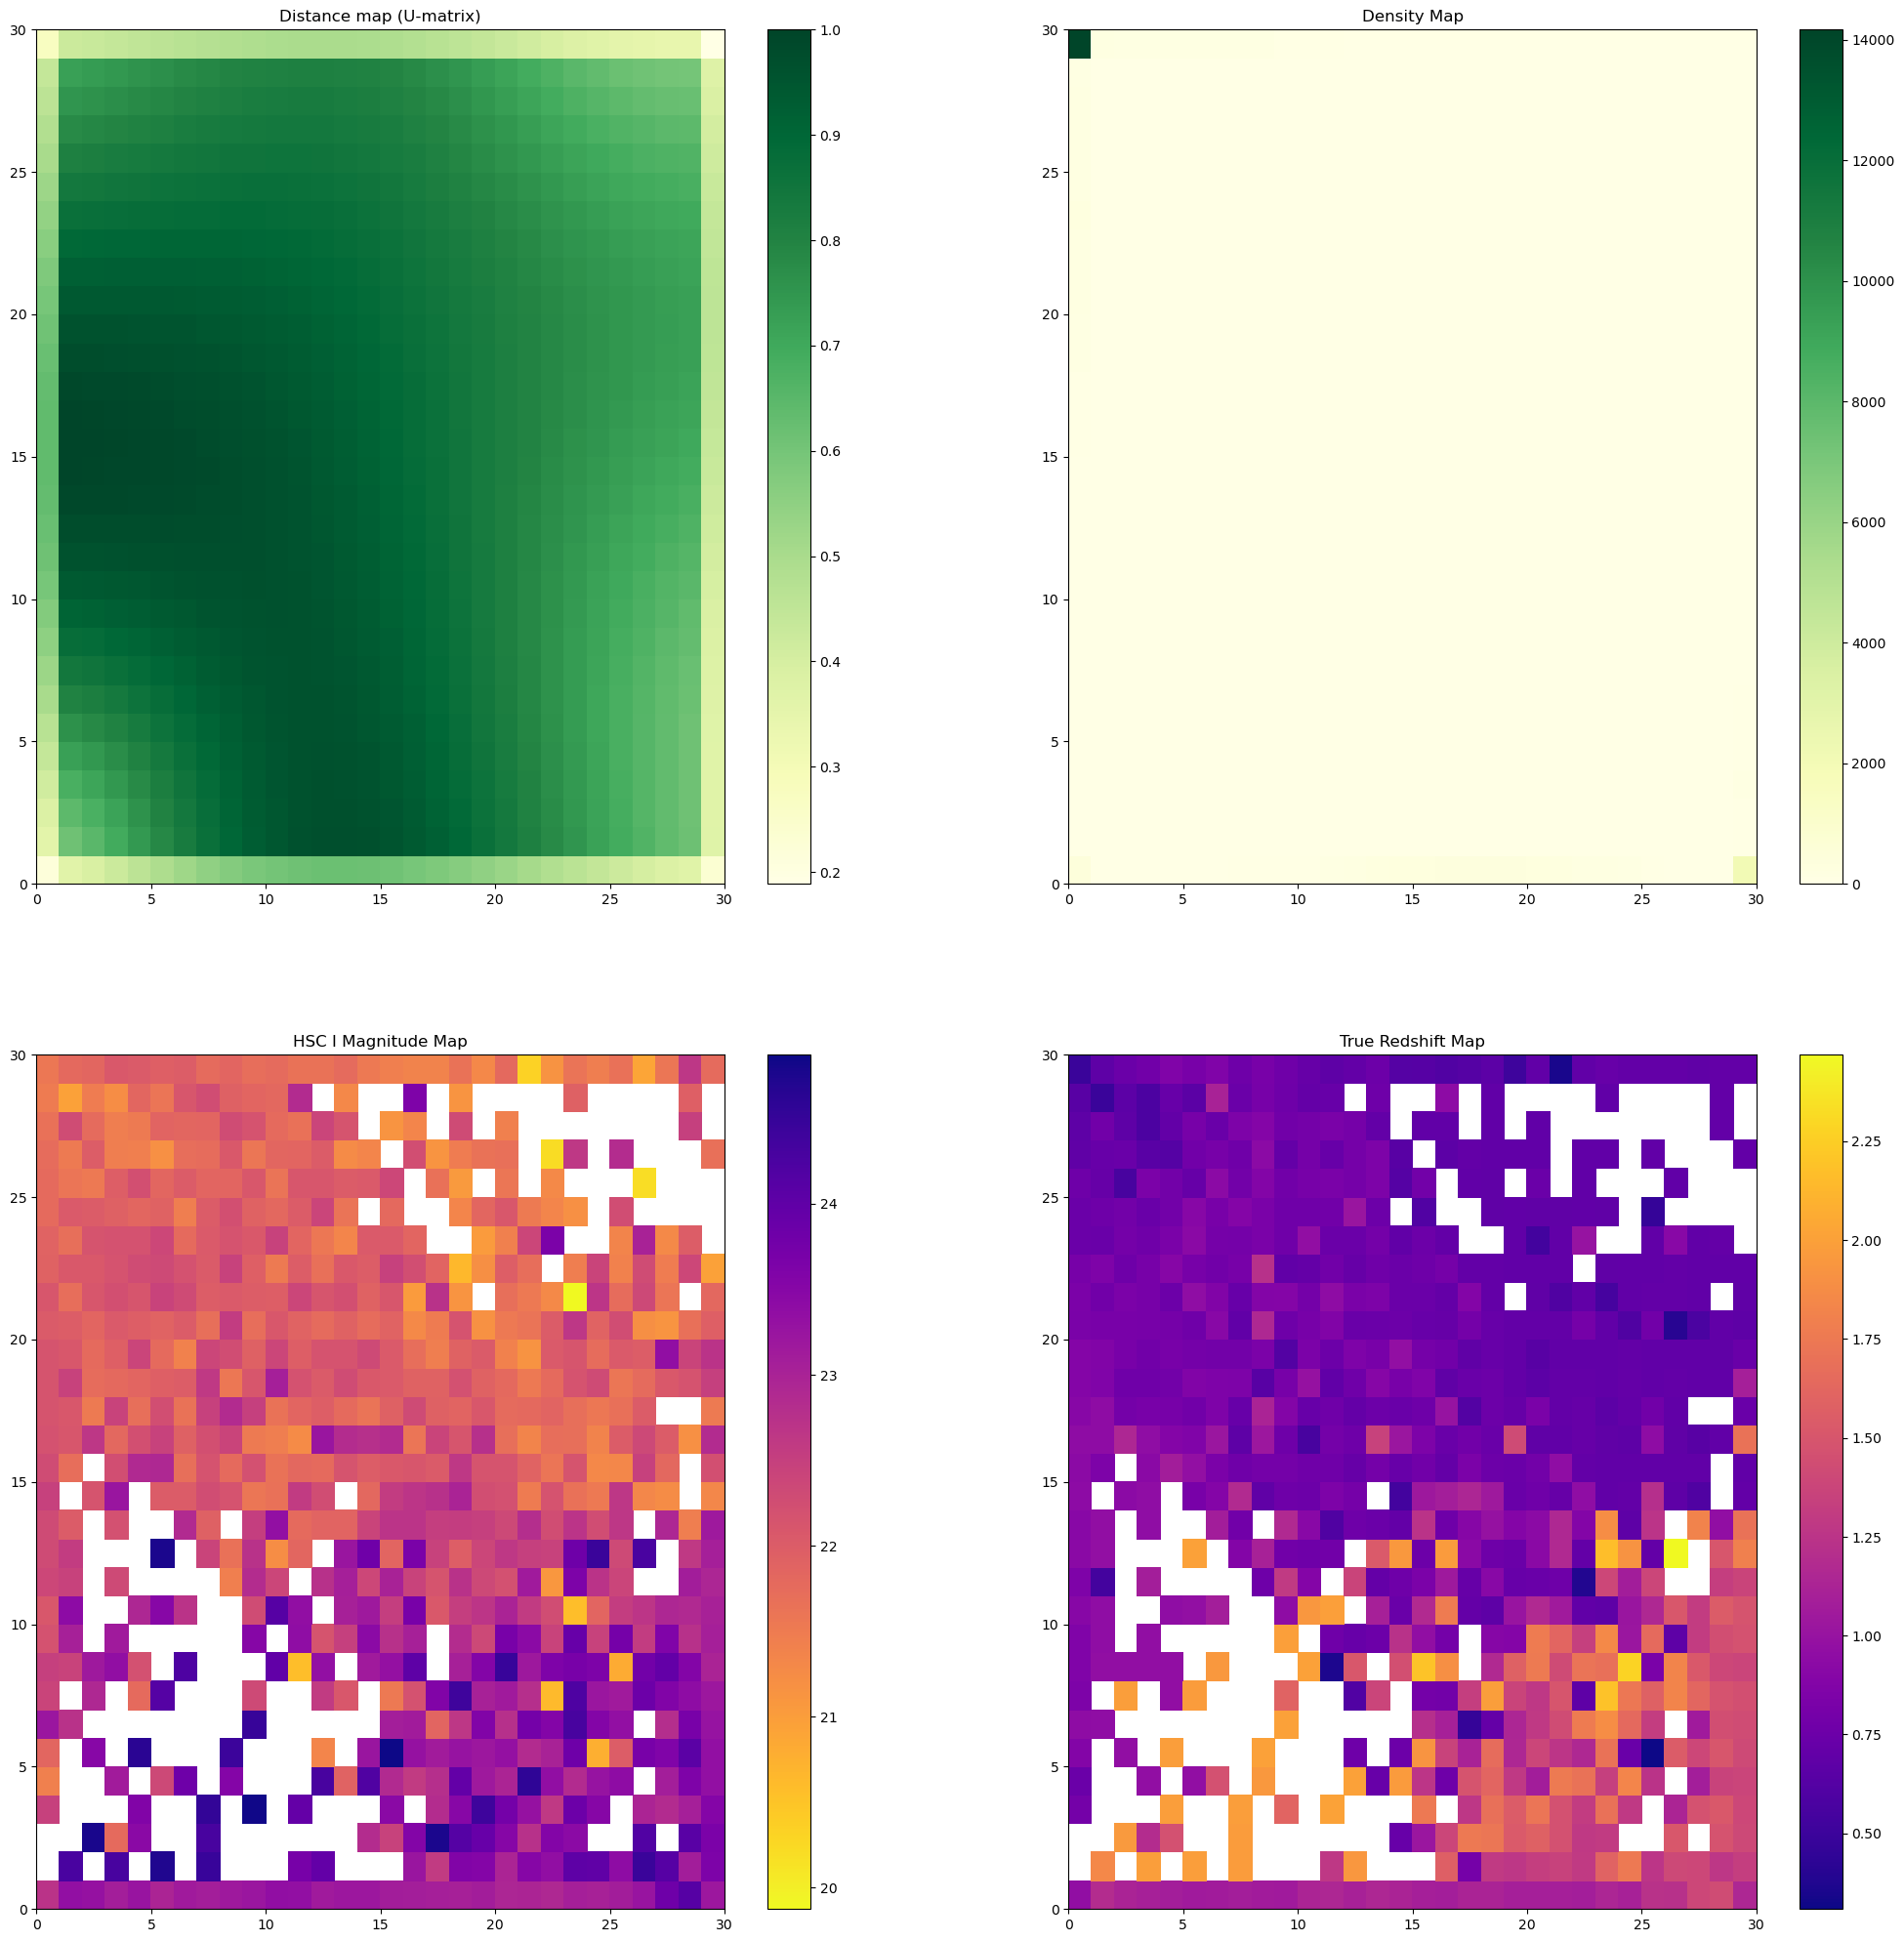

Finish traininging SOM.
Start making diagrams...
Finish collecting data for density map.
Finish collecting data for magnitude map.
[30, 30, 0.6]
Topological error: 0.0068389313748610315
Quantization error: 0.39507691092395314
29683.0


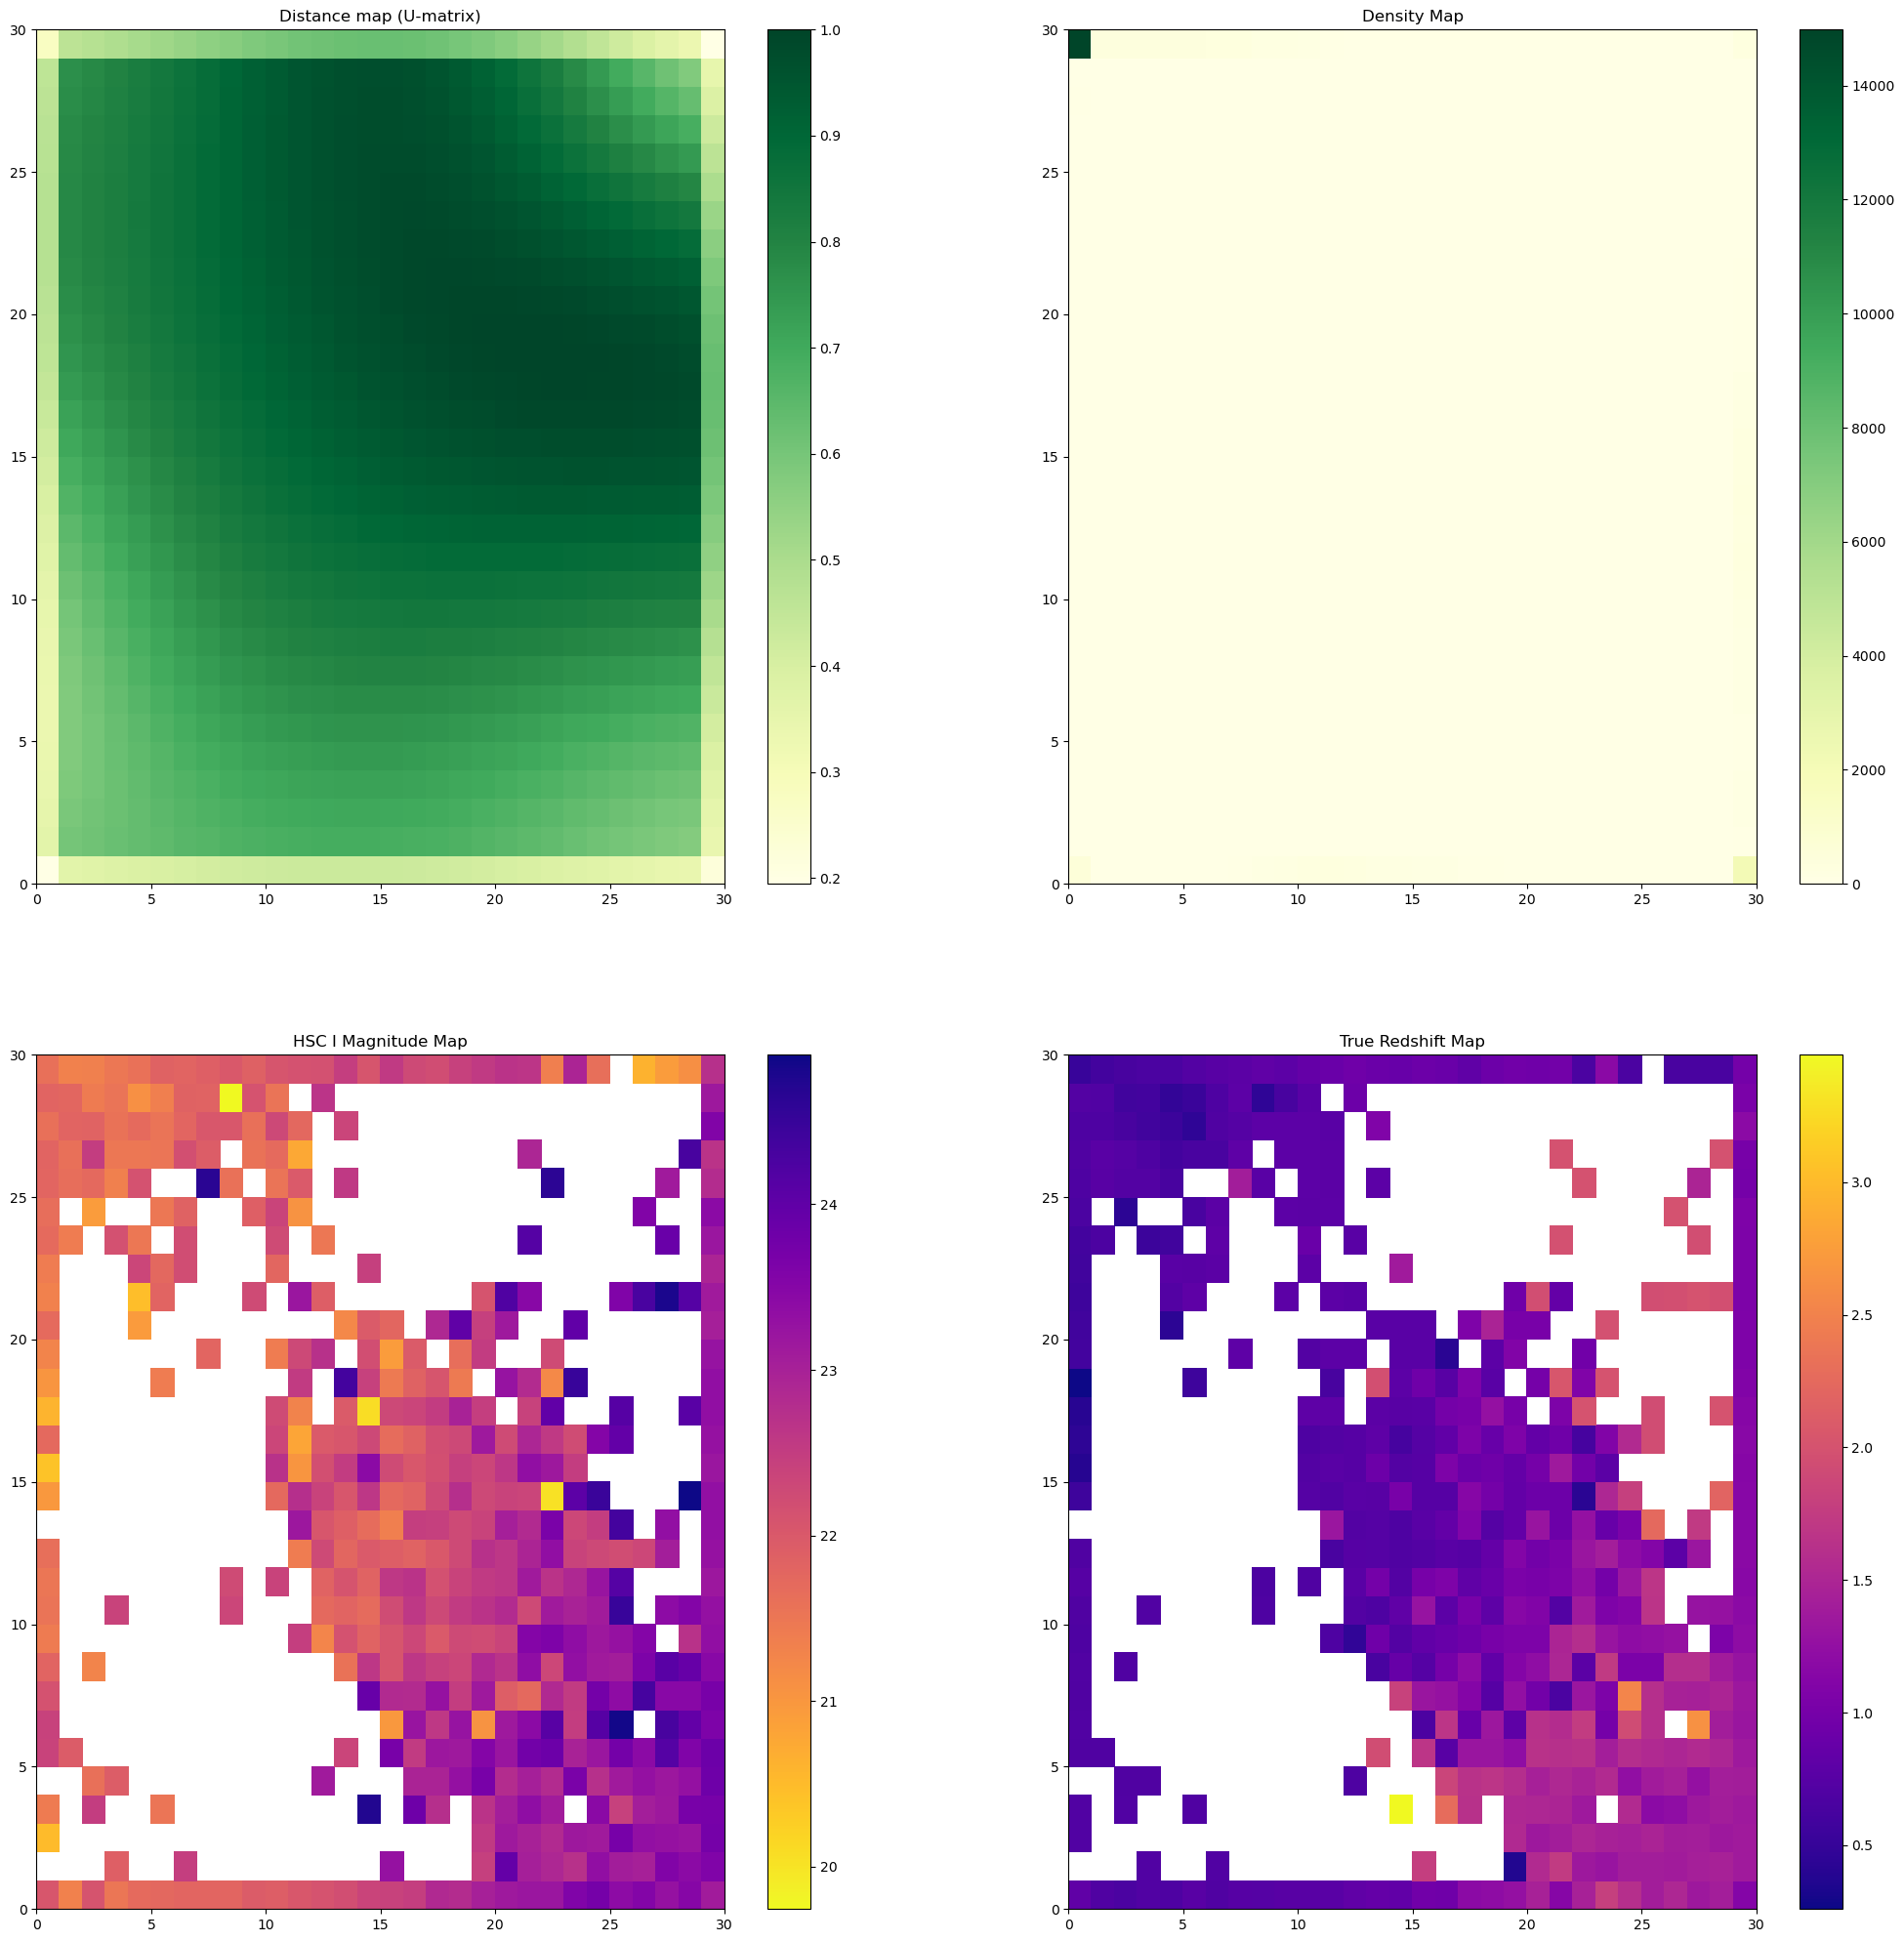

Finish traininging SOM.
Start making diagrams...
Finish collecting data for density map.
Finish collecting data for magnitude map.
[30, 30, 0.7]
Topological error: 0.0052218441532190145
Quantization error: 0.3974586366161894
29683.0


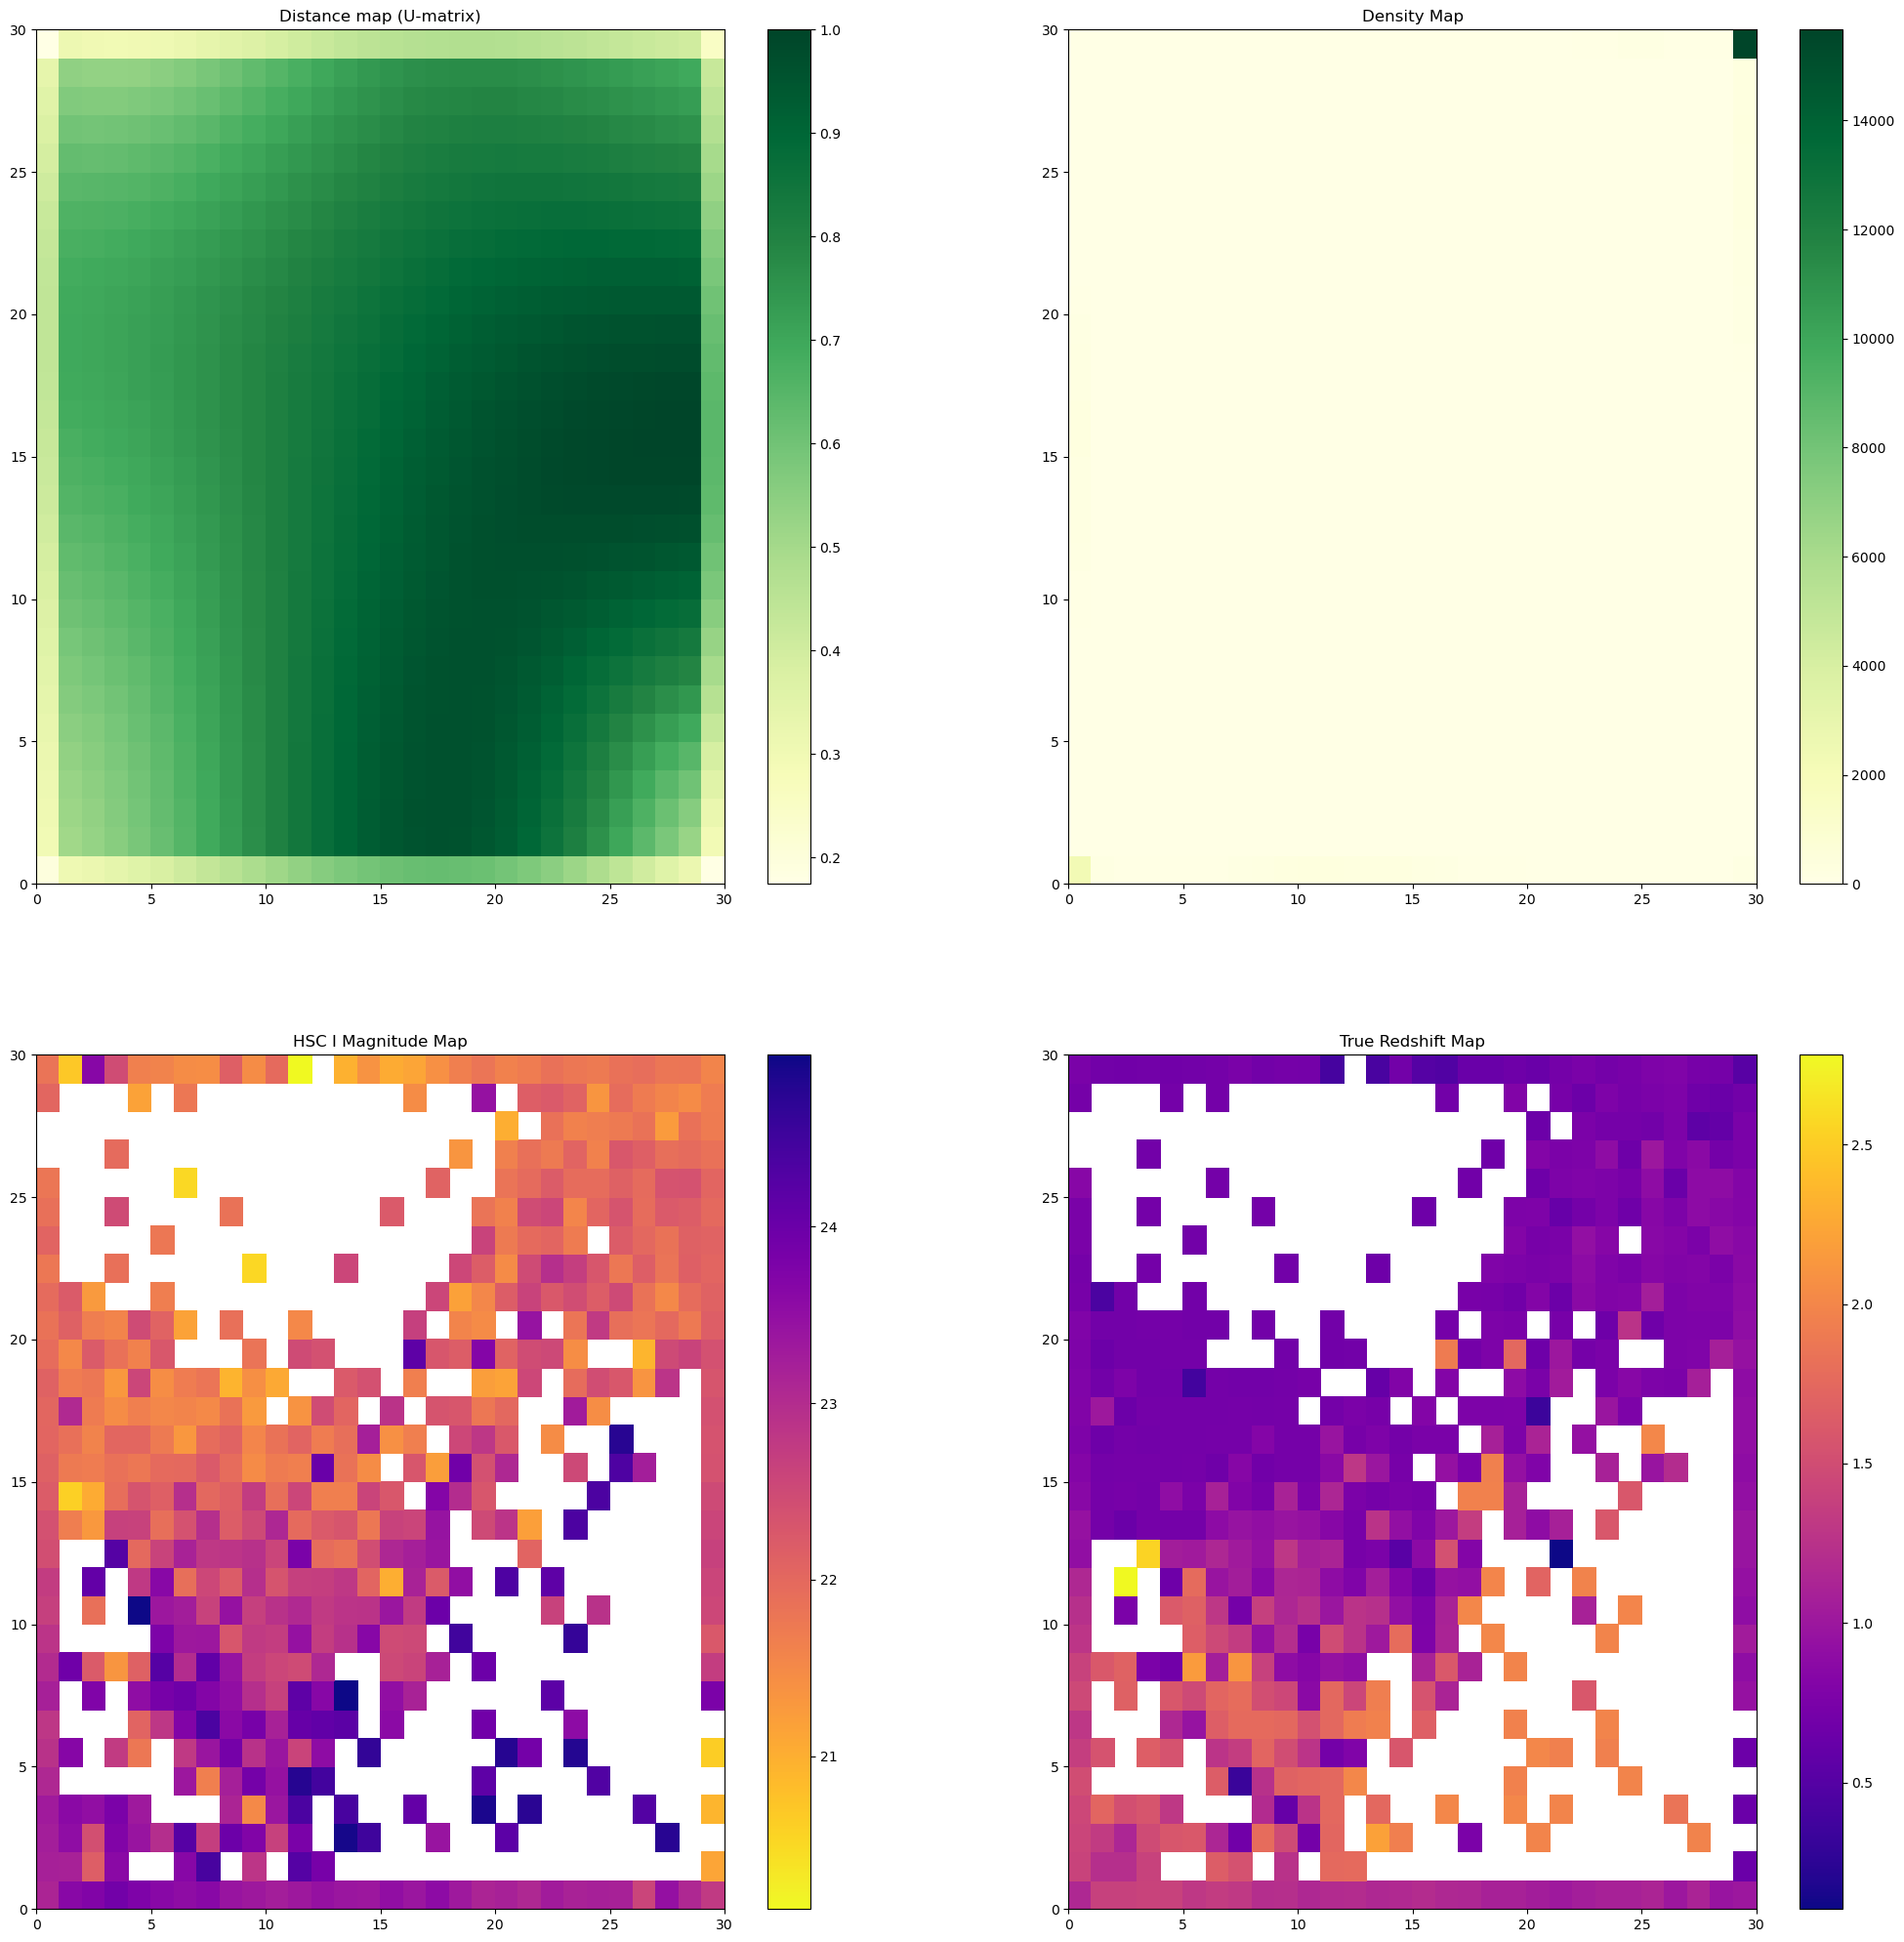

Finish traininging SOM.
Start making diagrams...
Finish collecting data for density map.
Finish collecting data for magnitude map.
[30, 30, 0.8]
Topological error: 0.0074790284000943305
Quantization error: 0.39837244169099173
29683.0


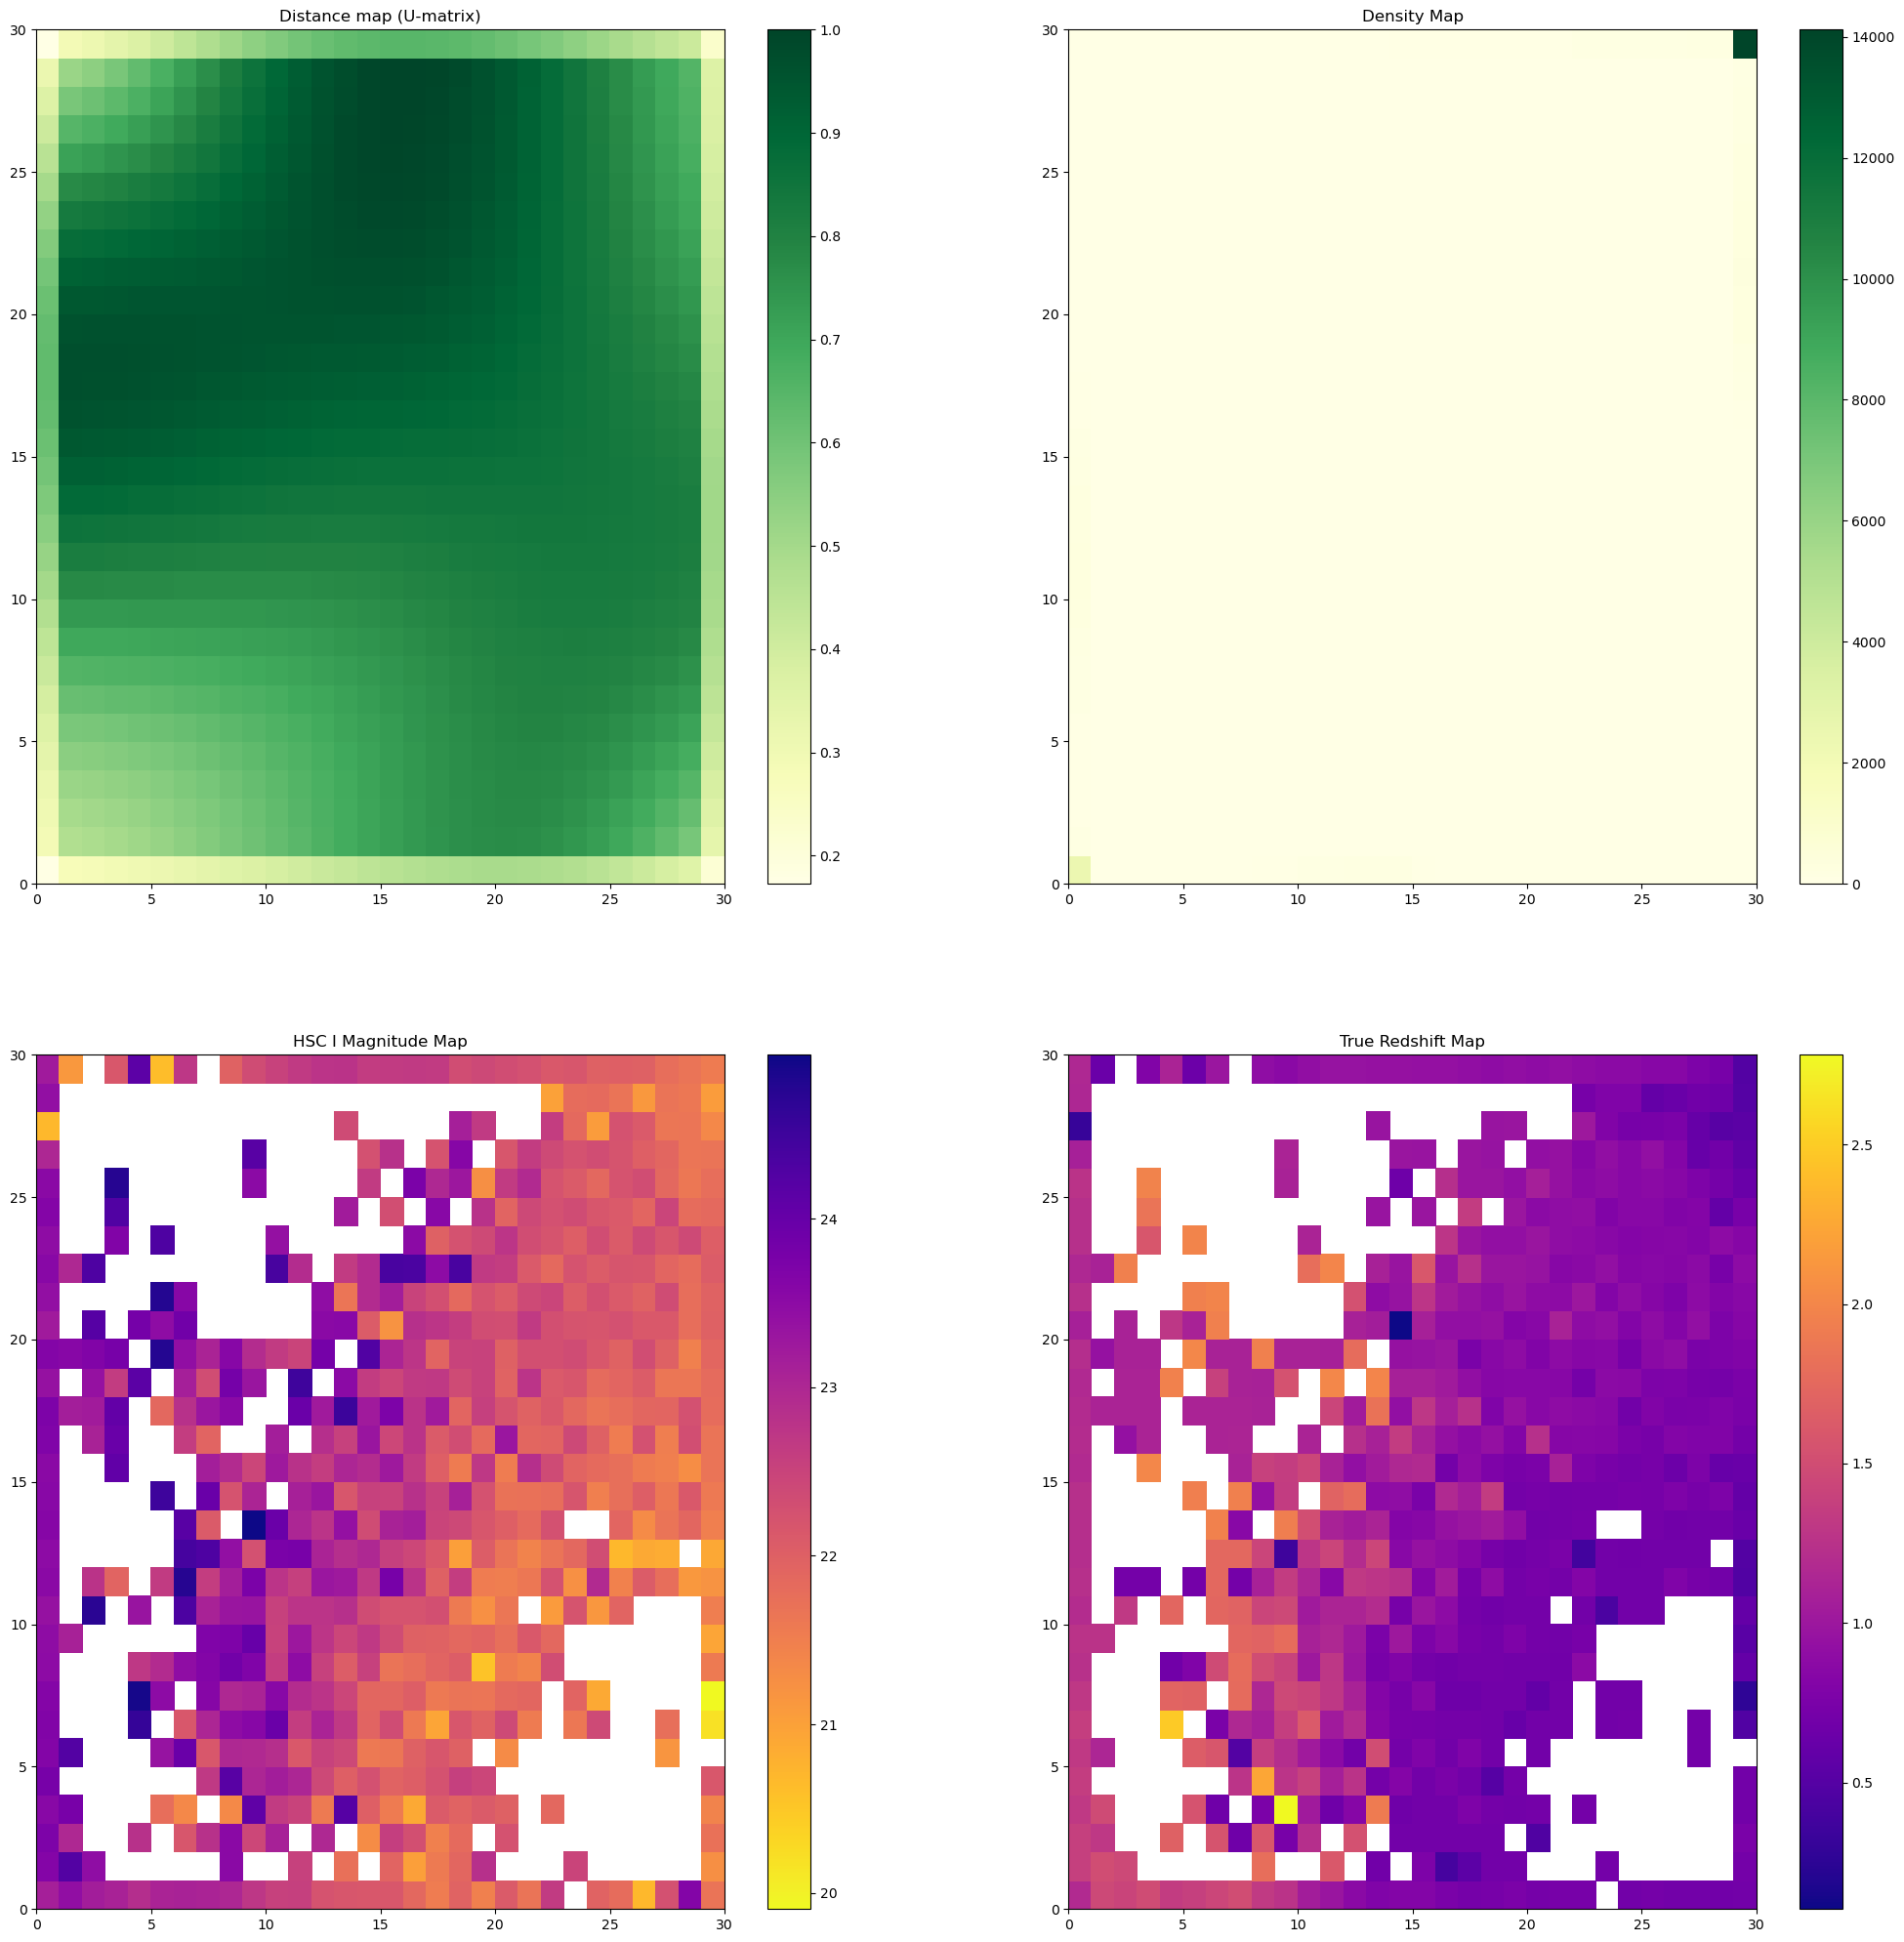

Finish traininging SOM.
Start making diagrams...
Finish collecting data for density map.
Finish collecting data for magnitude map.
[30, 30, 0.9]
Topological error: 0.008220193376680255
Quantization error: 0.40152589142979295
29683.0


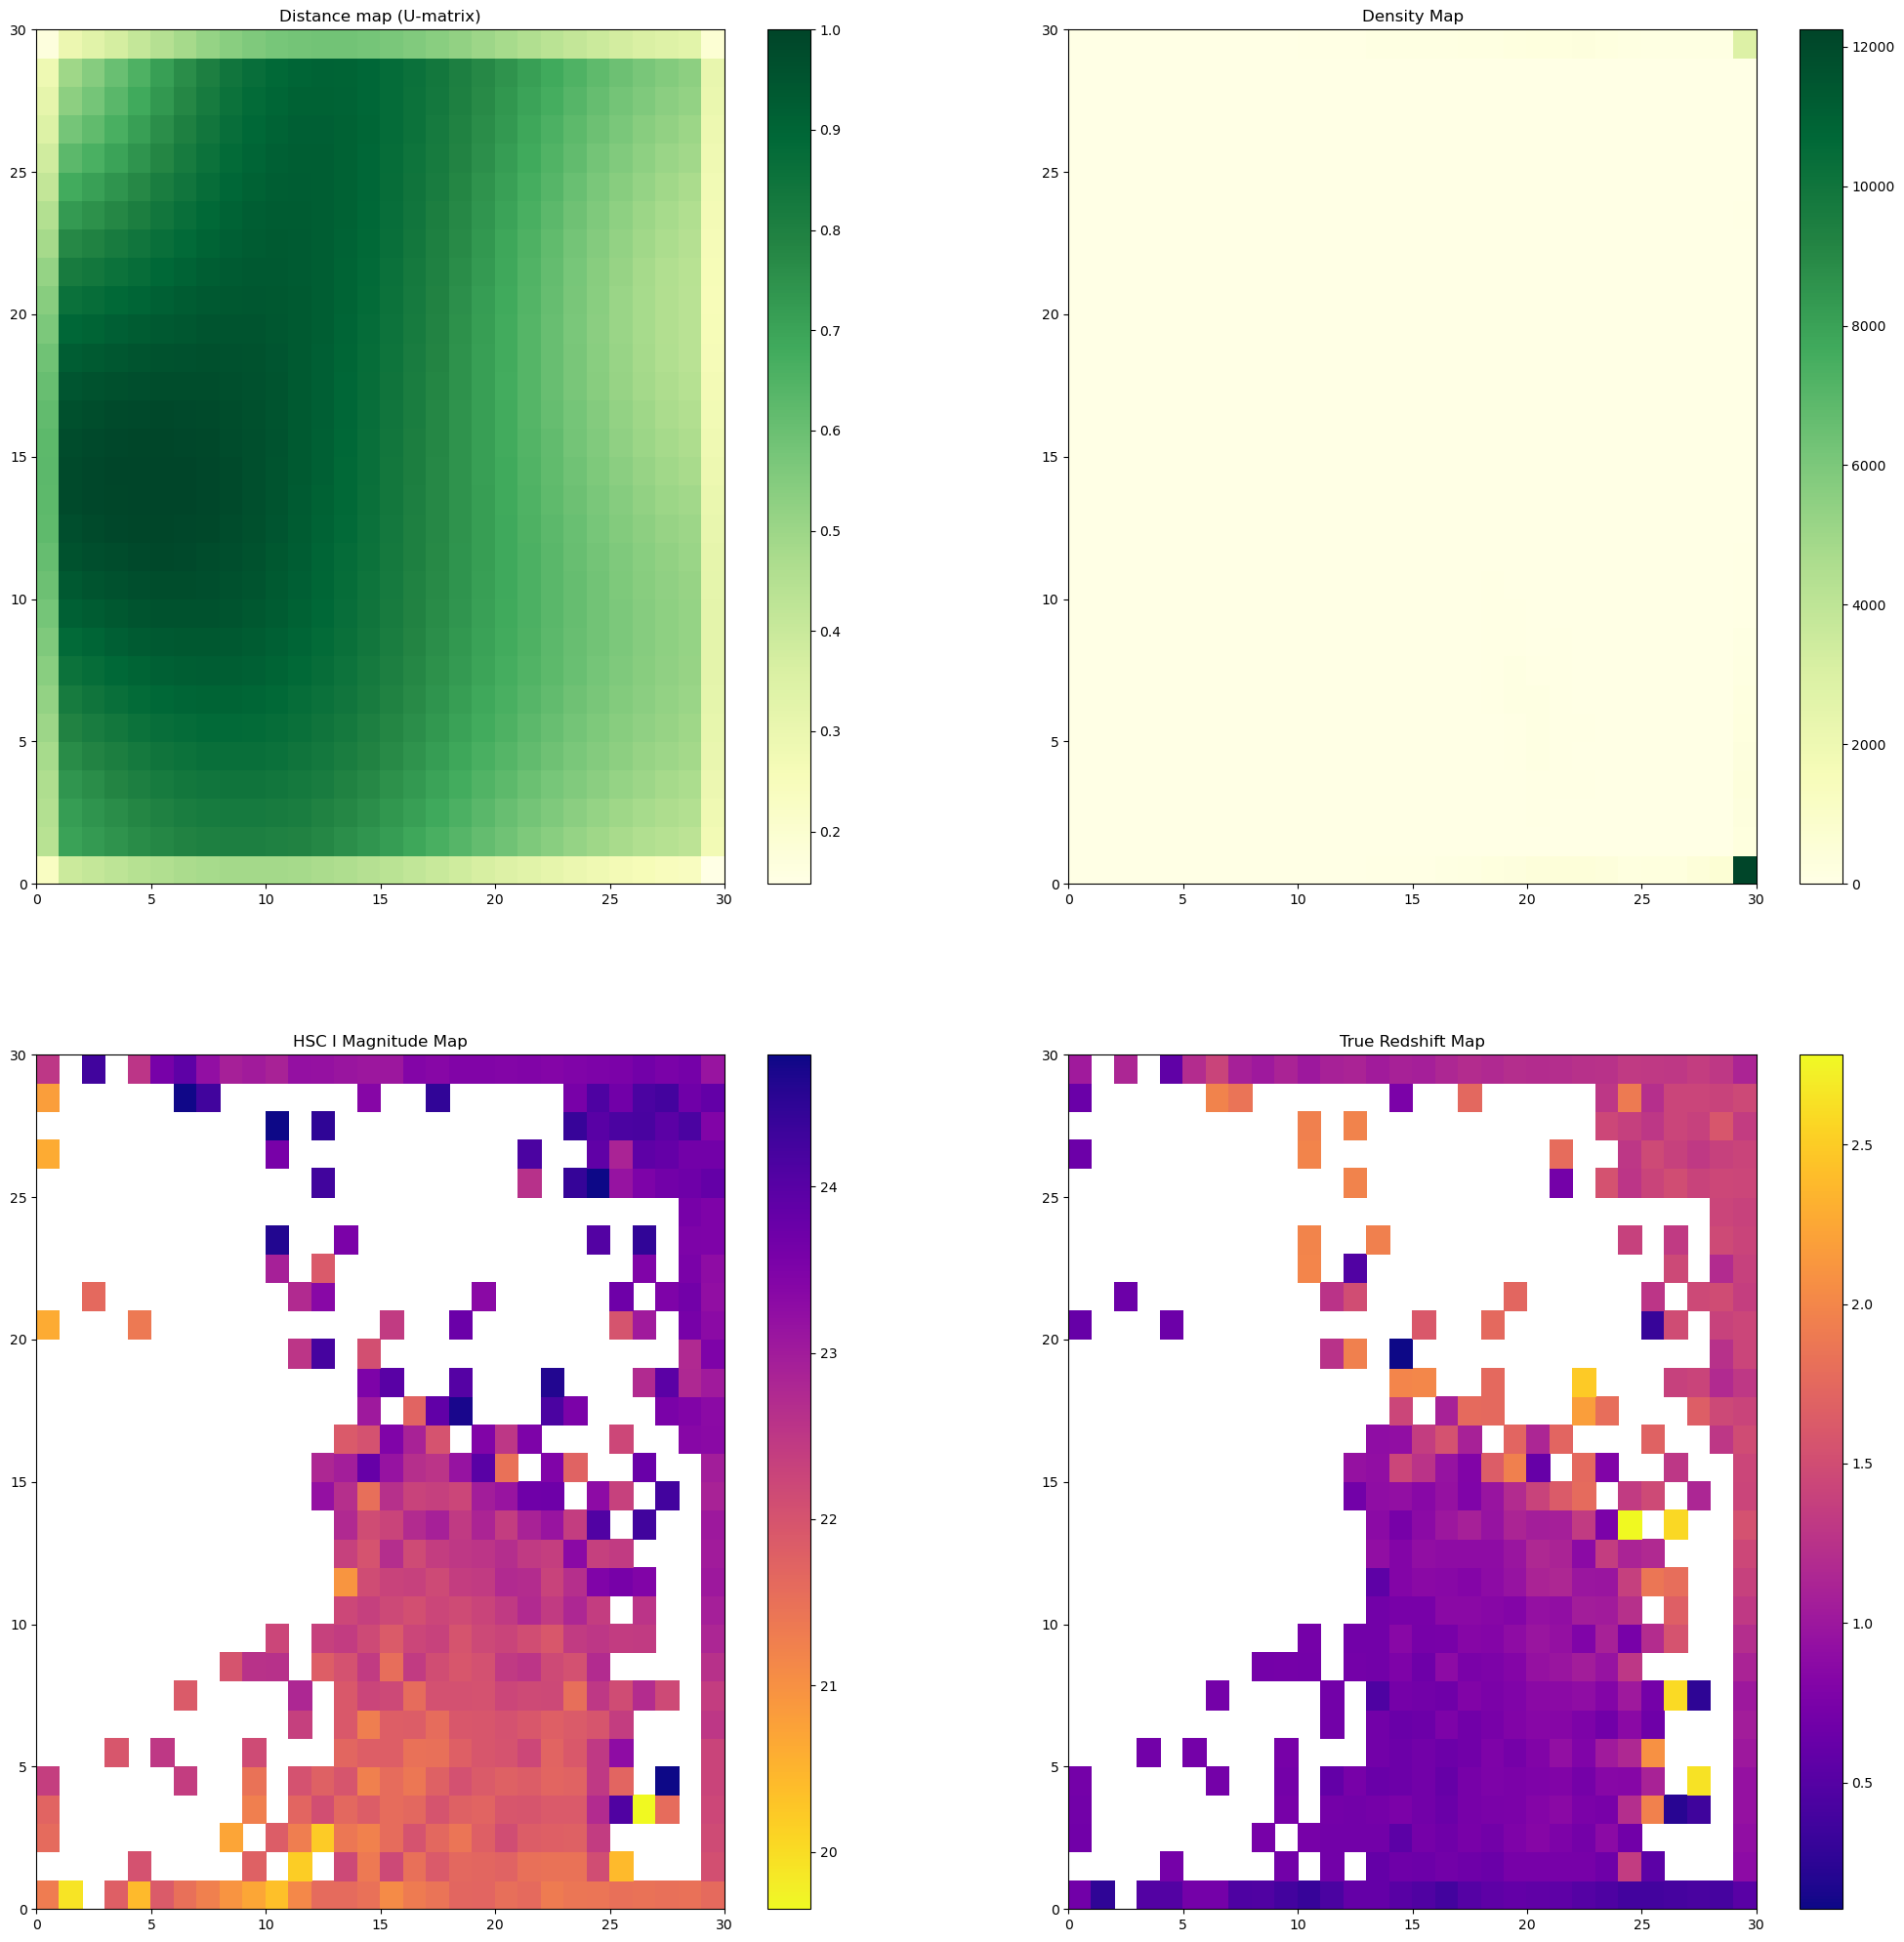

Finish traininging SOM.
Start making diagrams...
Finish collecting data for density map.
Finish collecting data for magnitude map.
[30, 30, 1.0]
Topological error: 0.0058282518613347704
Quantization error: 0.411000652130502
29683.0


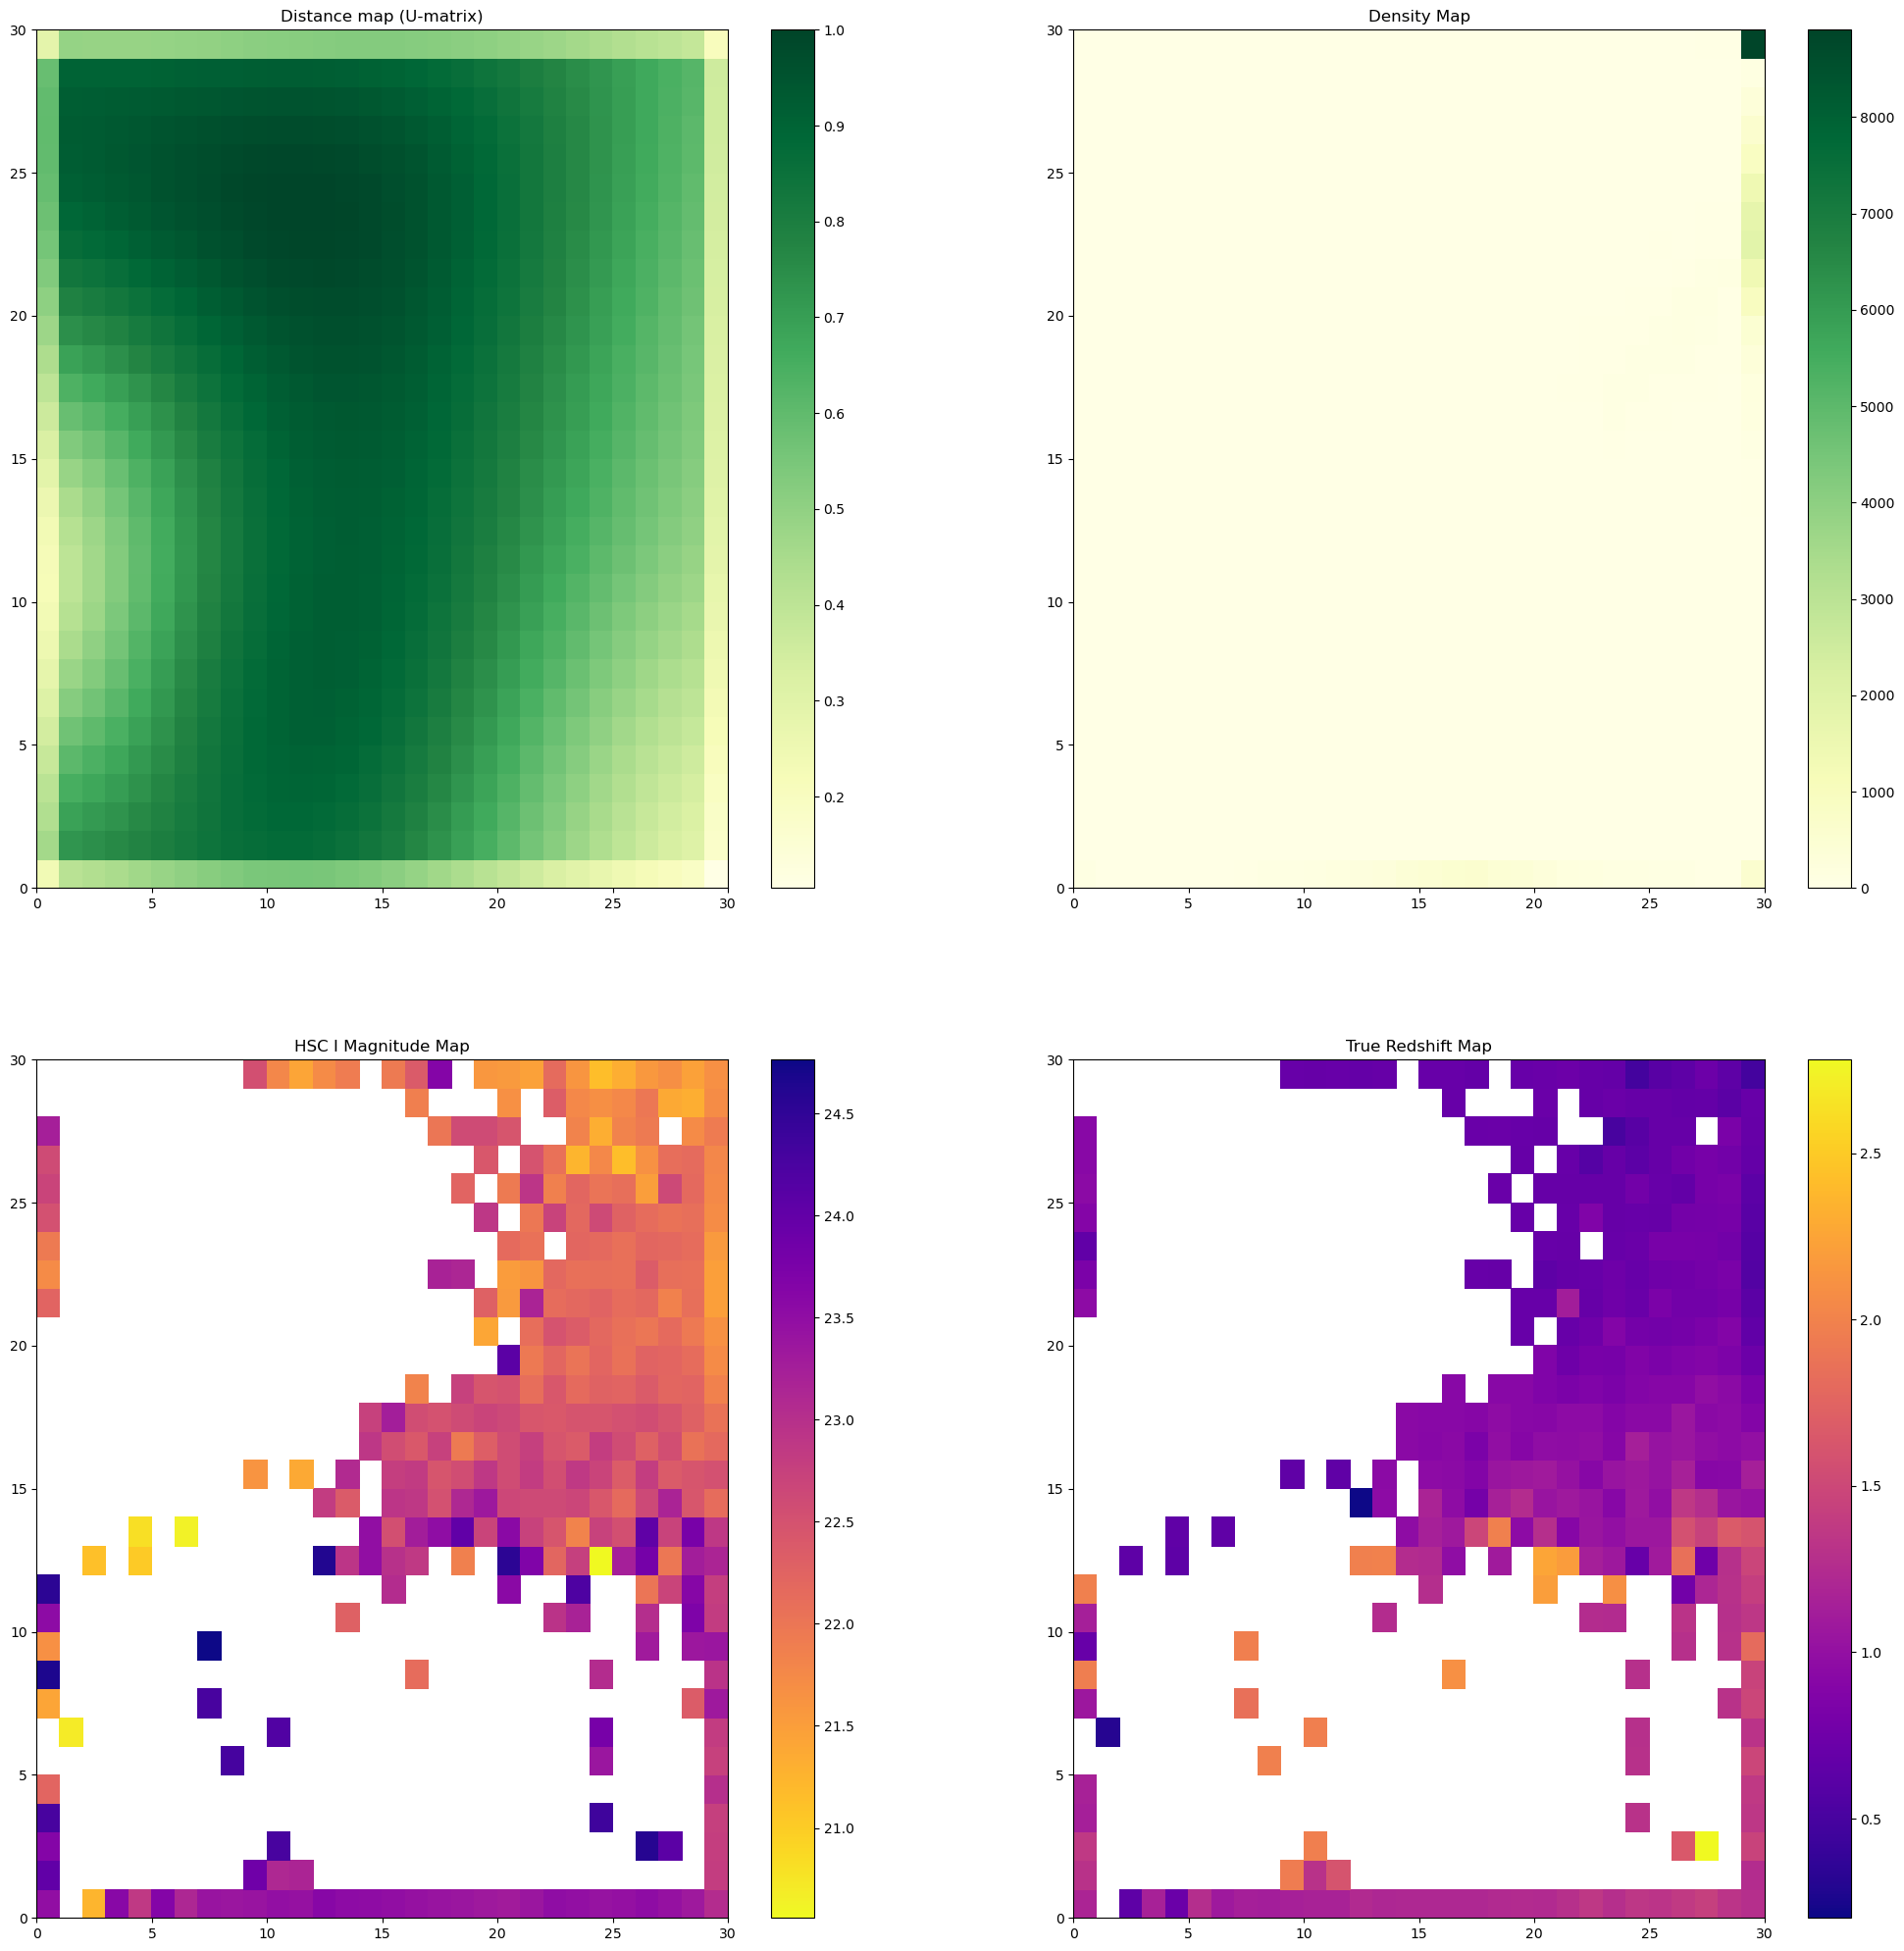

Finish traininging SOM.
Start making diagrams...
Finish collecting data for density map.
Finish collecting data for magnitude map.
[30, 30, 1.1]
Topological error: 0.016271940167772798
Quantization error: 0.429494155857808
29683.0


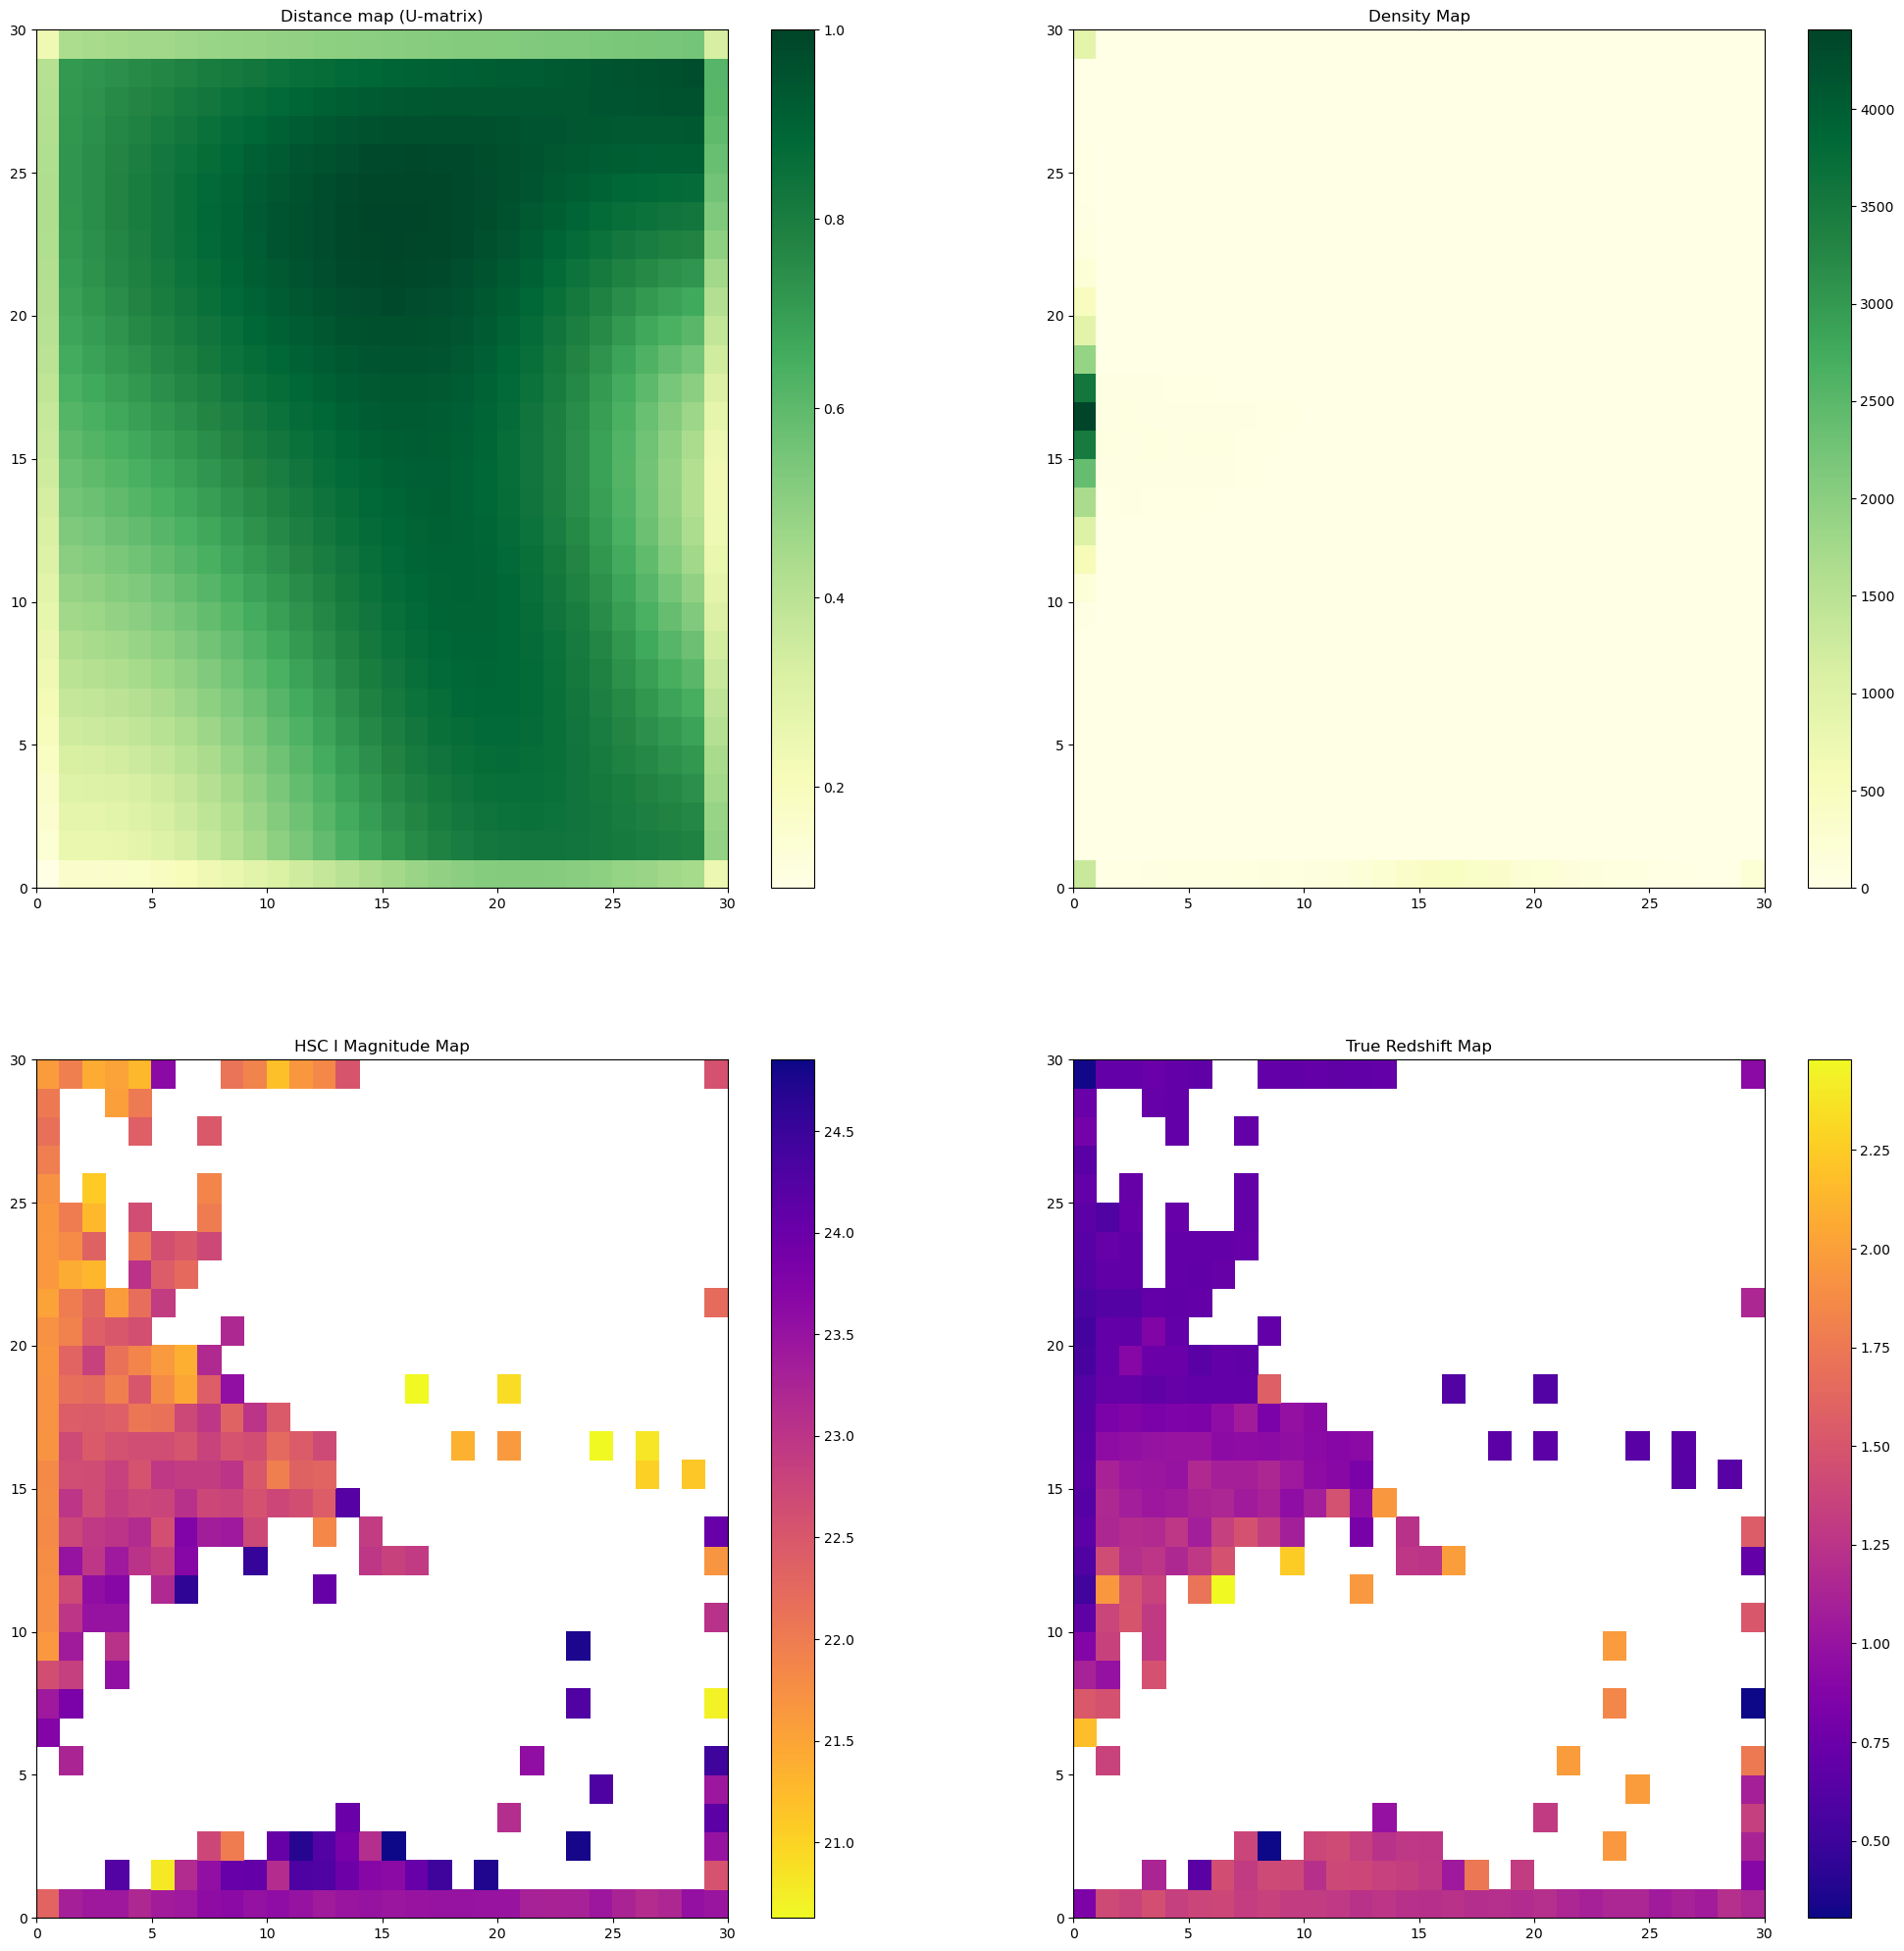

Finish traininging SOM.
Start making diagrams...
Finish collecting data for density map.
Finish collecting data for magnitude map.
[30, 30, 1.2]
Topological error: 0.004851261664926052
Quantization error: 0.42228375907104554
29683.0


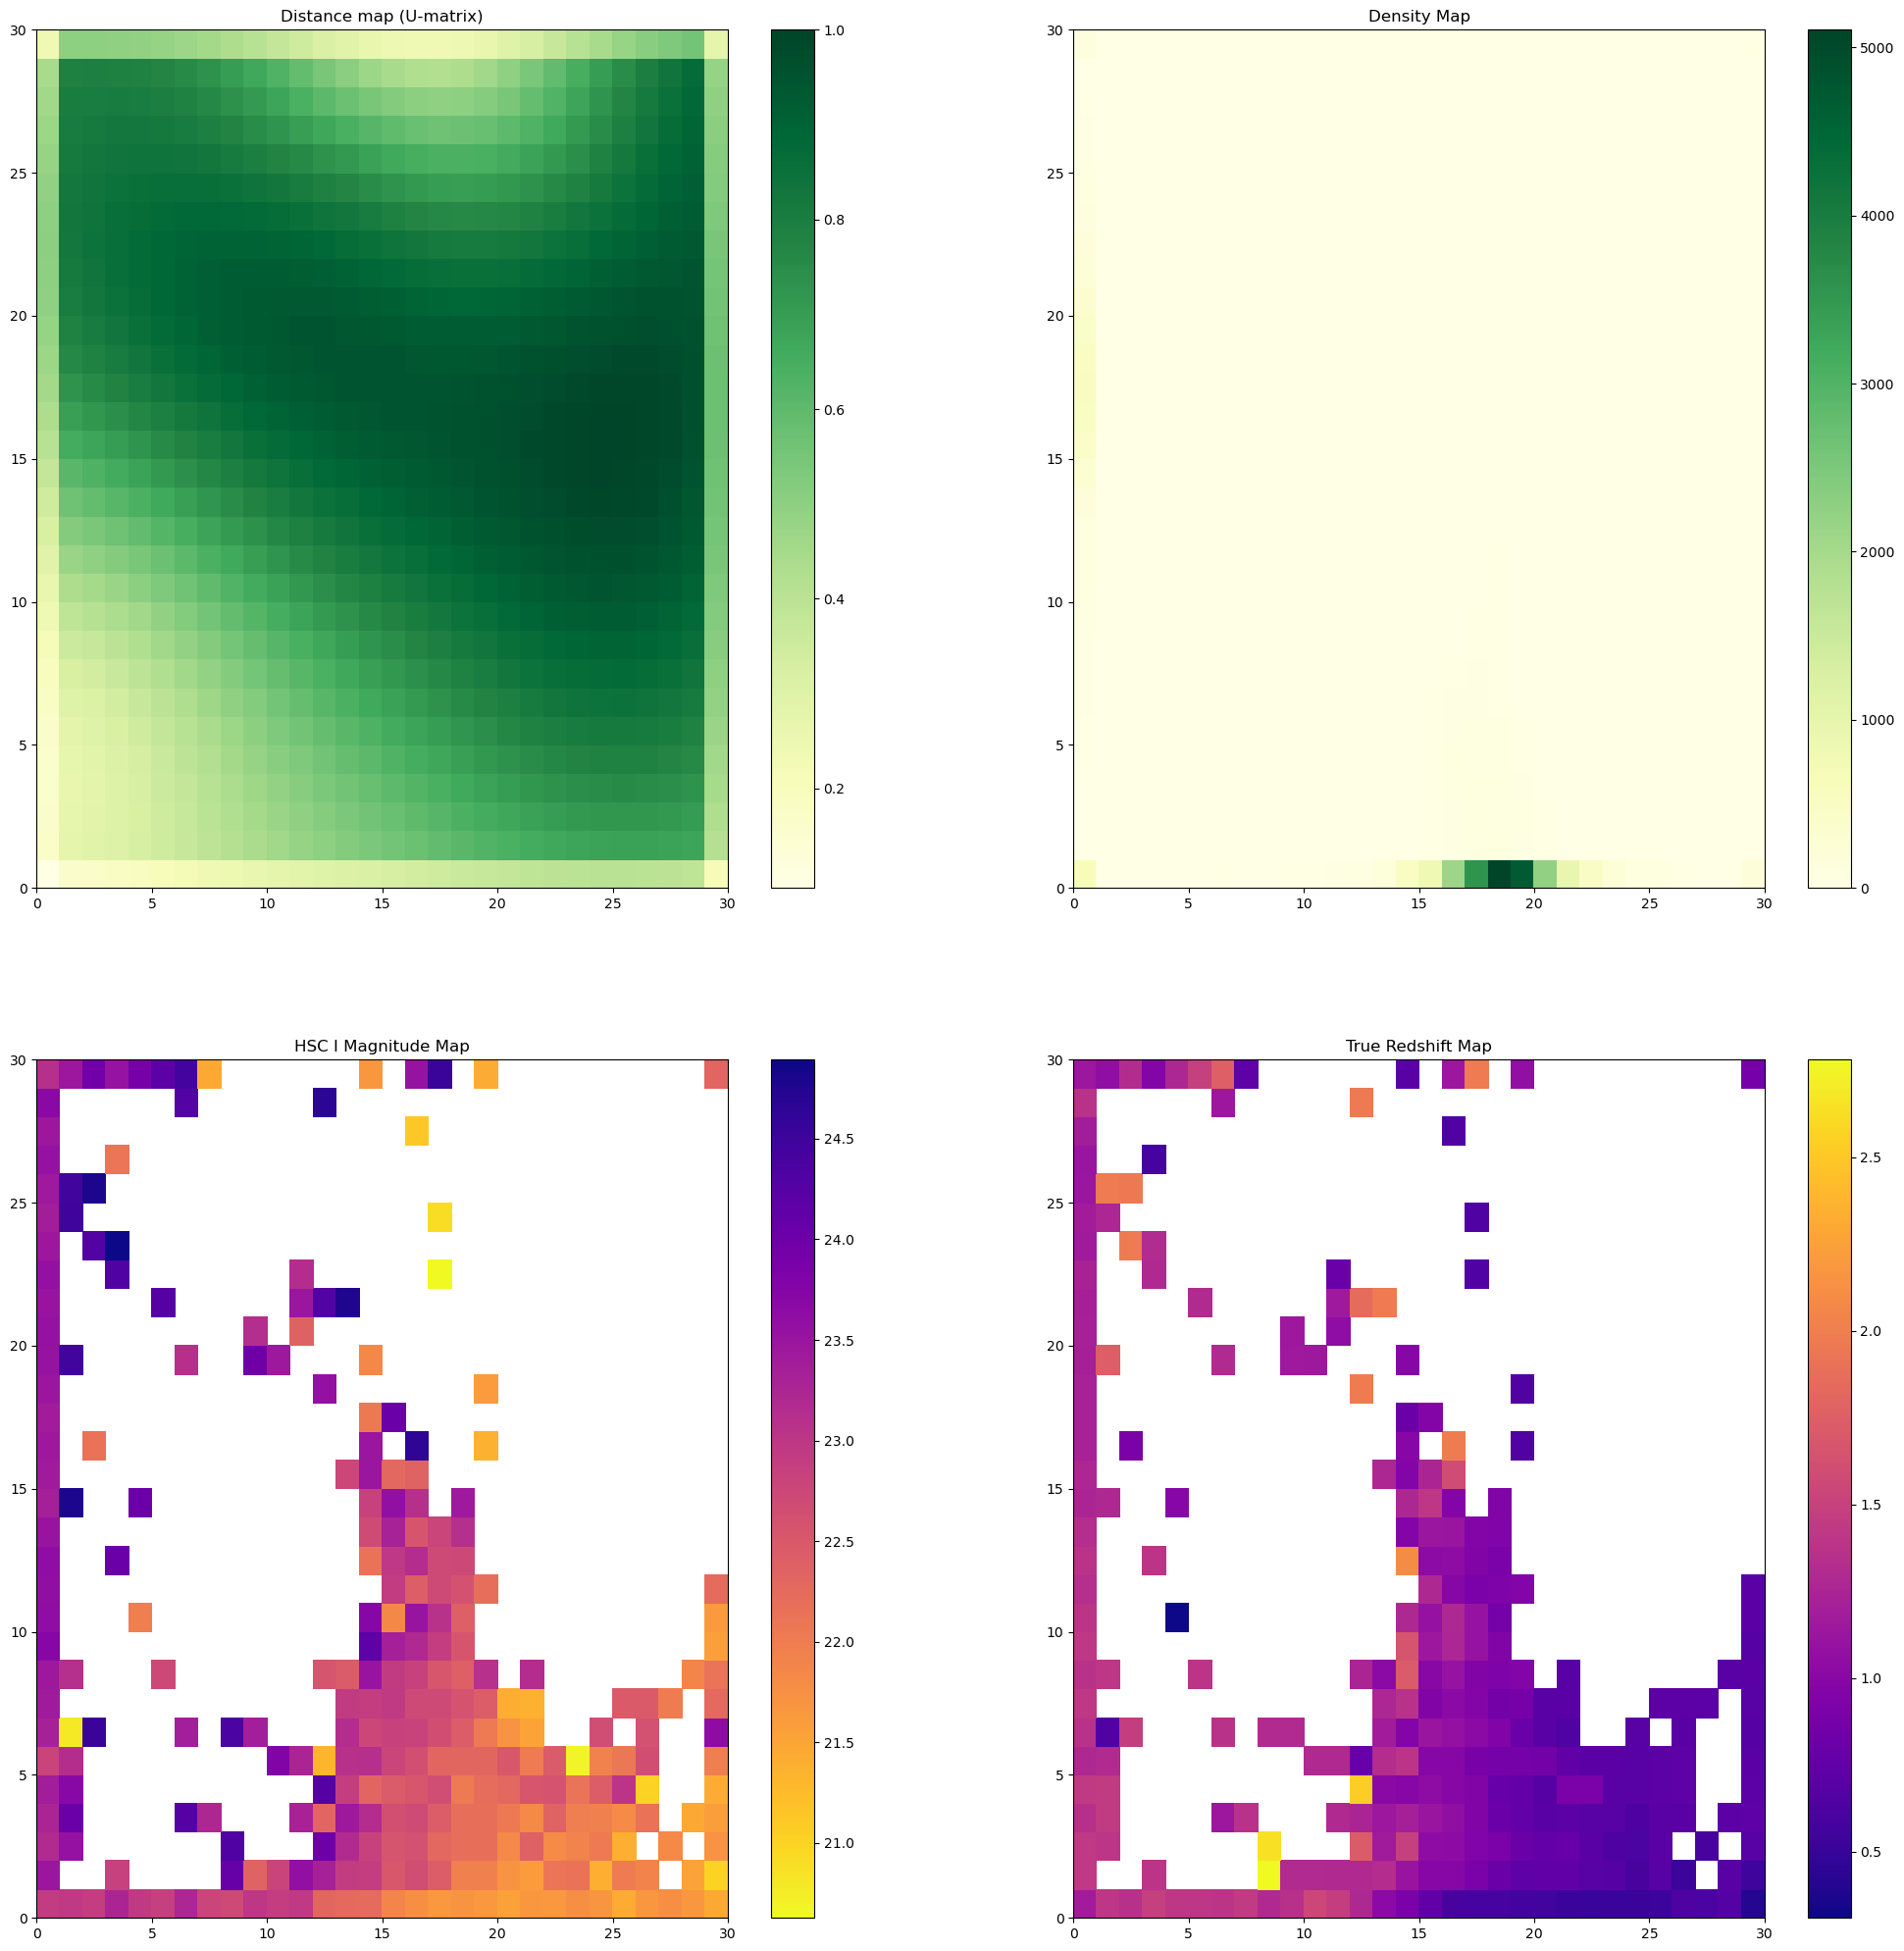

Finish traininging SOM.
Start making diagrams...
Finish collecting data for density map.
Finish collecting data for magnitude map.
[30, 30, 1.3]
Topological error: 0.0042111646396927535
Quantization error: 0.4205844107535627
29683.0


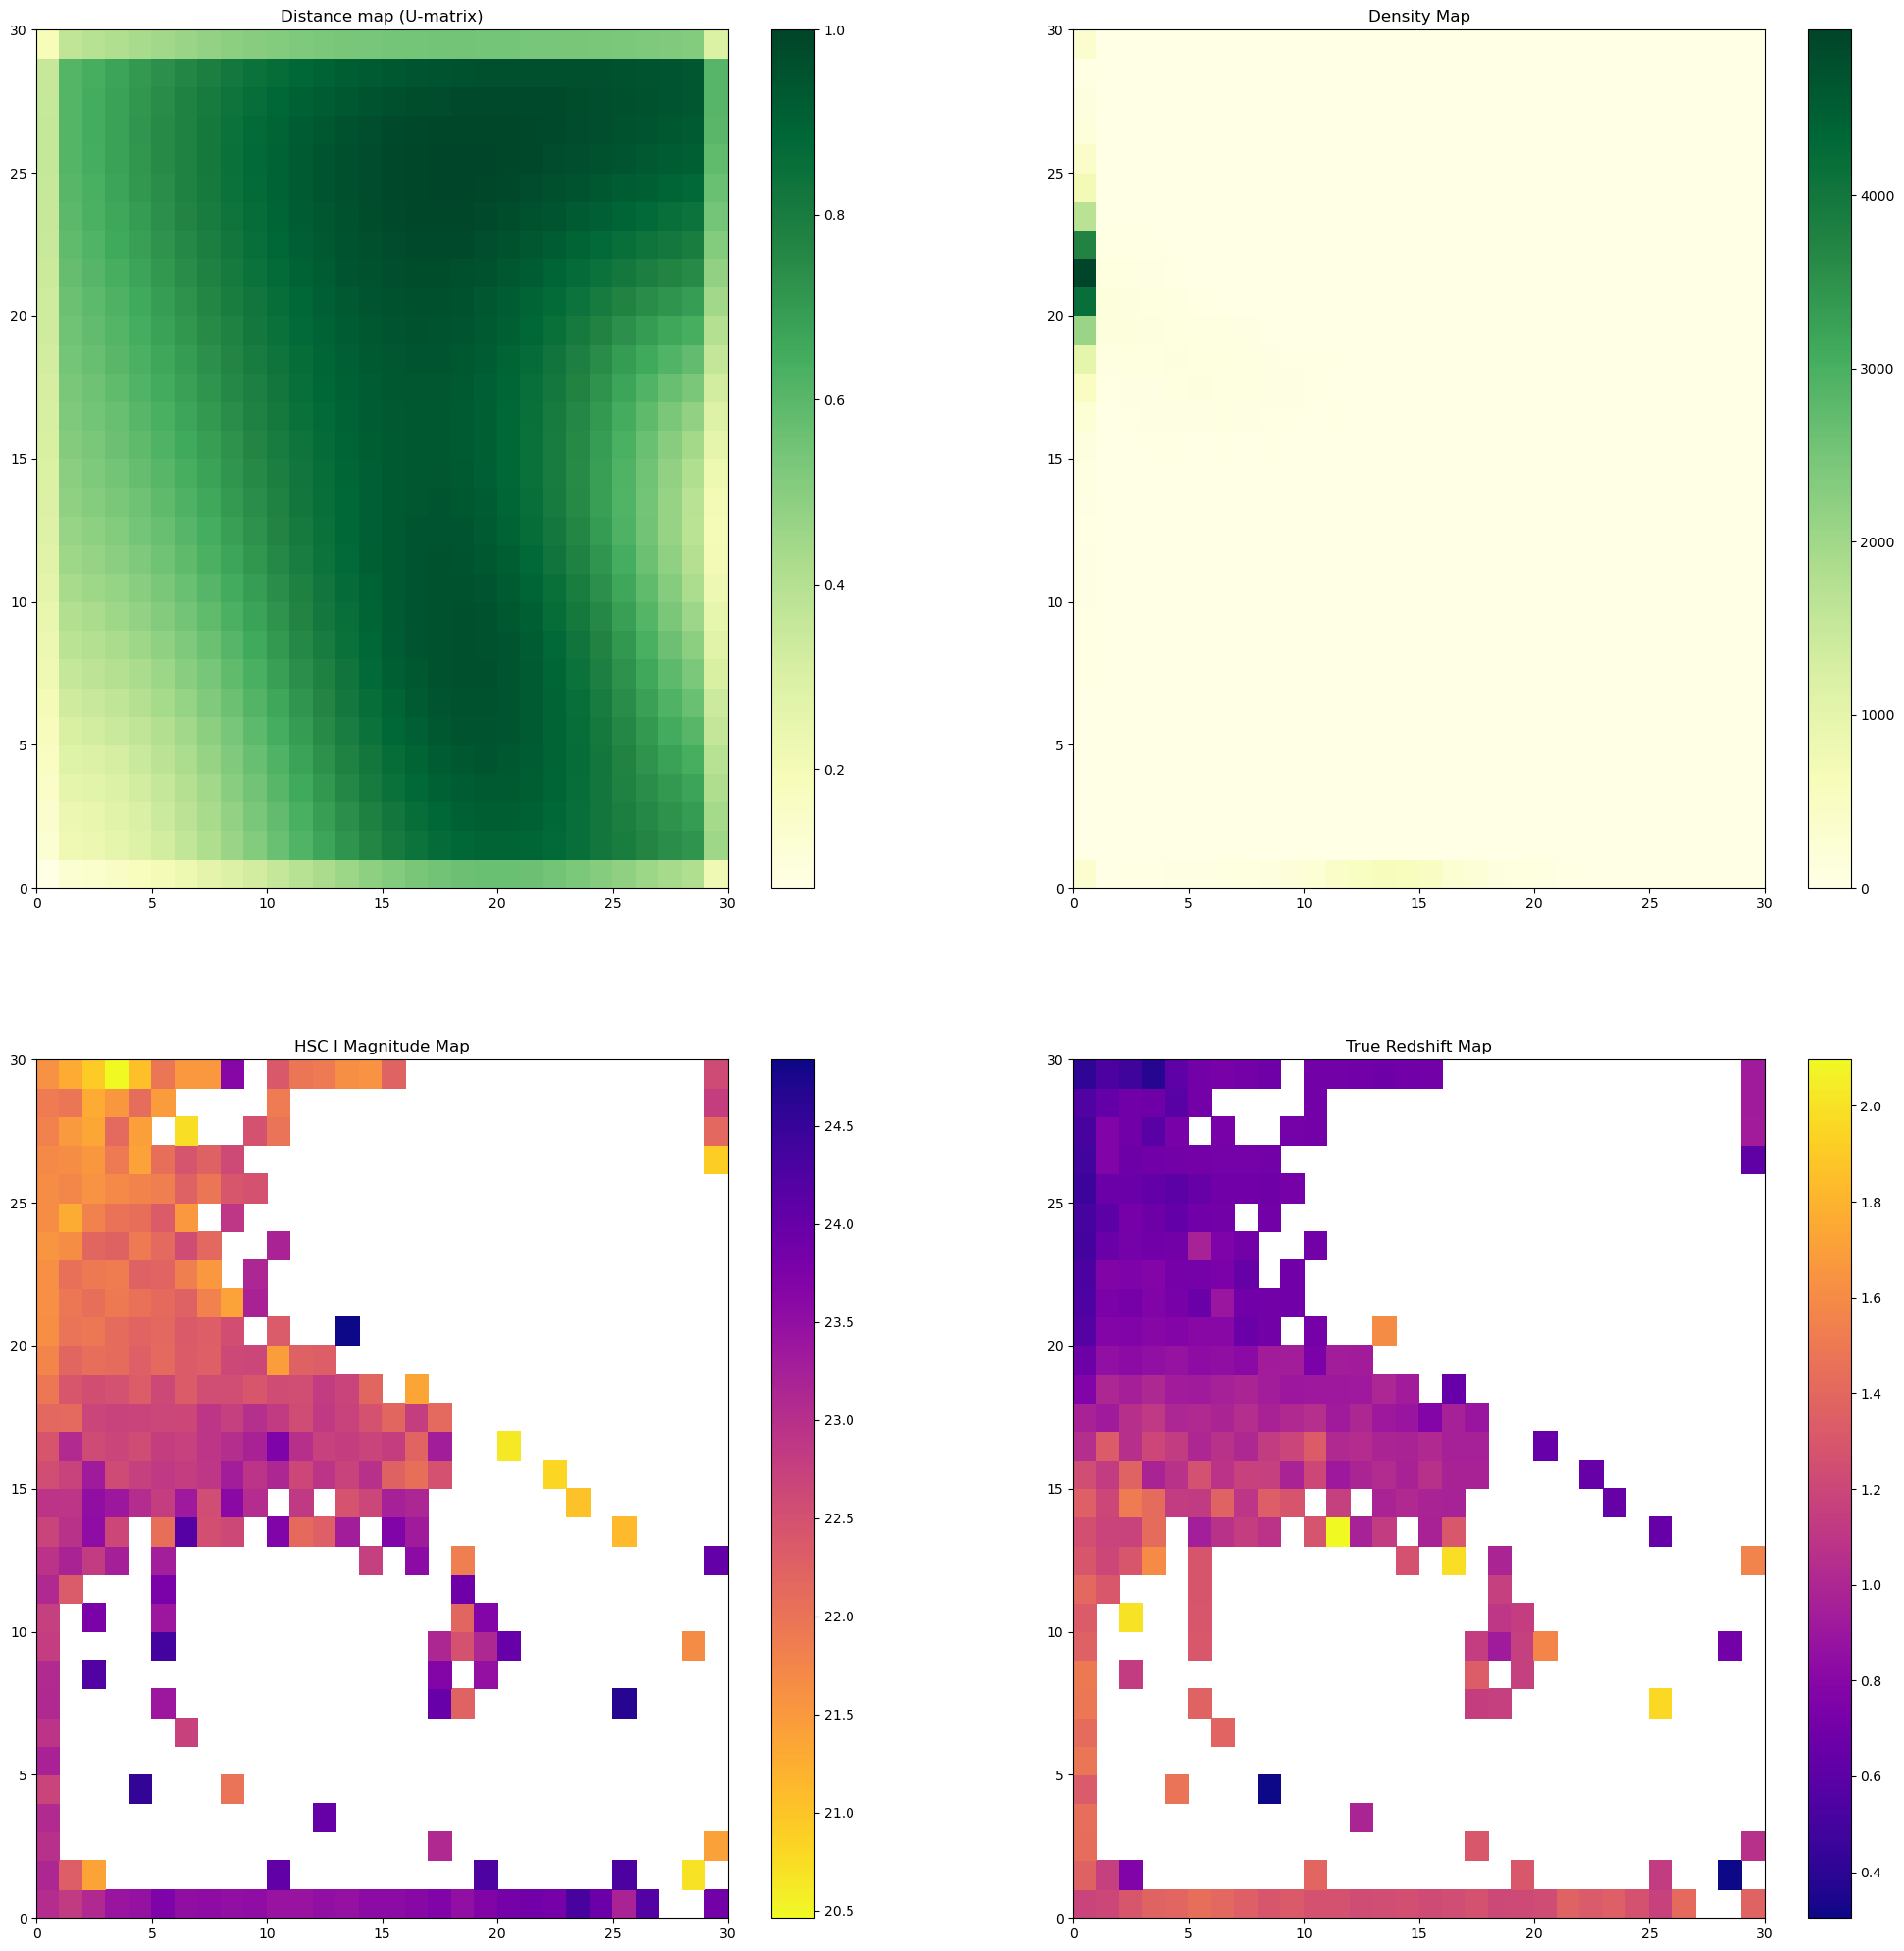

Finish traininging SOM.
Start making diagrams...
Finish collecting data for density map.
Finish collecting data for magnitude map.
[30, 30, 1.4]
Topological error: 0.005423980055924266
Quantization error: 0.4087628240911363
29683.0


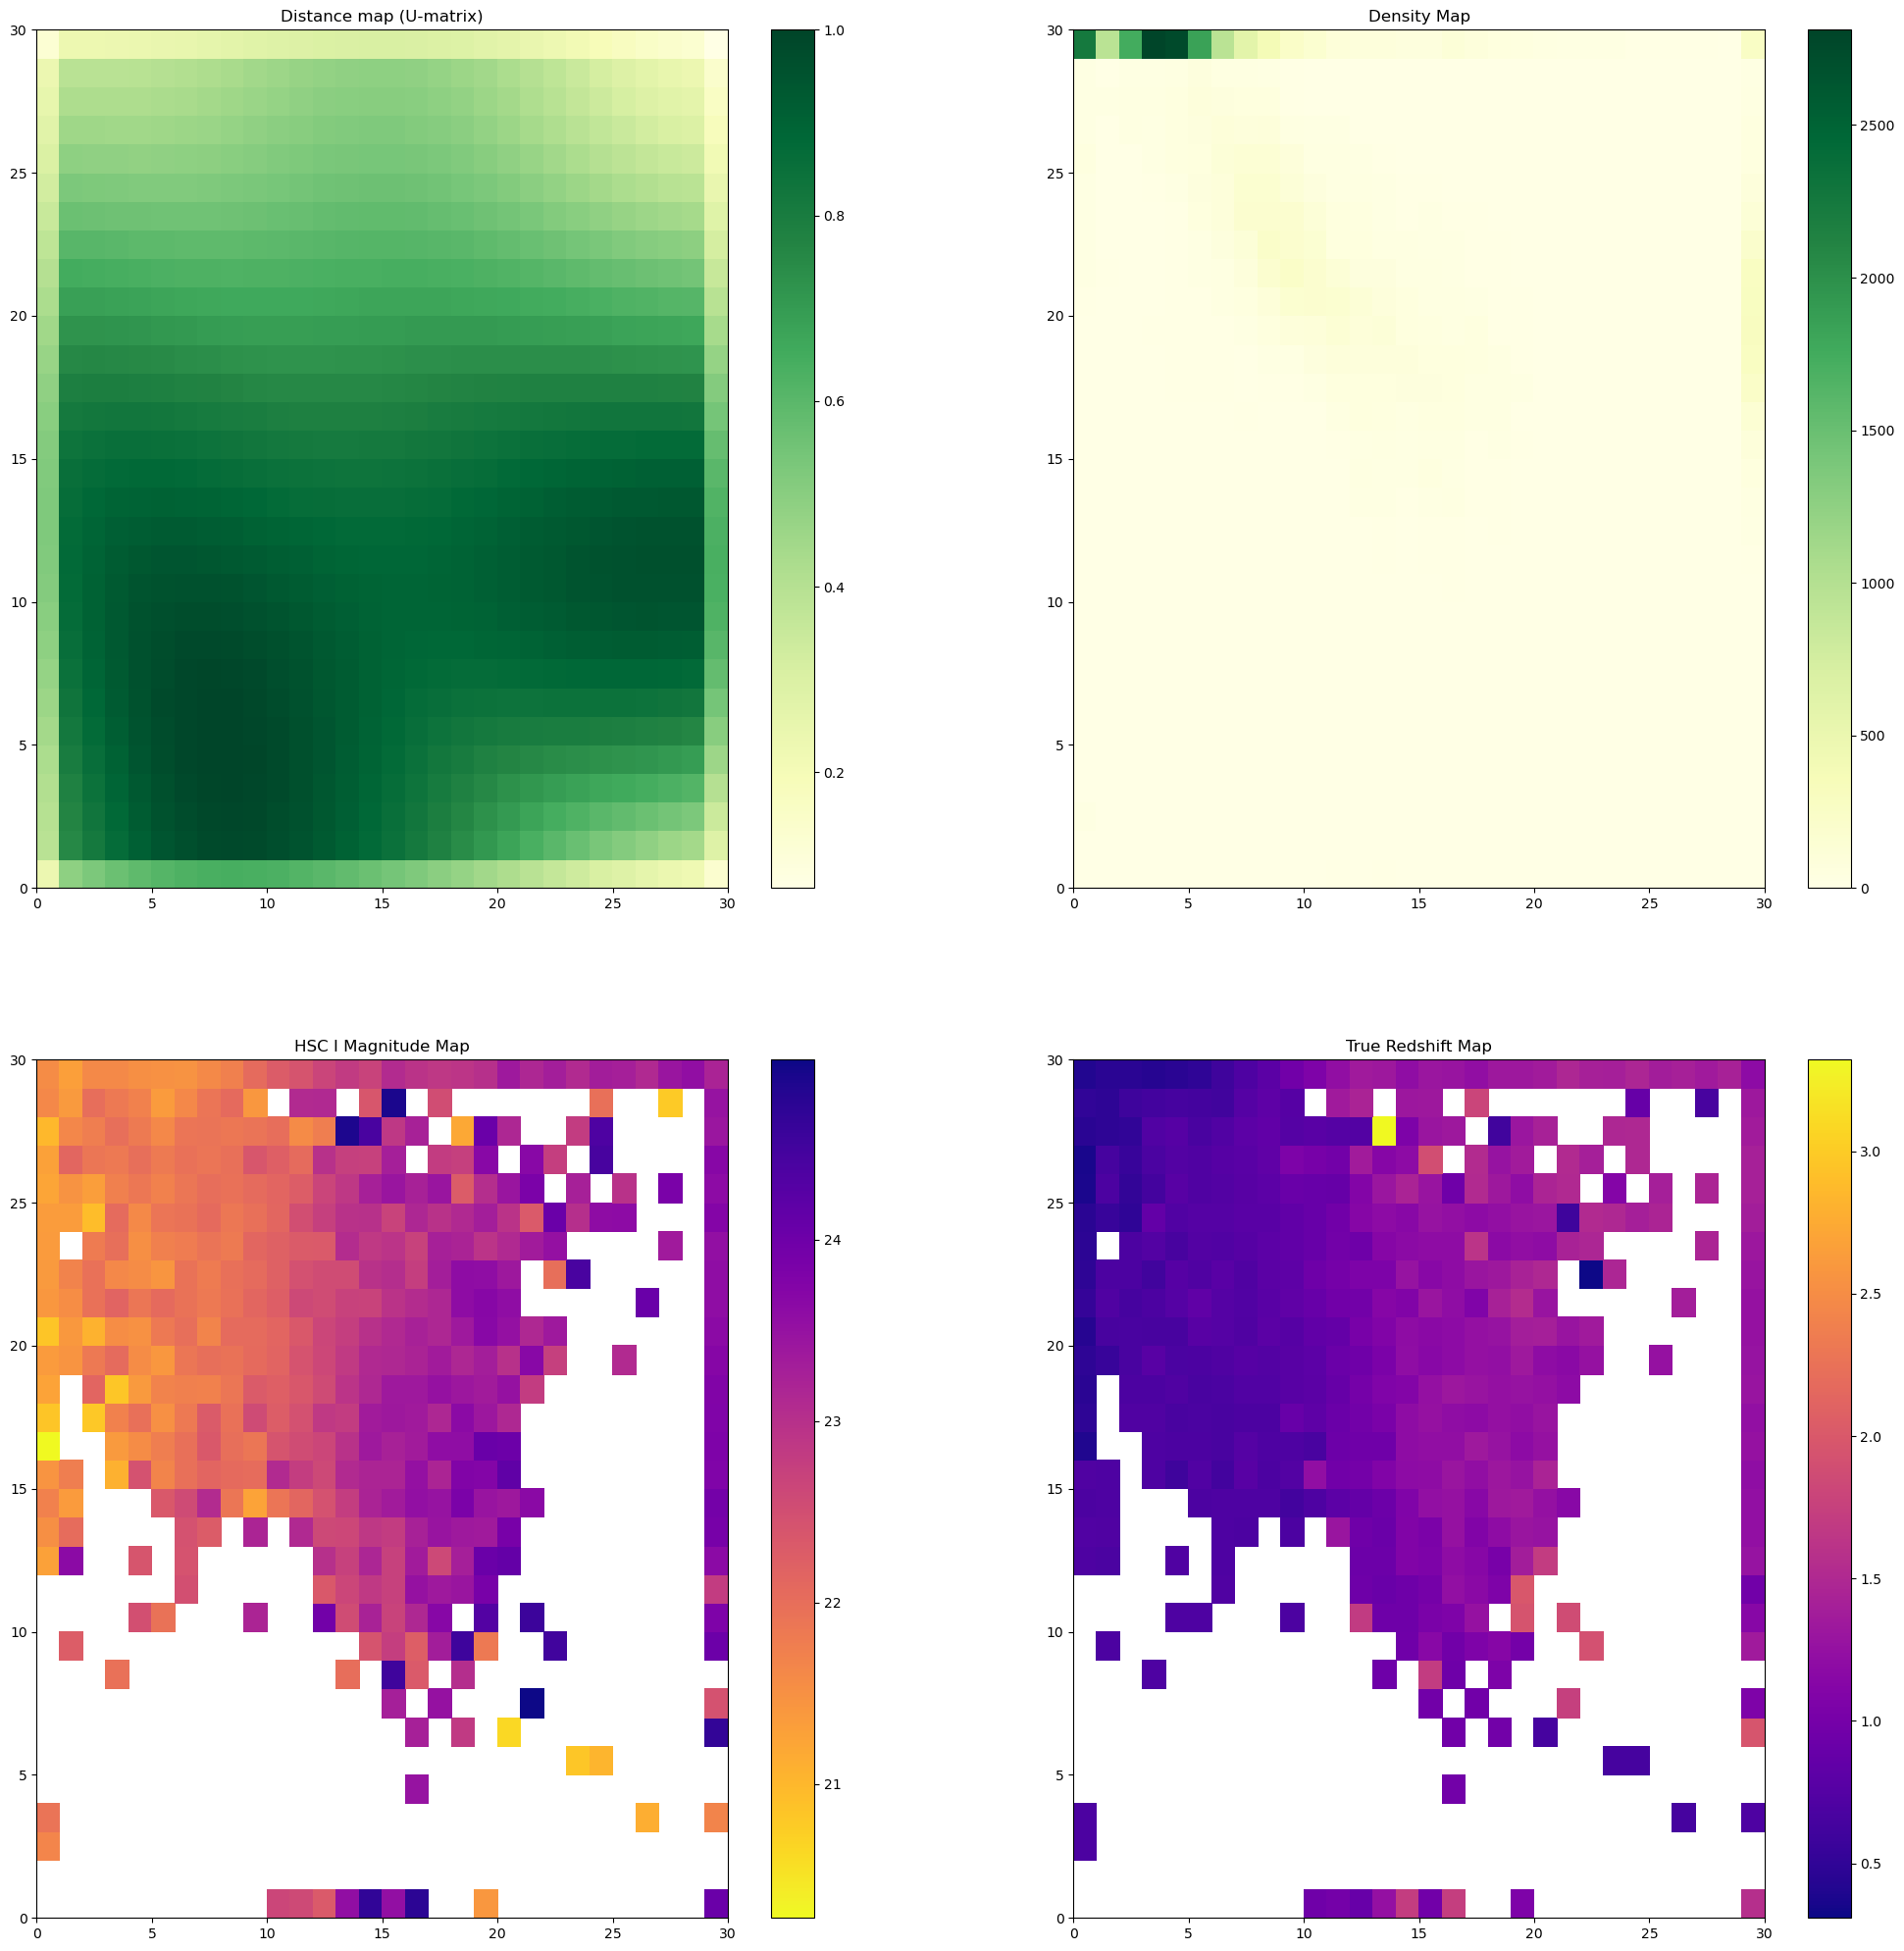

Finish traininging SOM.
Start making diagrams...
Finish collecting data for density map.
Finish collecting data for magnitude map.
[30, 30, 1.5]
Topological error: 0.0023245628811104
Quantization error: 0.423004058494742
29683.0


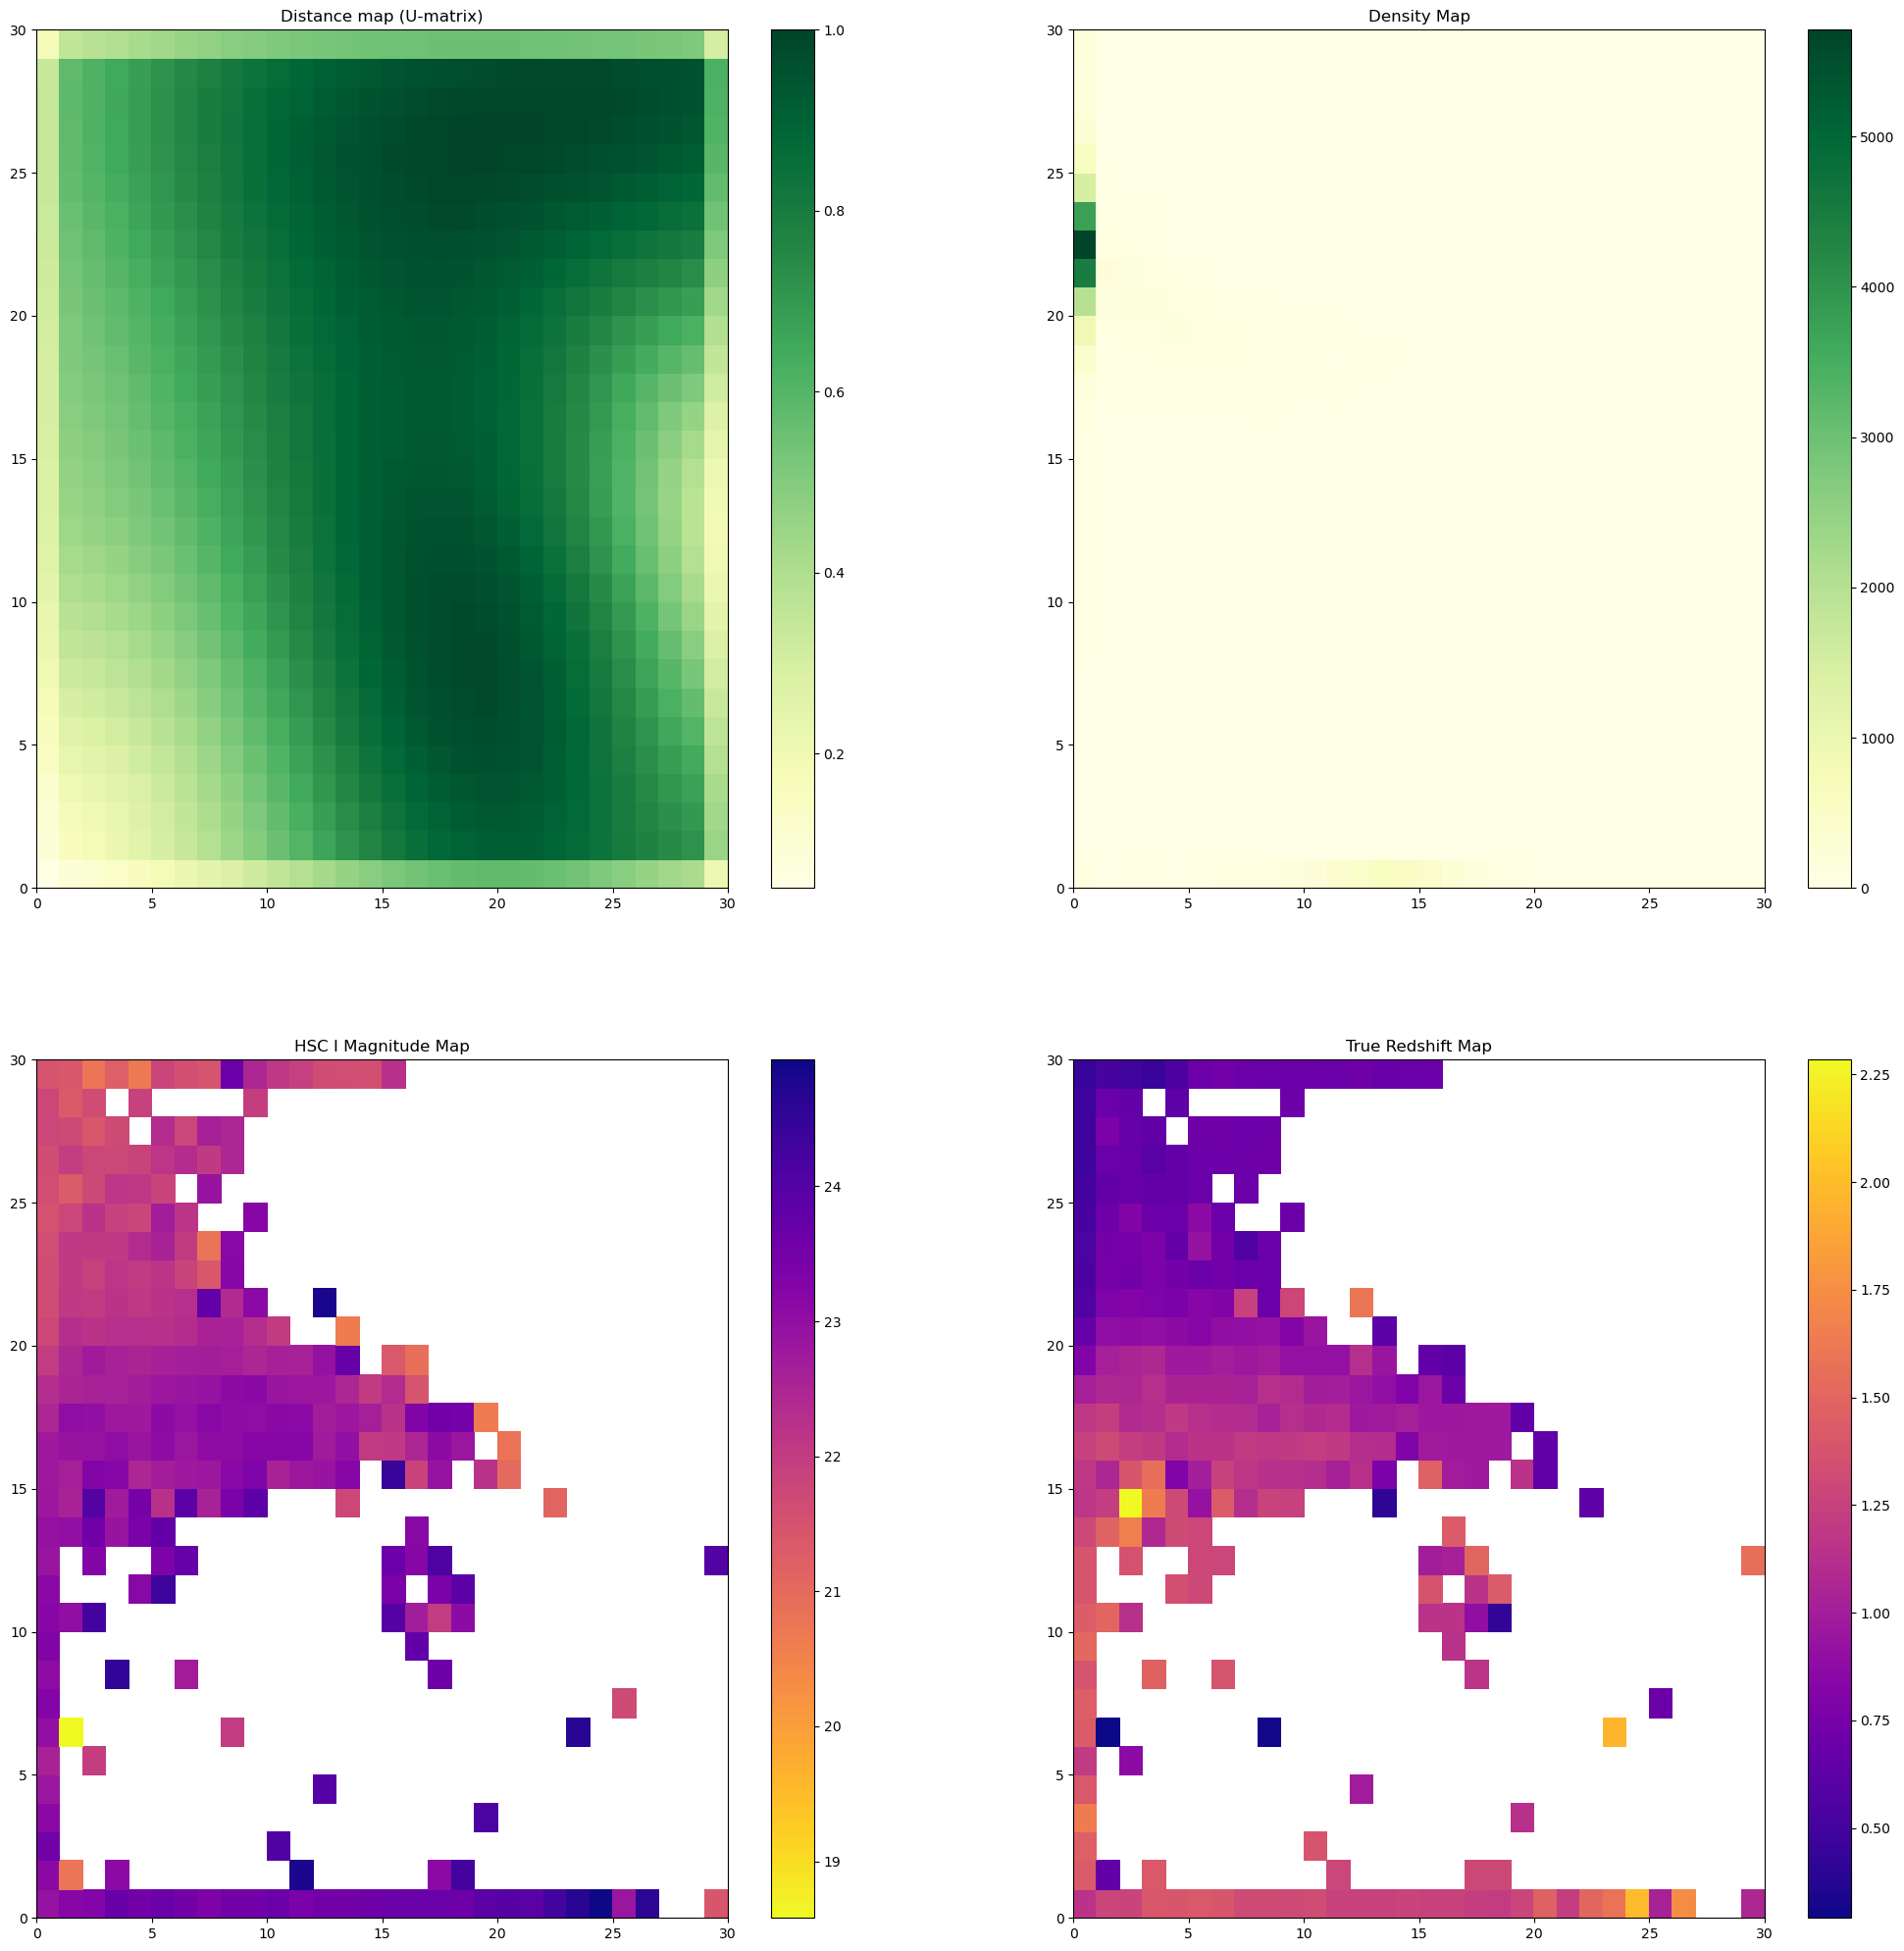

Finish traininging SOM.
Start making diagrams...
Finish collecting data for density map.
Finish collecting data for magnitude map.
[30, 30, 1.6]
Topological error: 0.003436310345989287
Quantization error: 0.42875898916433486
29683.0


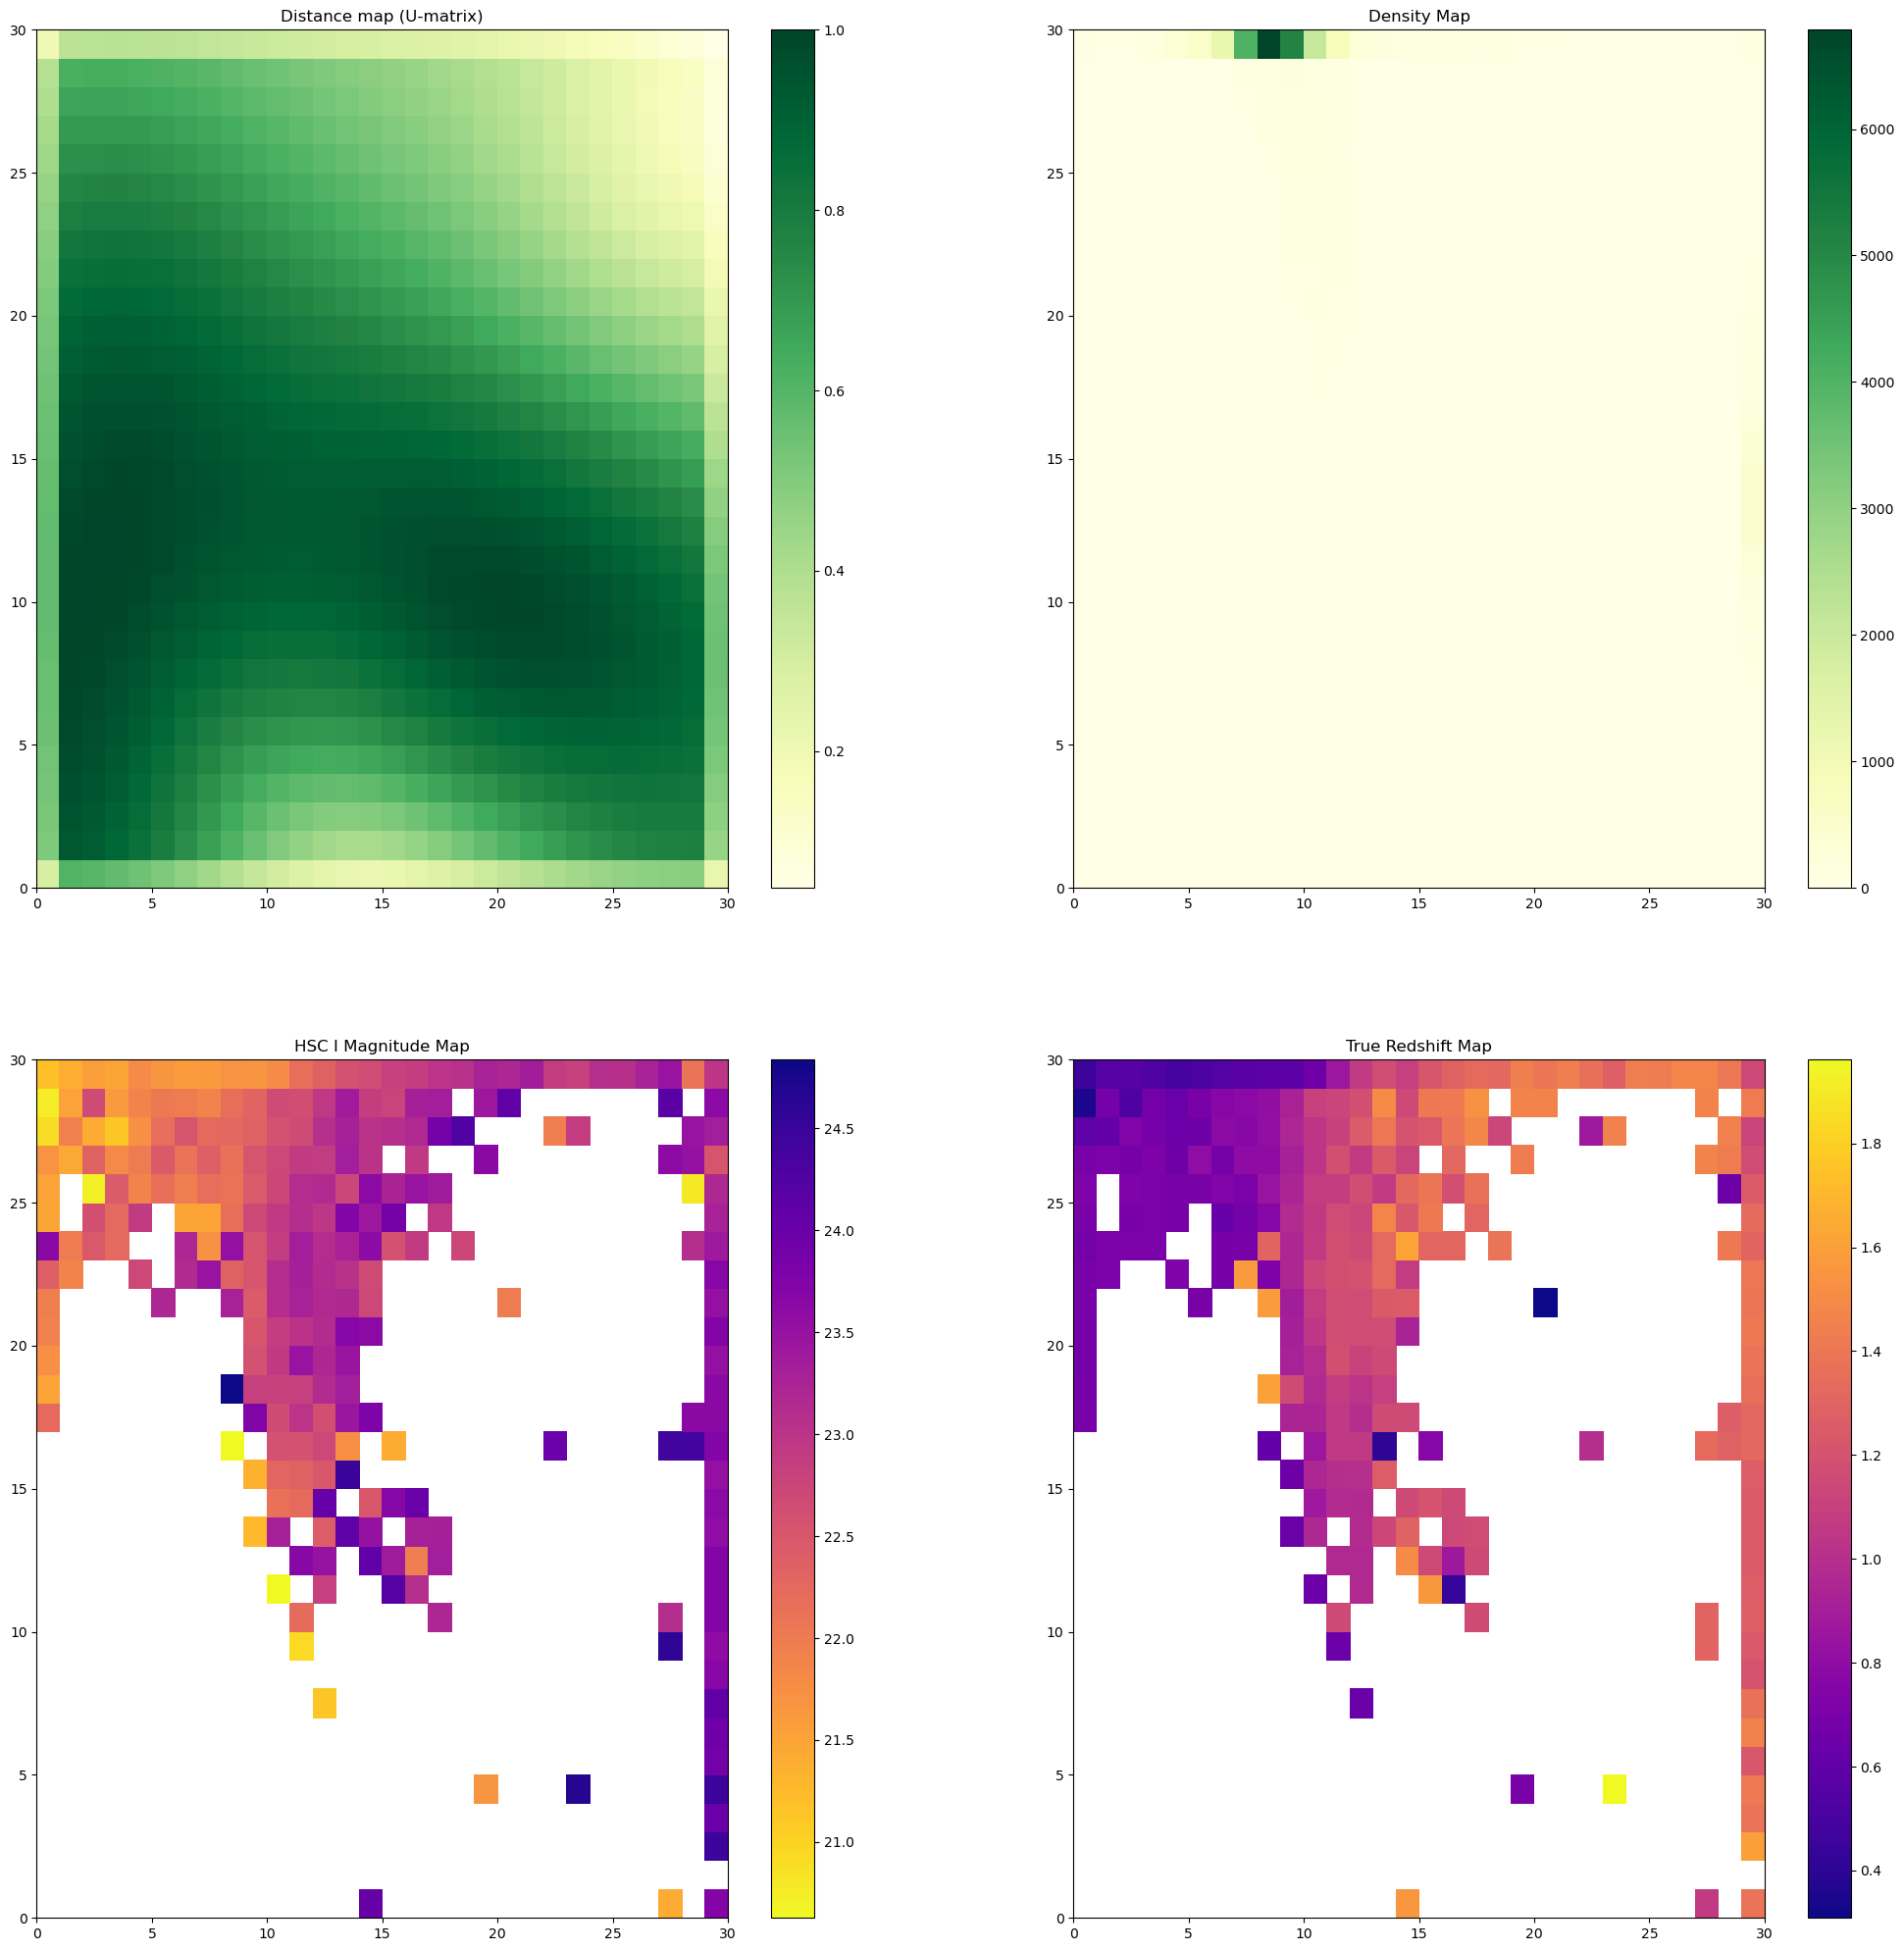

Finish traininging SOM.
Start making diagrams...
Finish collecting data for density map.
Finish collecting data for magnitude map.
[30, 30, 1.7]
Topological error: 0.005895630495569855
Quantization error: 0.421322369177562
29683.0


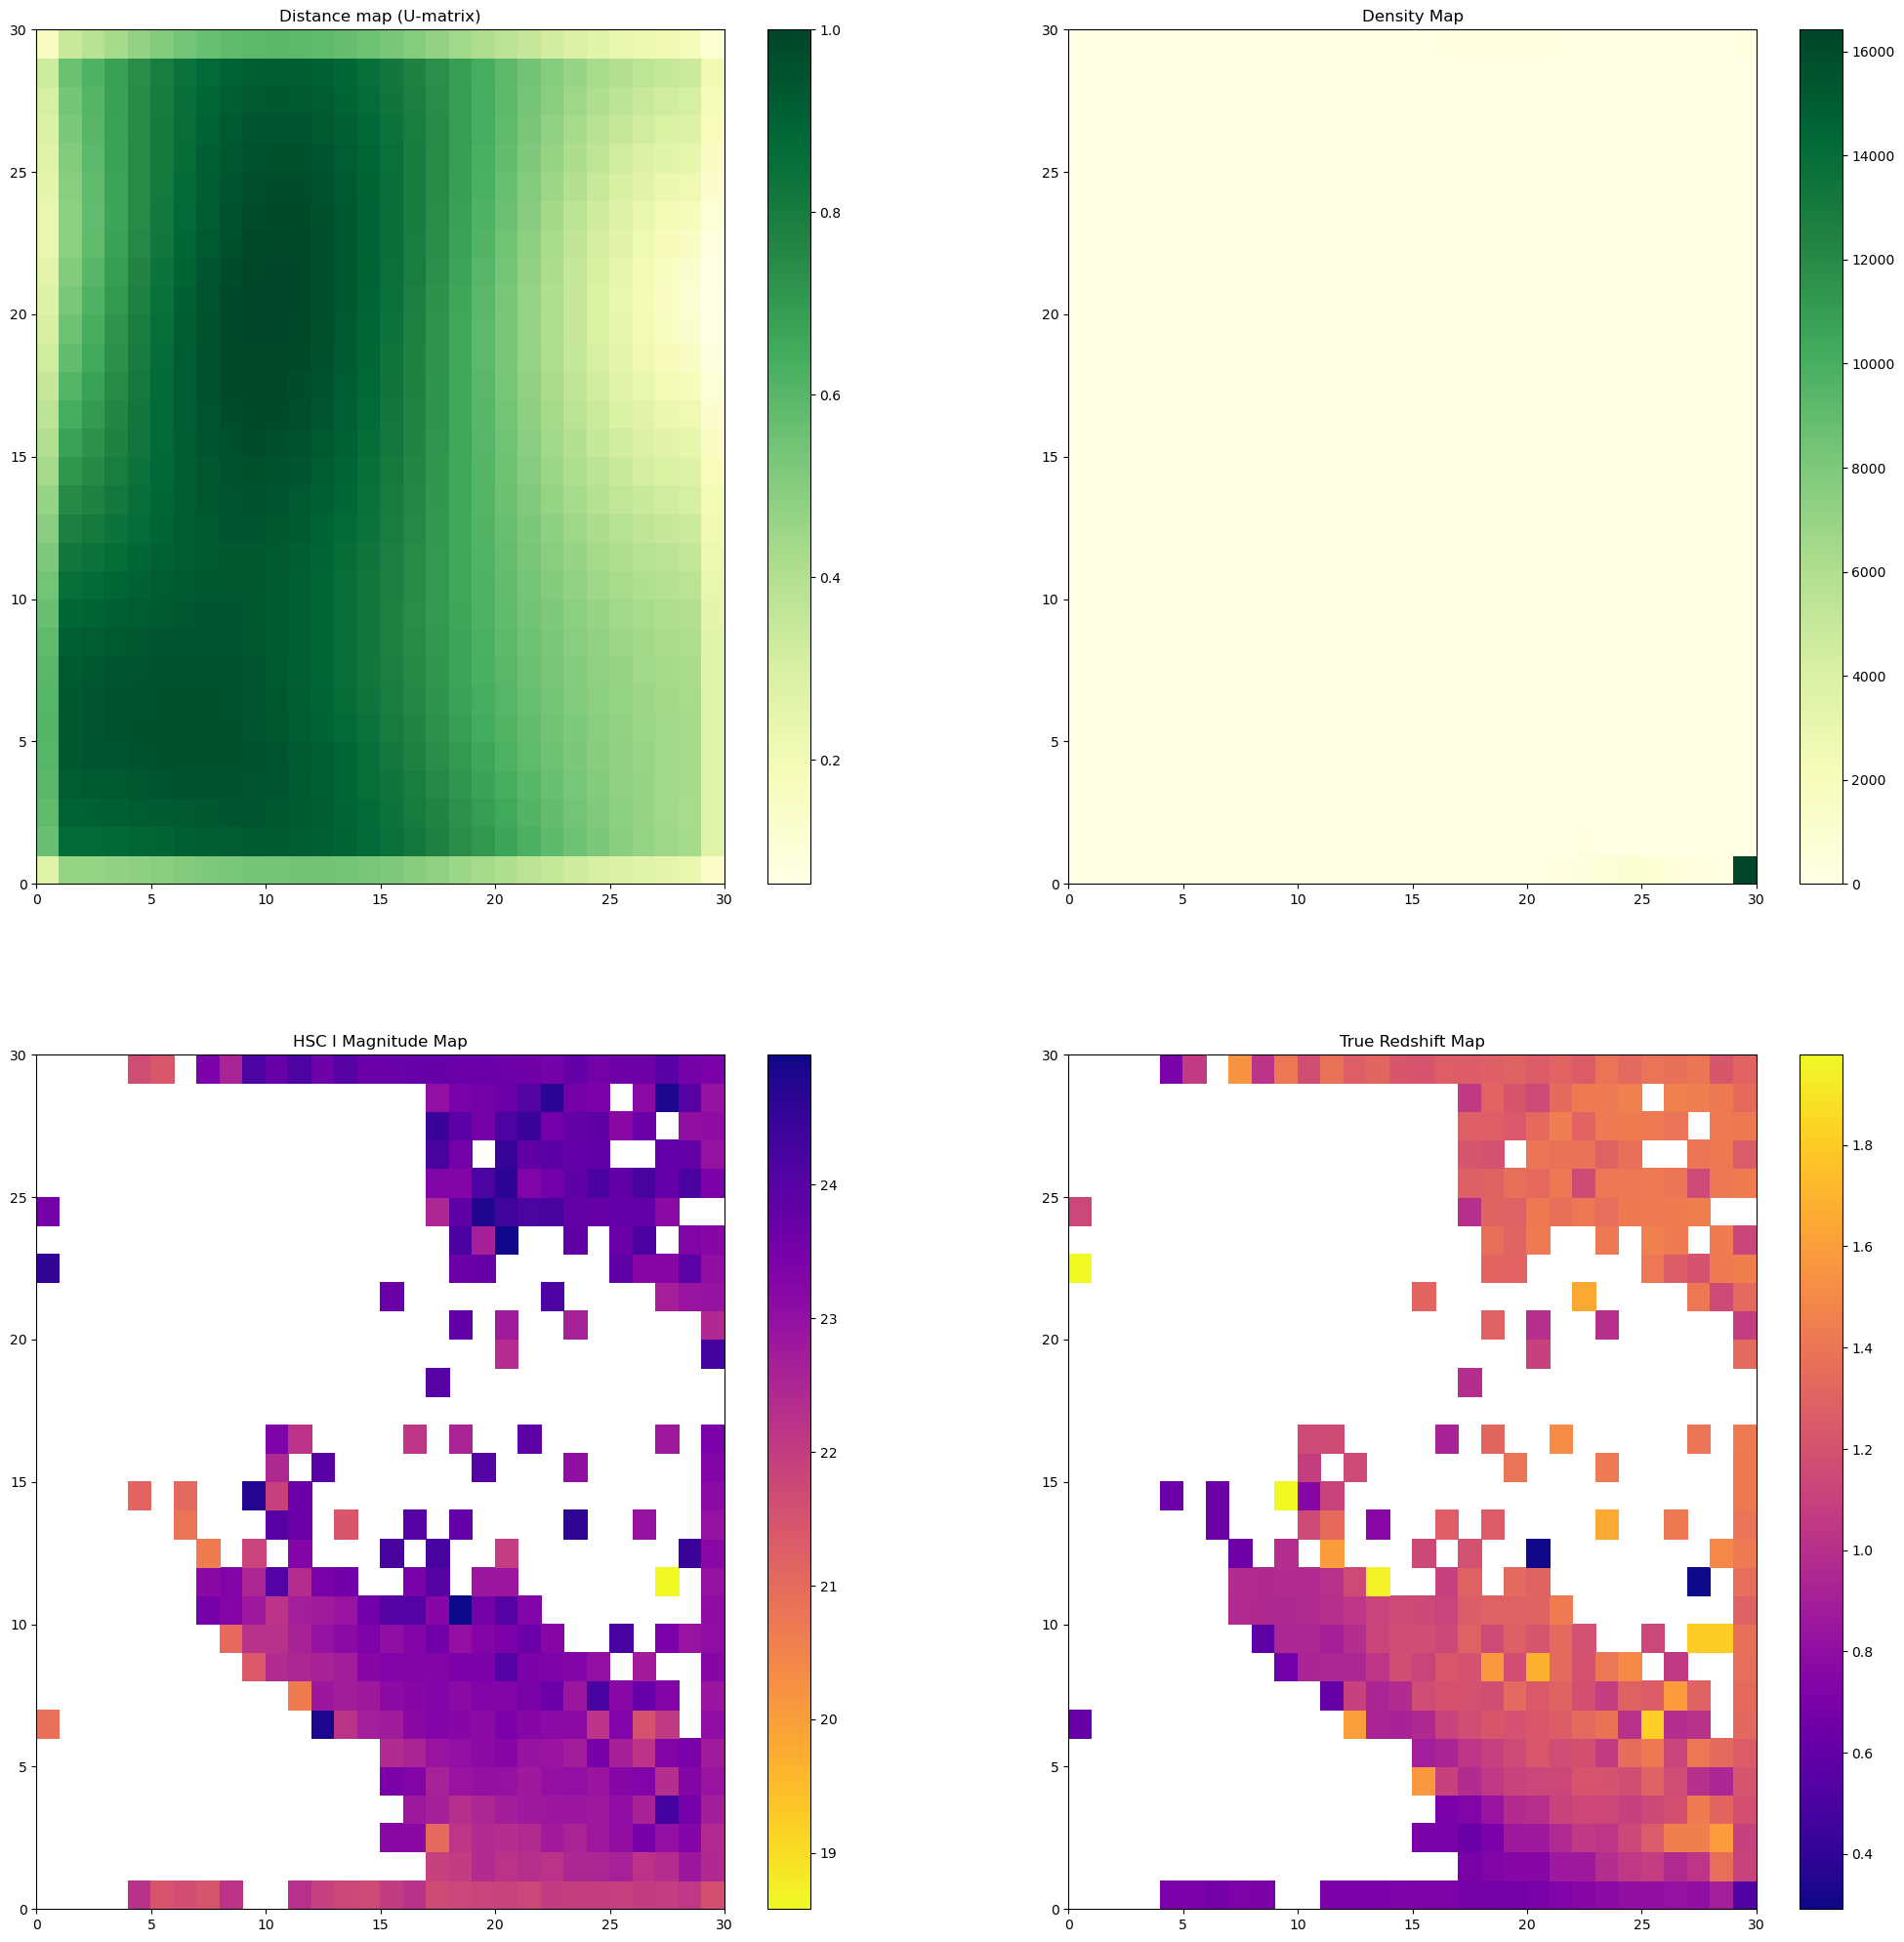

Finish traininging SOM.
Start making diagrams...
Finish collecting data for density map.
Finish collecting data for magnitude map.
[30, 30, 1.8]
Topological error: 0.02590708486338982
Quantization error: 0.4302132093475188
29683.0


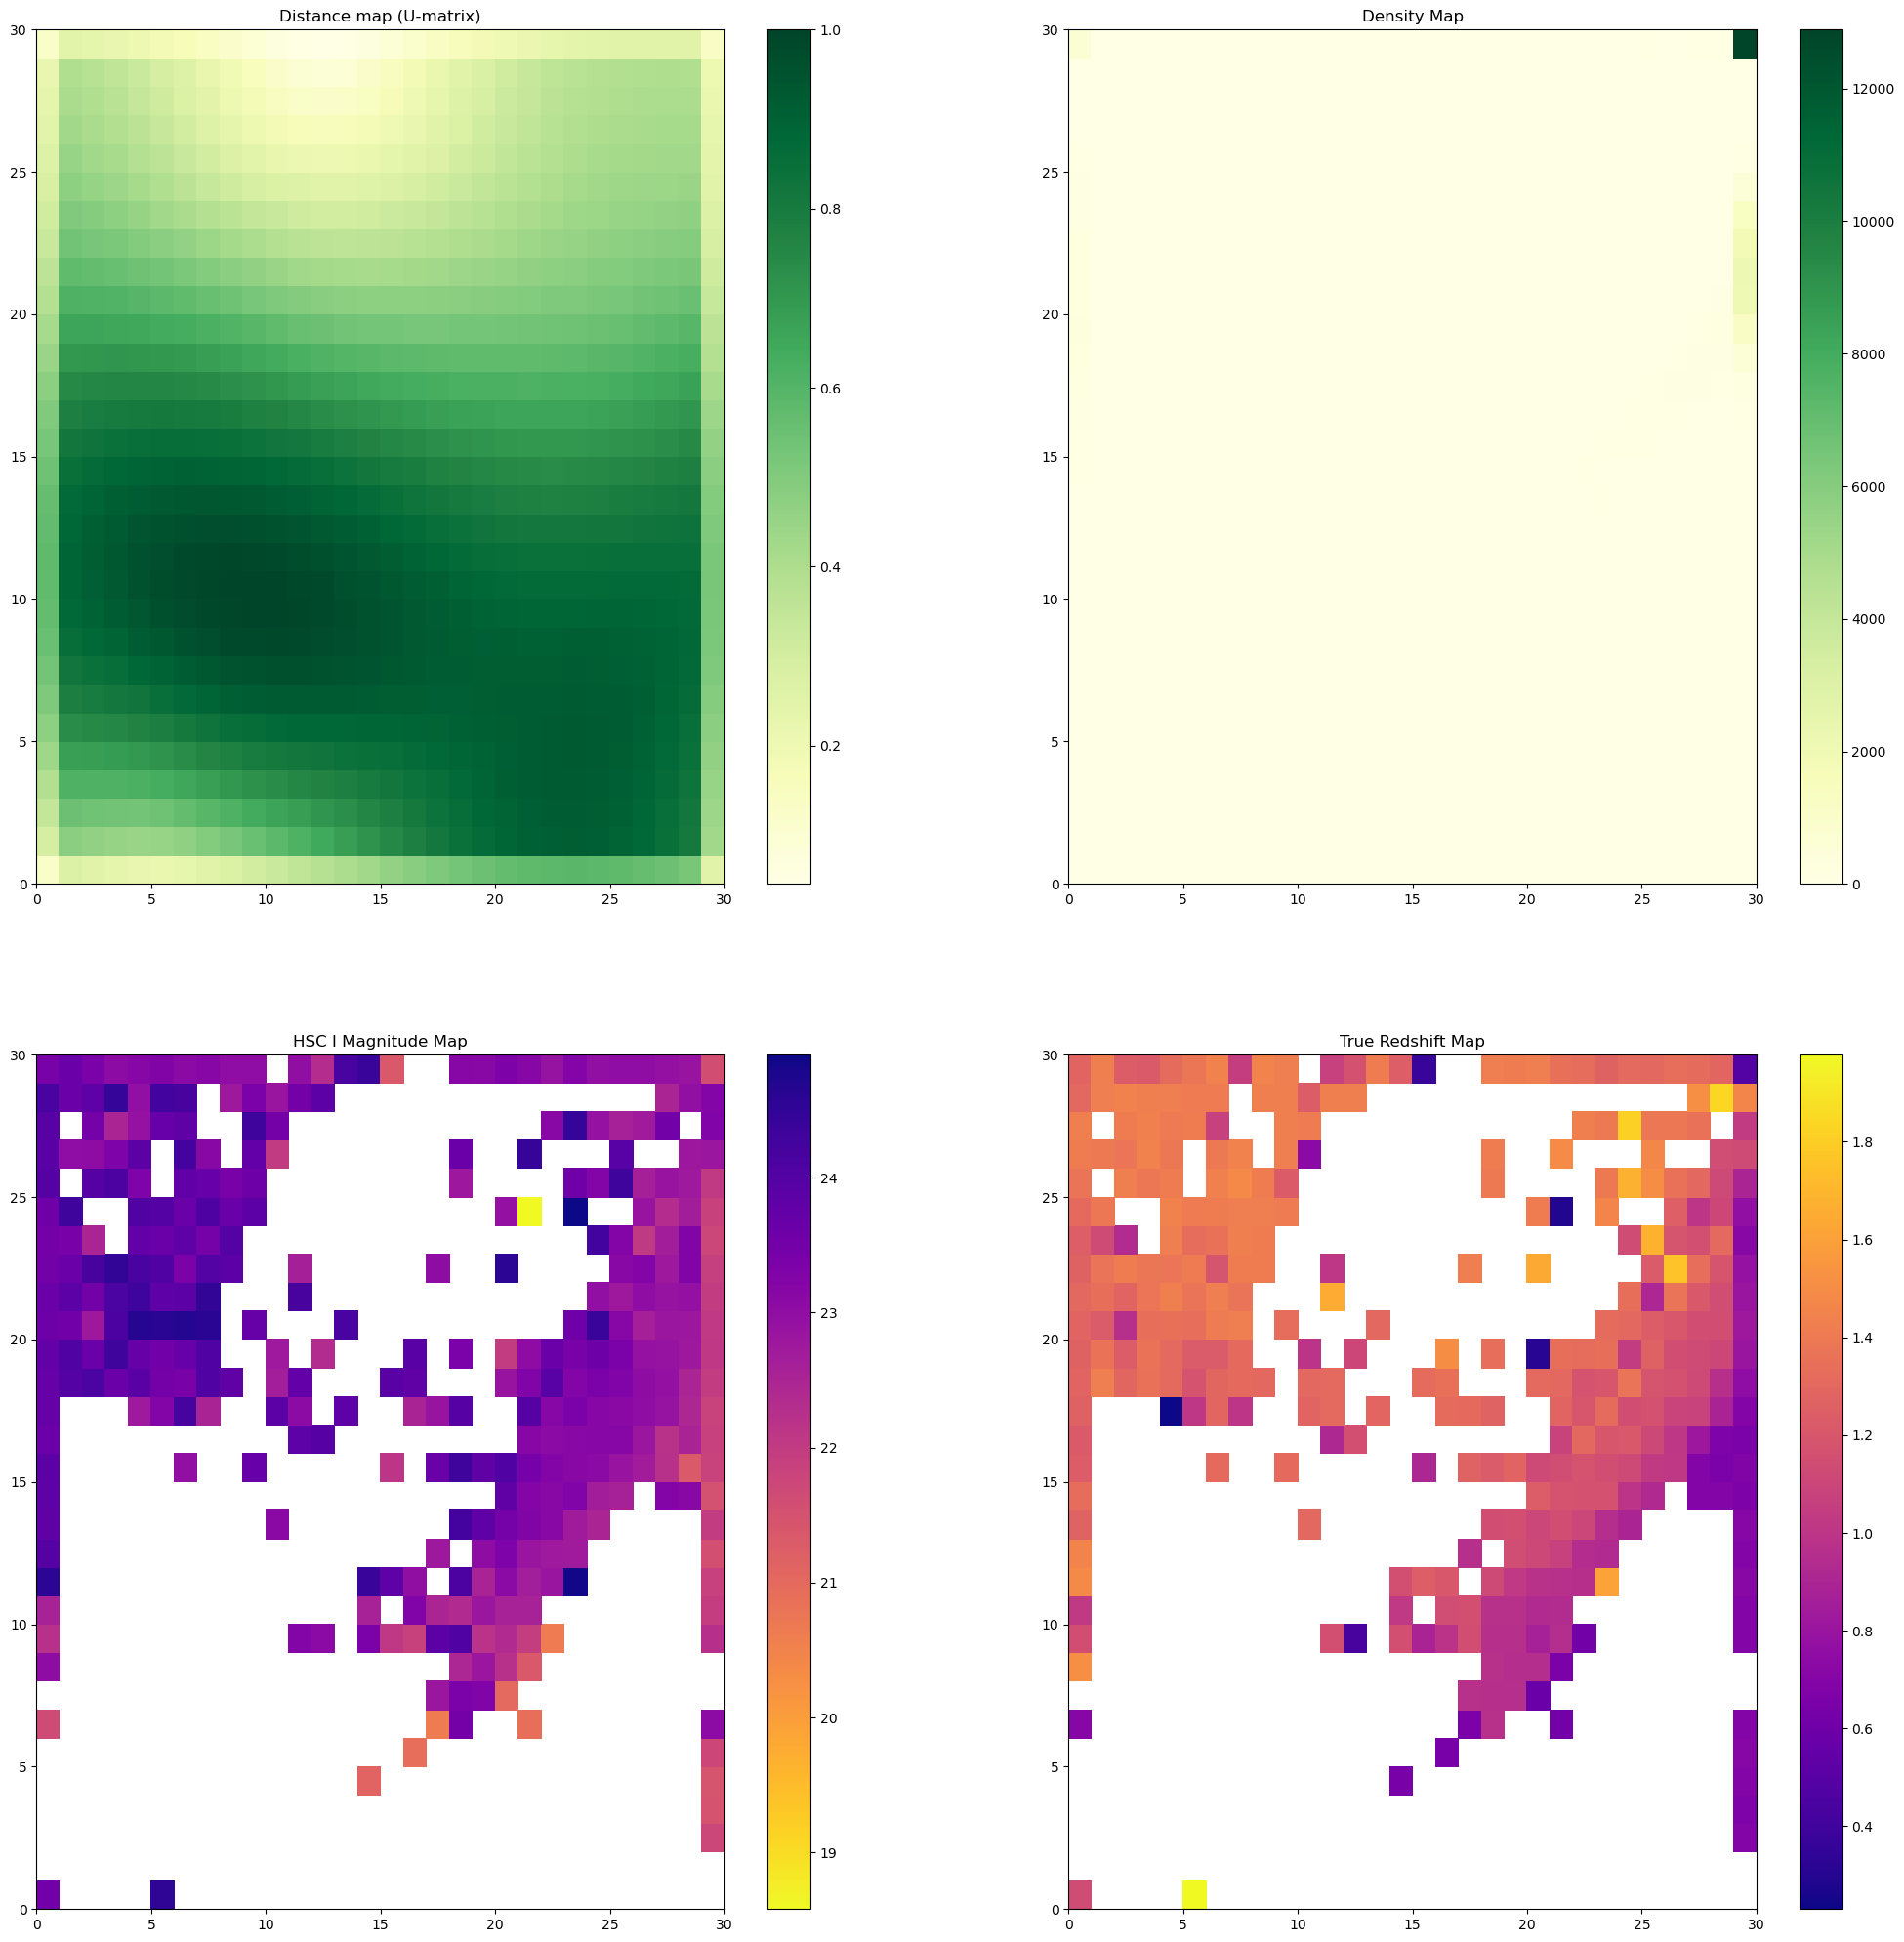

Finish traininging SOM.
Start making diagrams...
Finish collecting data for density map.
Finish collecting data for magnitude map.
[30, 30, 1.9]
Topological error: 0.0355085402418893
Quantization error: 0.4327607104422002
29683.0


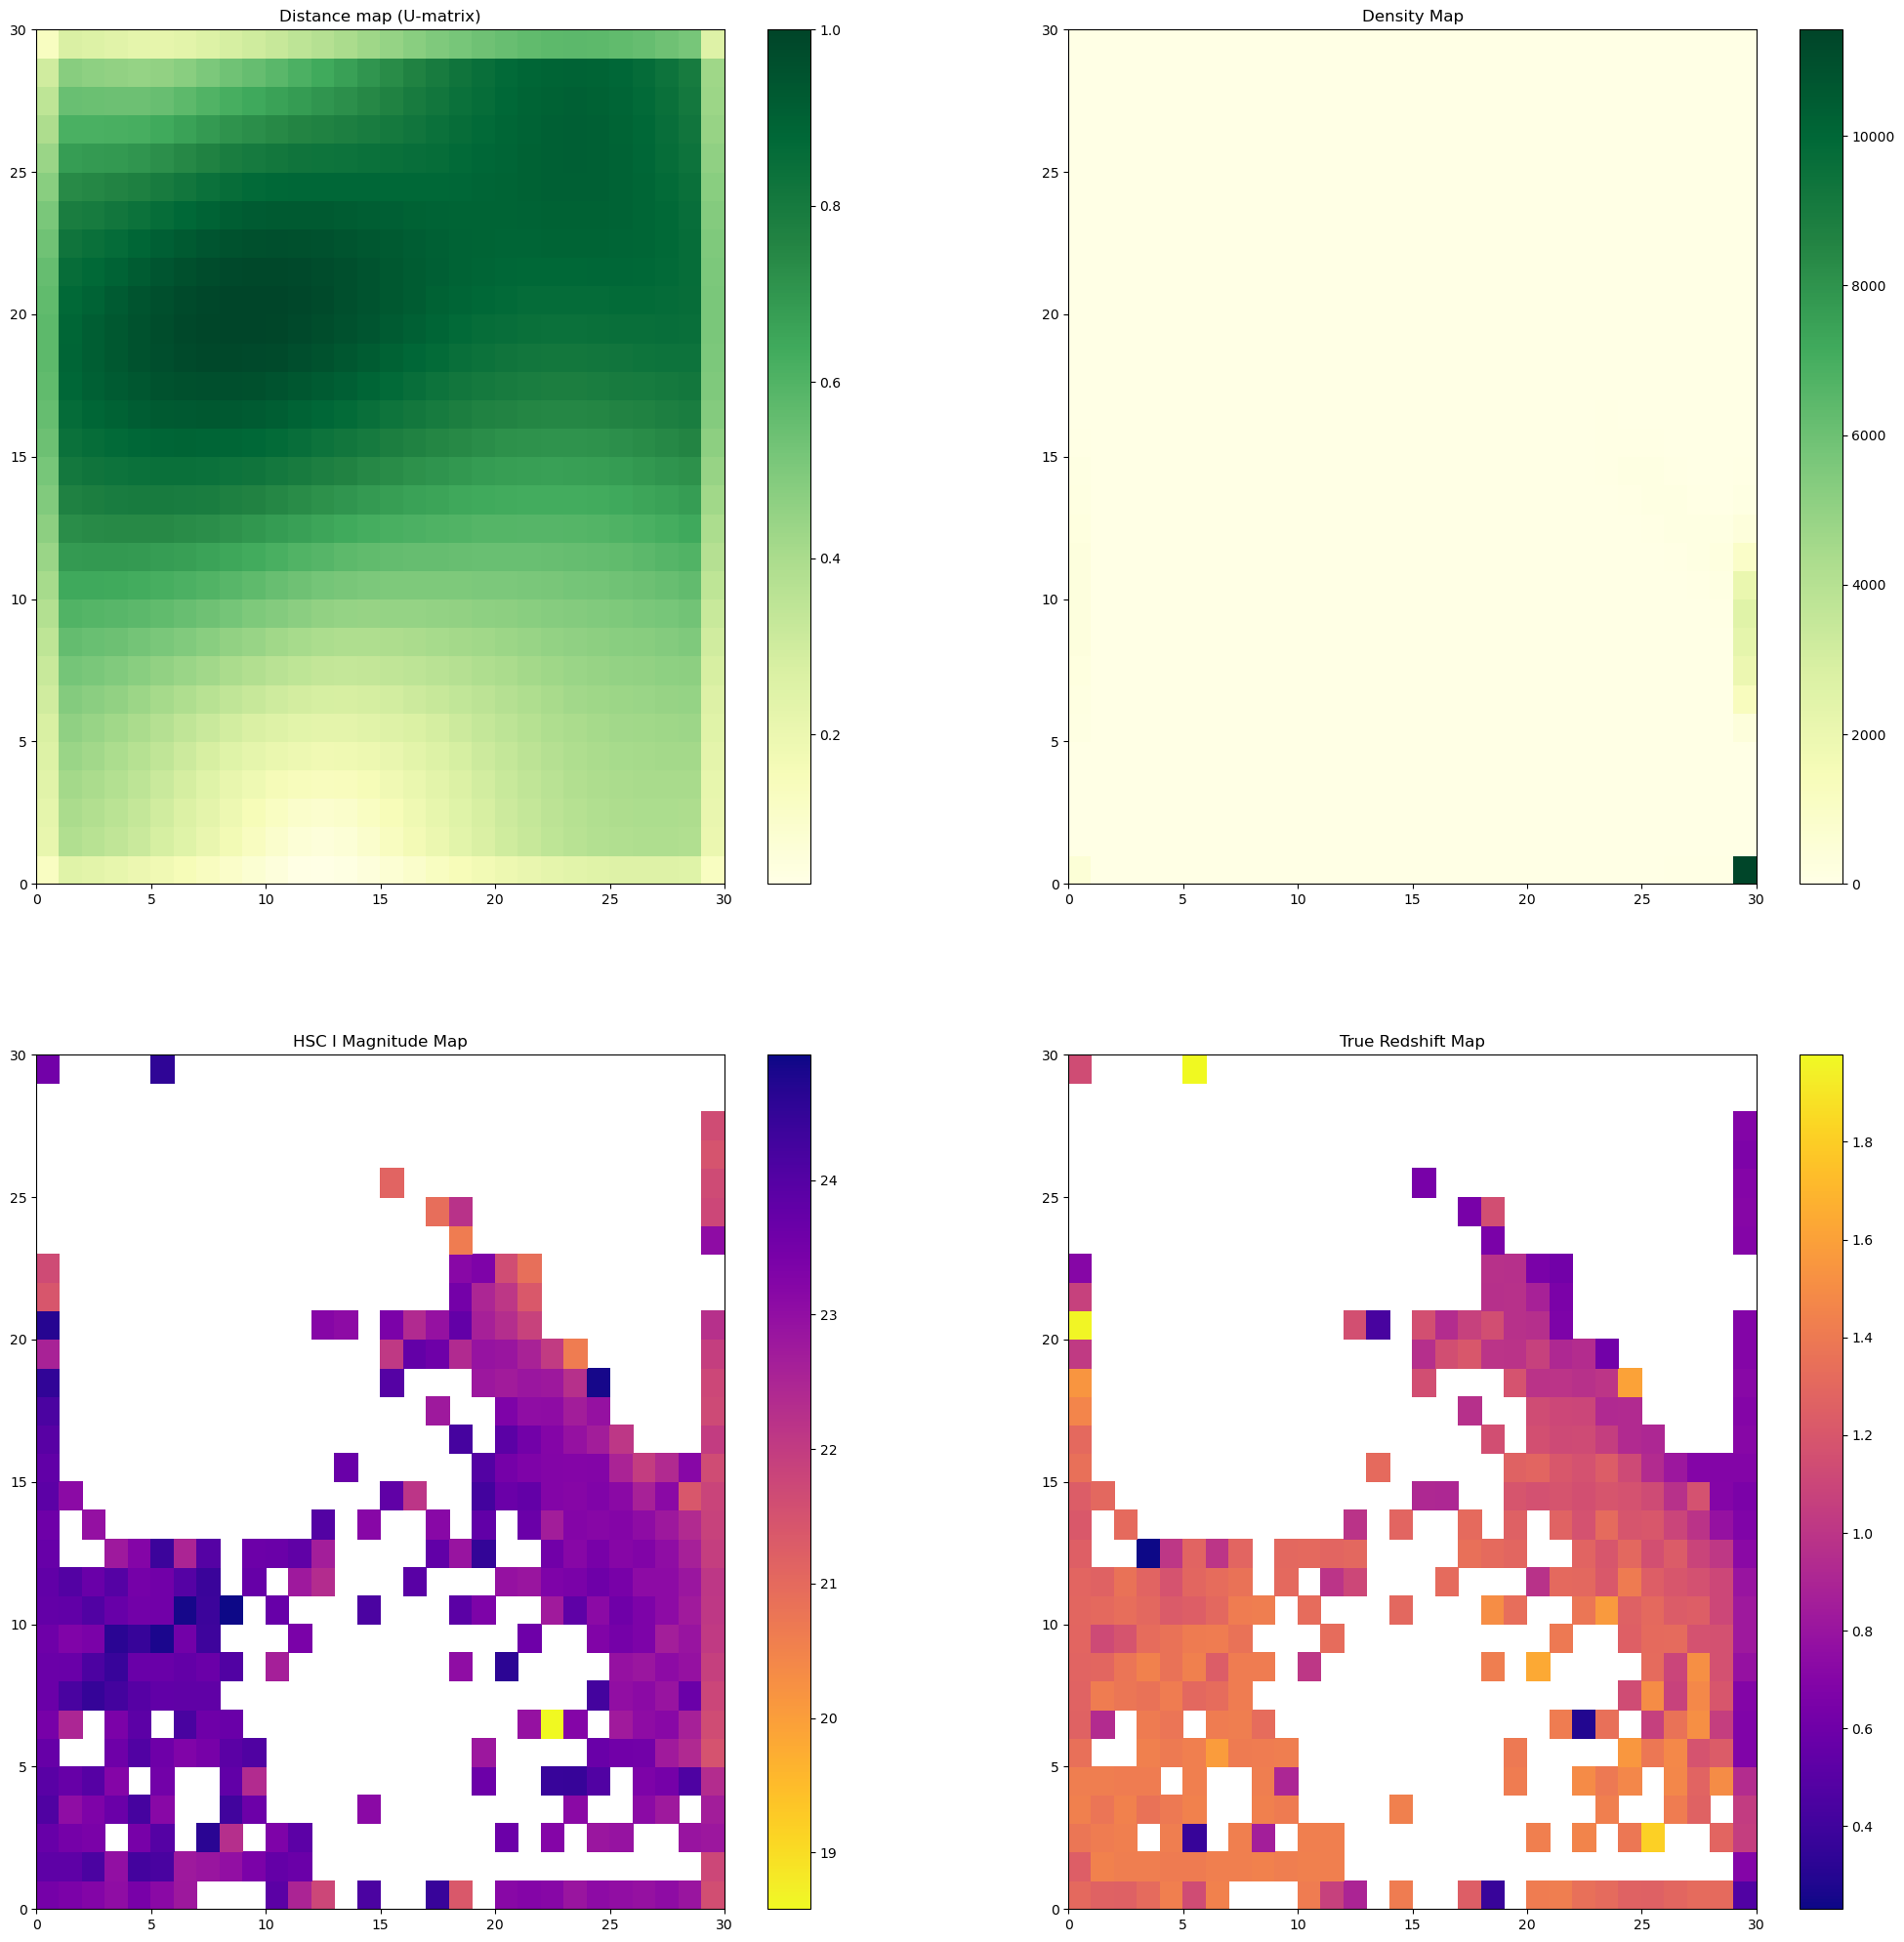

Finish traininging SOM.
Start making diagrams...
Finish collecting data for density map.
Finish collecting data for magnitude map.
[30, 30, 2.0]
Topological error: 0.011723882356904625
Quantization error: 0.43442095436312855
29683.0


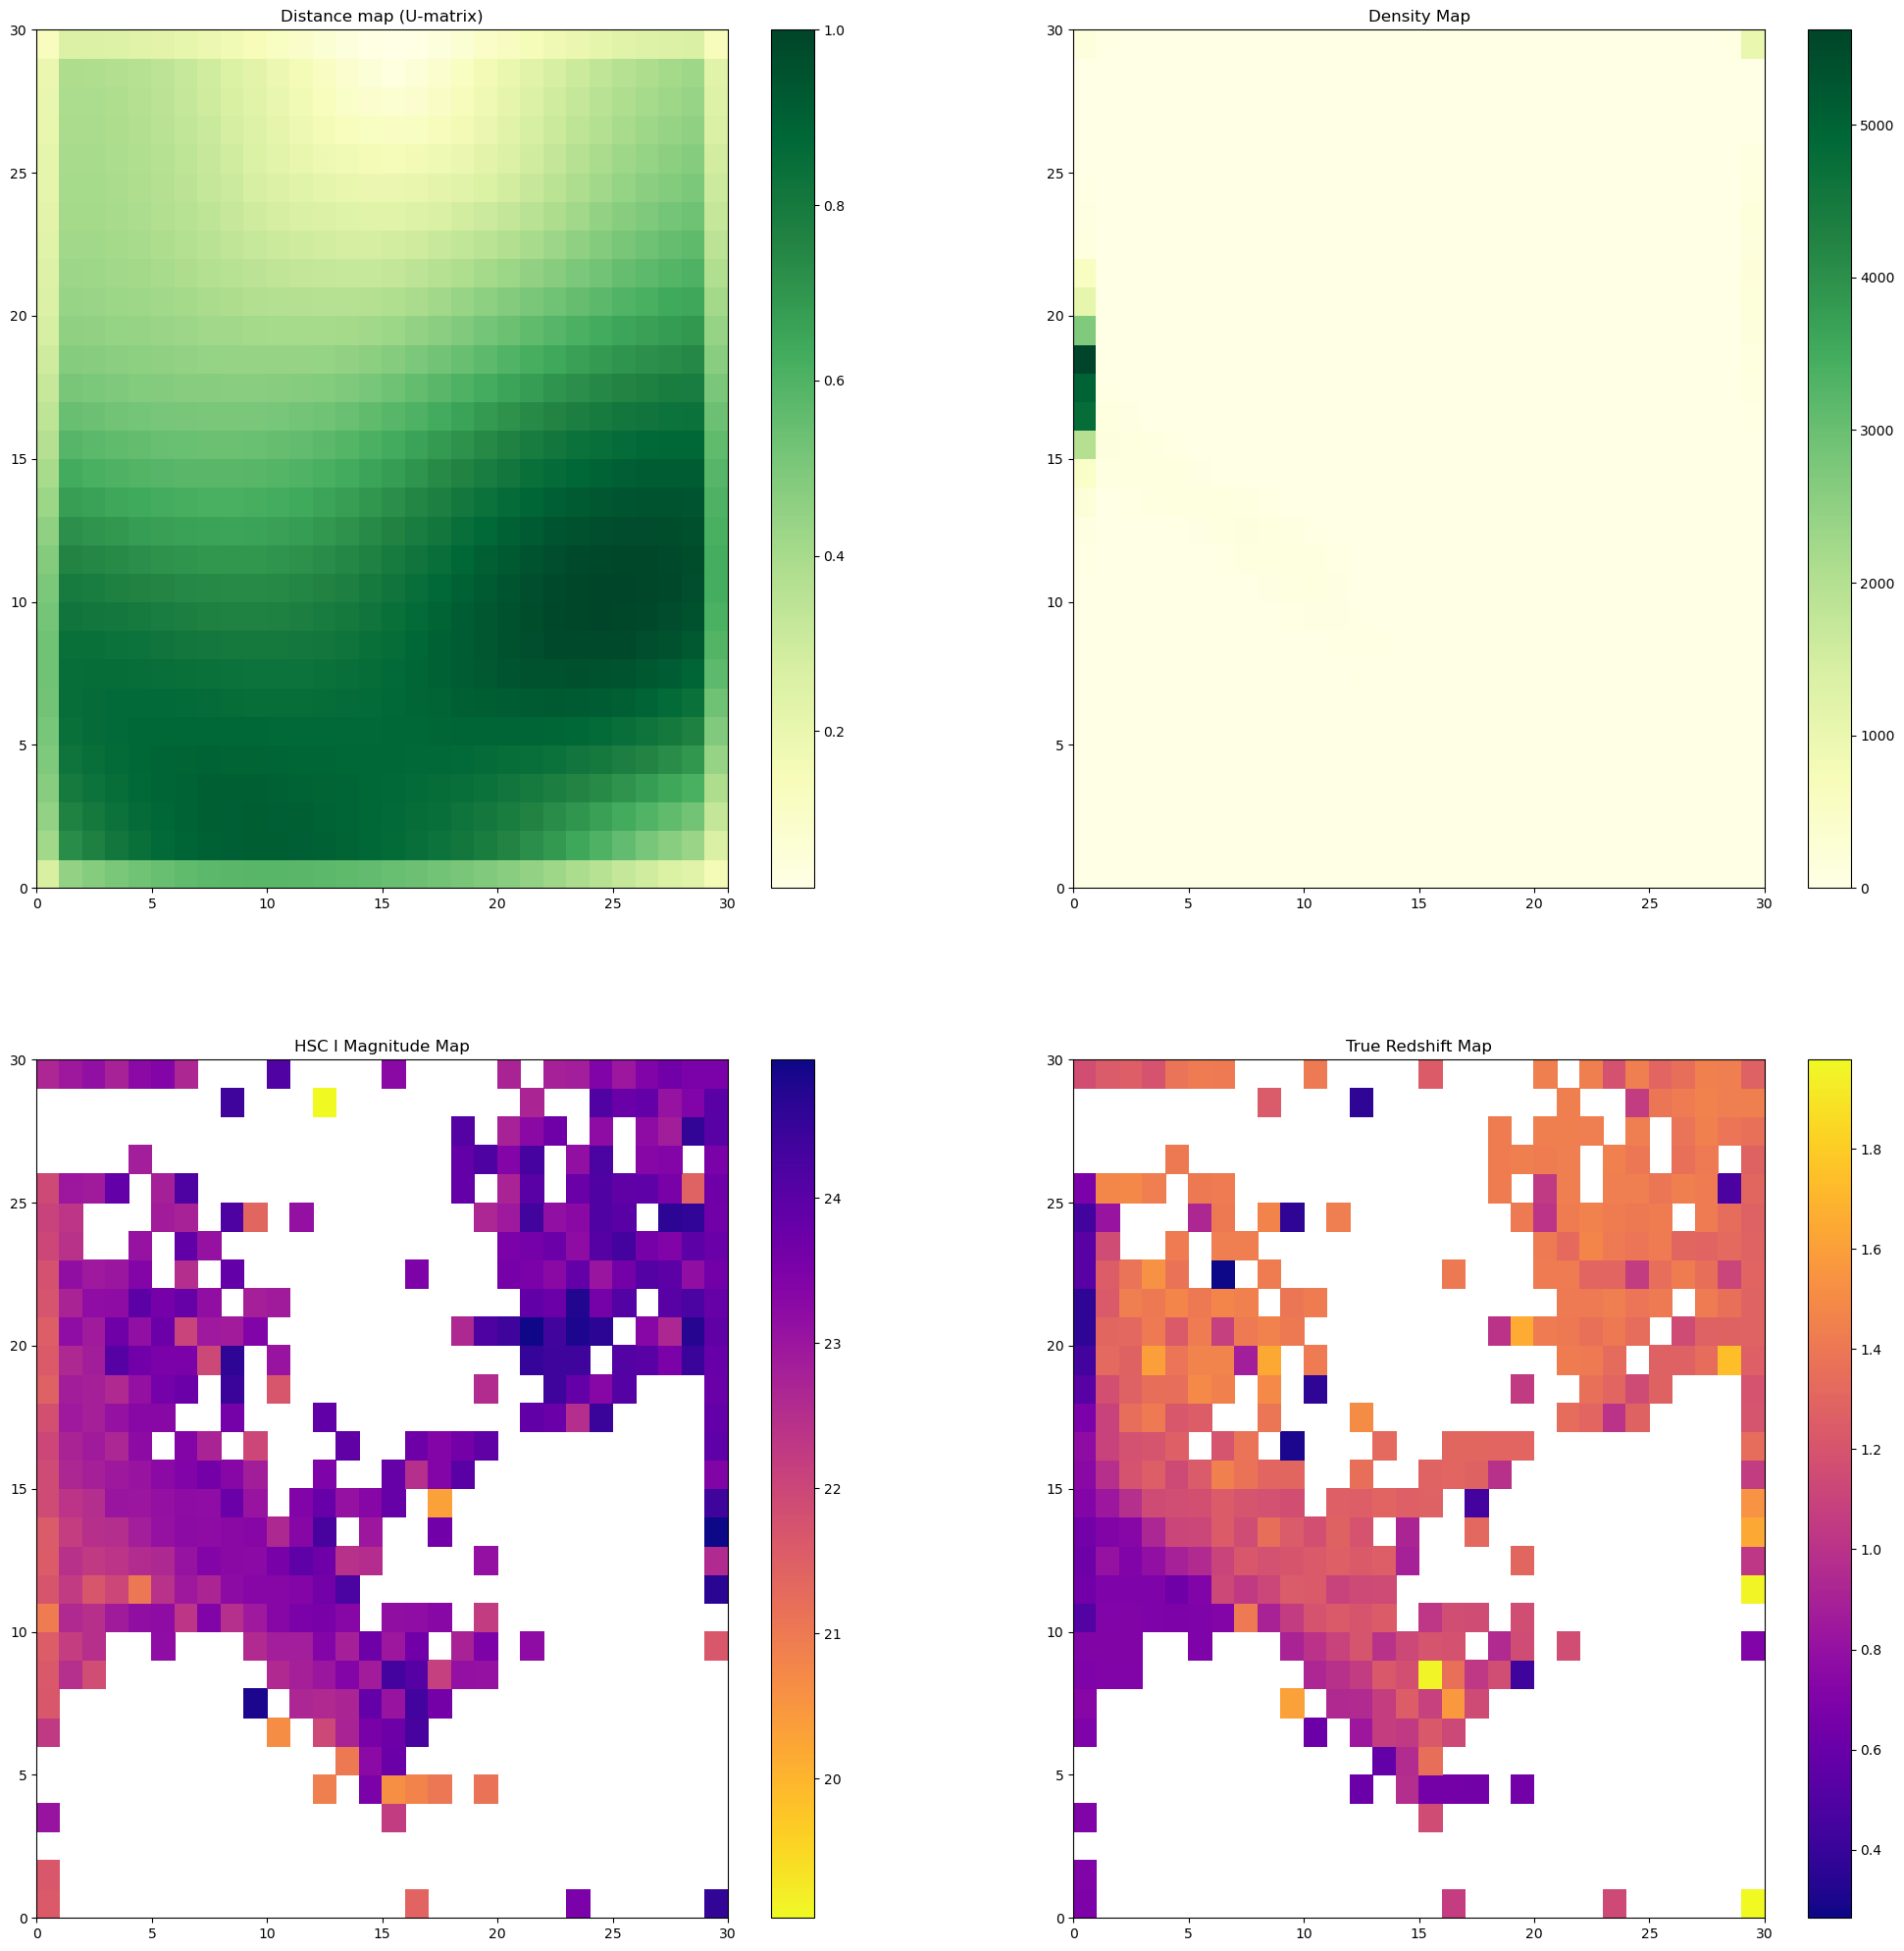

Finish traininging SOM.
Start making diagrams...
Finish collecting data for density map.
Finish collecting data for magnitude map.
[30, 30, 2.1]
Topological error: 0.010612134892025738
Quantization error: 0.4405925047886621
29683.0


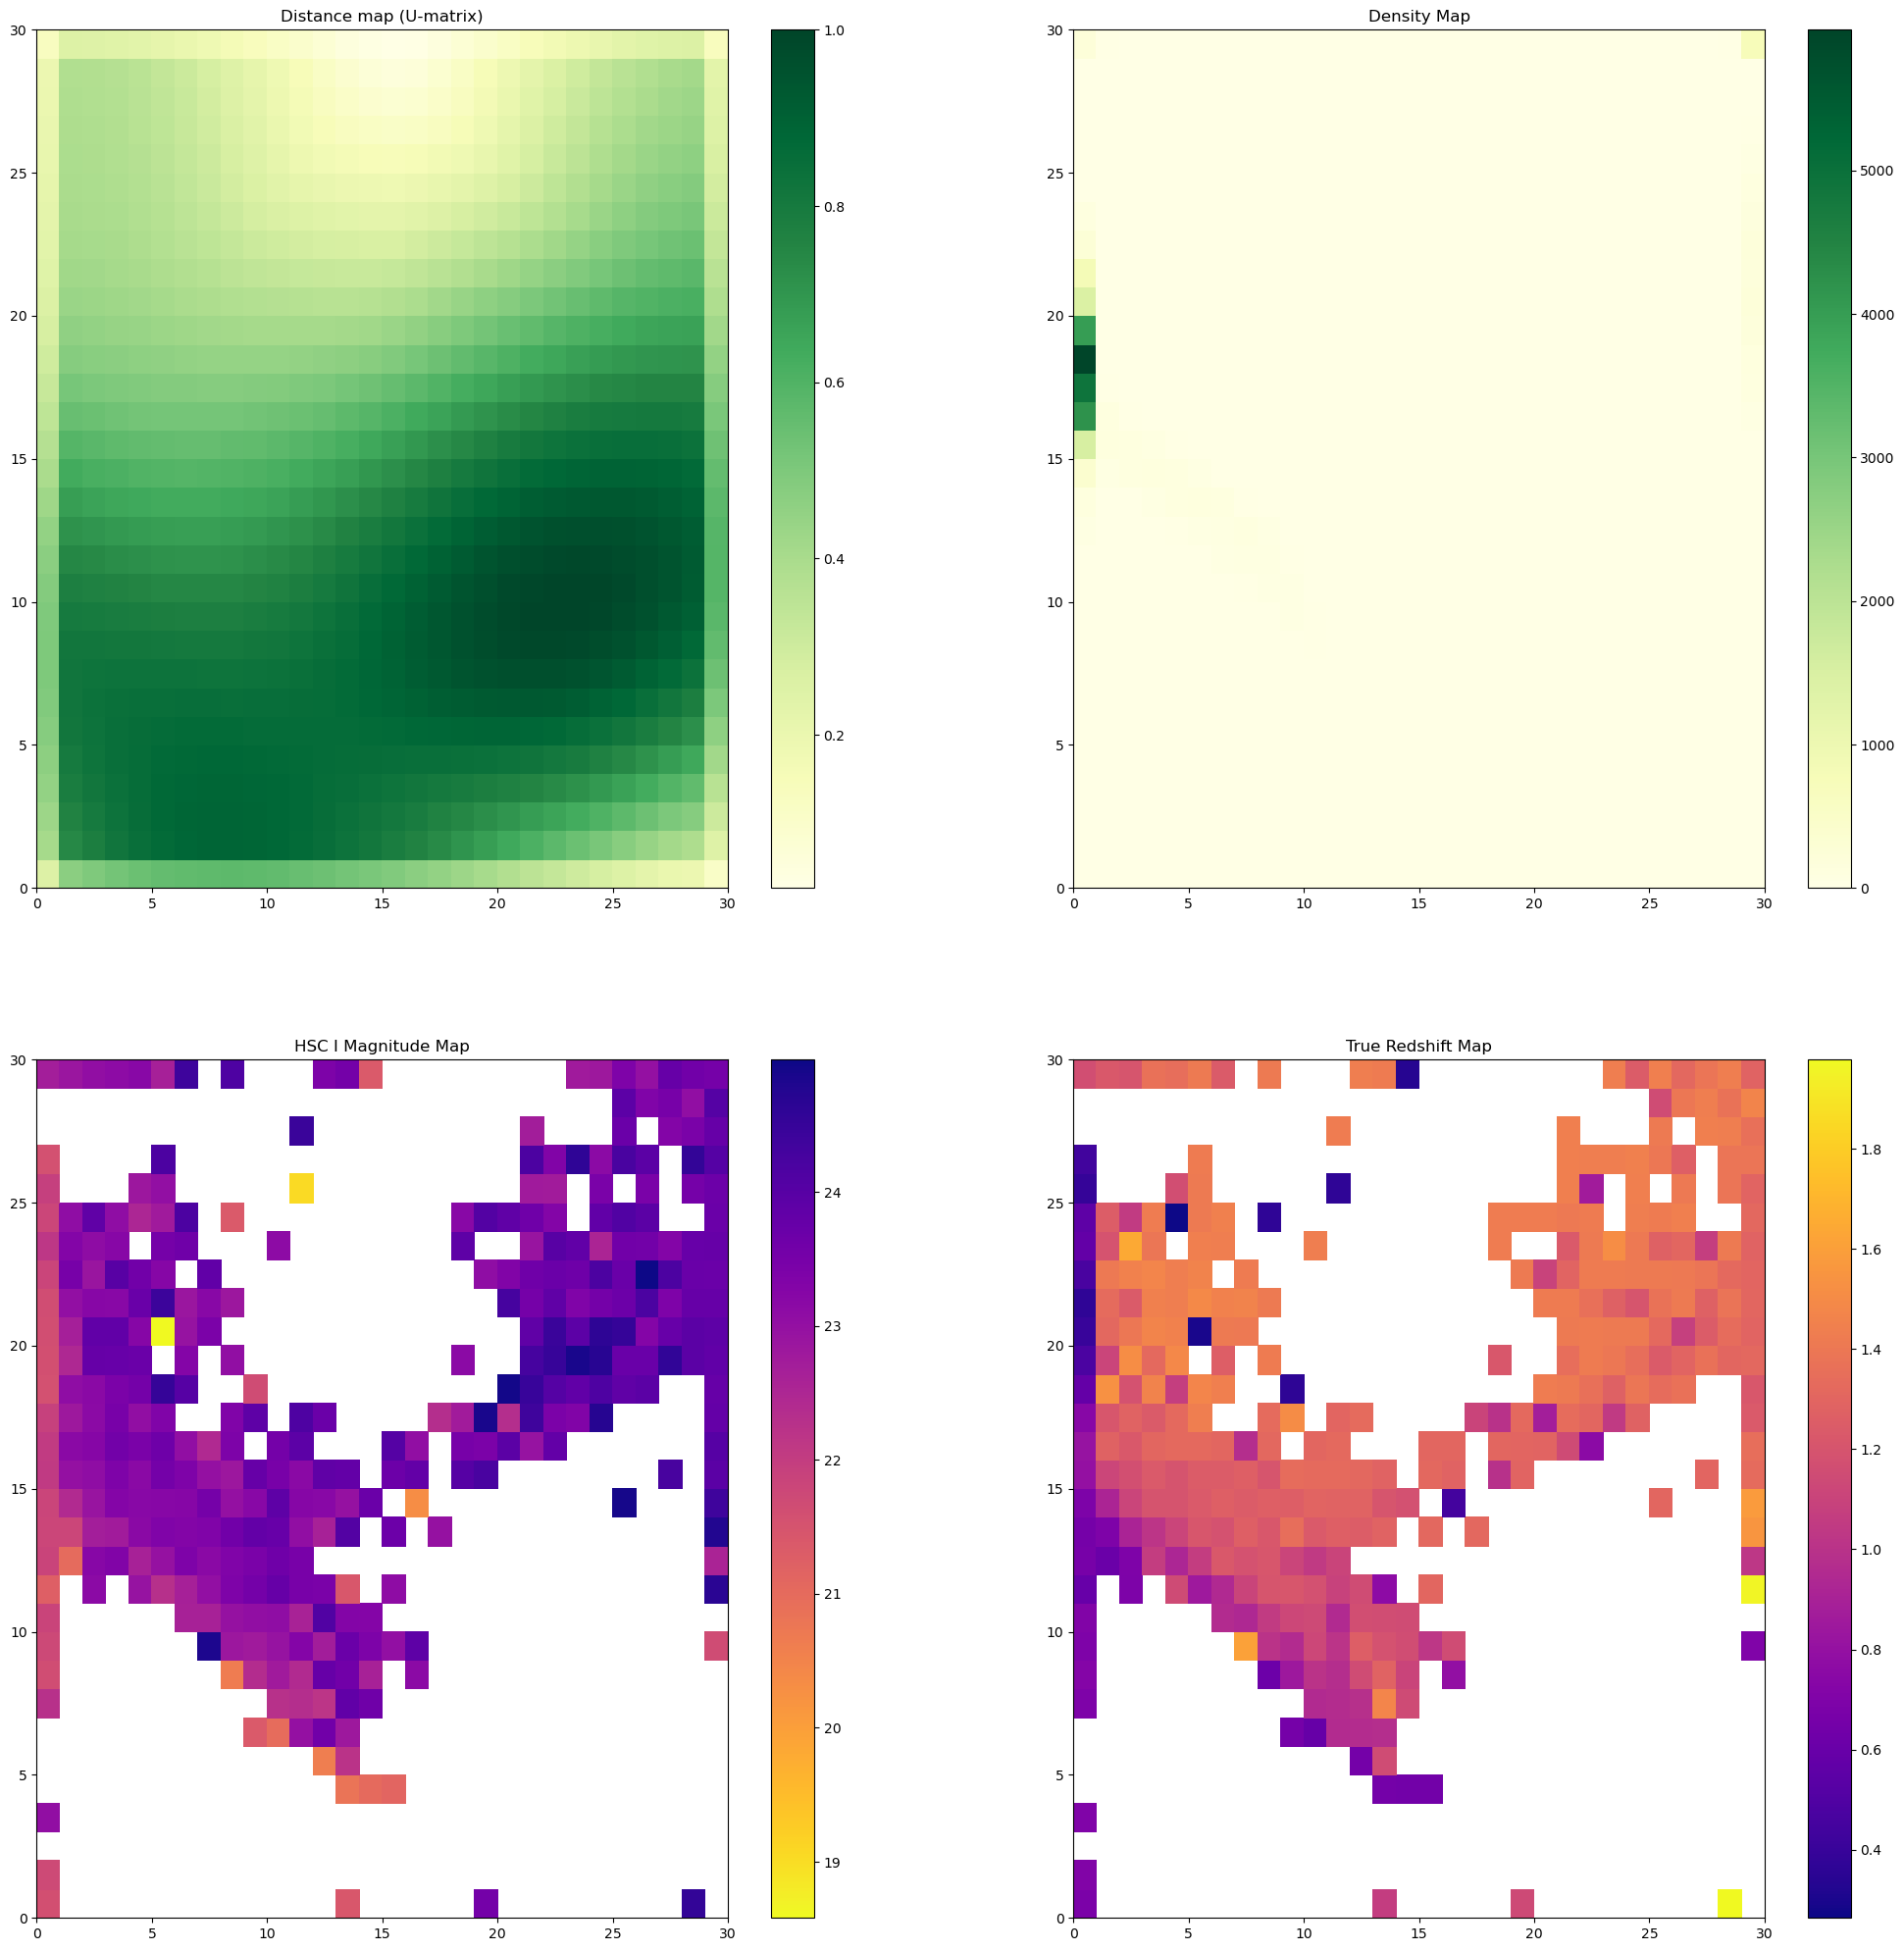

In [ ]:
for i in range(1, 31):
    som = basic_som(data = proc_data, data_type = "noiseless_color", err = err, info_data = info, dim = 30, preproc = None, iteration = 2, sigma = 30, rate = i / 10, save = False, distance = "euclidean")
print("Finish the iteration")

In [ ]:
som = basic_som(data = proc_data, data_type = "noiseless_mag_shallow", err = err, info_data = info, dim = 30, preproc = "default", iteration = 10, sigma = 0.8, rate = 0.5, save = True, distance = "euclidean")